Self-contained ipython notebook

In [172]:
import torch.nn.functional as F
import torch.nn as nn
from image_utils import BatchShift
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from torch.autograd import Variable
import torch.nn as nn
import torch.optim as optim
from cv2 import warpAffine

In [179]:
class Capsule(nn.Module):
    ''' Define one capsule '''
    def __init__(self, input_dim, cap_dim, gen_dim, xy_dim = 2):
        '''
        input_dim: input dimension of each image
        cap_dim: dimension of recongnition unit
        gen_dim: dimension of generation unit
        xy_dim: dimension of x y transformation
        '''
        super(Capsule, self).__init__()
        self.indim = input_dim
        self.cpdim = cap_dim
        self.gndim = gen_dim
        self.xytrn = xy_dim
        self.regLayer = nn.Linear(self.indim, self.cpdim) #Recognizer units
        self.xyLayer = nn.Linear(self.cpdim, self.xytrn) #estimates of the X and Y
        self.probLayer = nn.Linear(self.cpdim, 1)          #prob of feature
        self.genLayer = nn.Linear(self.xytrn, self.gndim) #The generator
        self.reconLayer = nn.Linear(self.gndim, self.indim) #The reconstructed image

    def forward(self, X, delxy, sp = False): 
        X = X.view(-1, 28*28)
        regonition = torch.sigmoid(self.regLayer(X))
        self.x_y = self.xyLayer(regonition)
        self.prb = torch.sigmoid(self.probLayer(regonition))  # should have sigmoid otherwise cannot act as gate
        #self.prb = self.pr(regonition)
        self.gen = self.genLayer(self.x_y + delxy)
        
        self.rec = self.reconLayer(self.gen)
        self.delxy = delxy
        return torch.mul(self.rec, self.prb)

class CapLayer(nn.Module):
    ''' parallel capules  '''
    def __init__(self, num_caps, in_dim, cap_dim, gen_dim):
        super(CapLayer, self).__init__()
        self.caps = nn.ModuleList([
                Capsule(in_dim, cap_dim, gen_dim)
                for _ in range(num_caps)])
        
    def forward(self, X, delxy):
        self.caps_out = [cap(X, delxy) for cap in self.caps]
        reconImage = sum(self.caps_out)
        reconImage = torch.sigmoid(reconImage)
        return reconImage

def show_batch(batch,title='misc',save = False):
    try:
        if batch.is_cuda:
            batch = batch.detach().cpu()
    except:
        pass
    im = torchvision.utils.make_grid(batch, normalize = True)
    plt.figure()
    plt.imshow(np.transpose(im.numpy(), (1, 2, 0)))
    if save:
        plt.imsave('images/{0}/ep_{1:05d}_img_{2:05d}.png'.format(title,epoch+1,i+1),np.transpose(im.numpy(), (1, 2, 0)))
    plt.show()
    
def show3(in1, in2, in3):
    '''show 3 images side-by-side'''
    try:
        if in1.is_cuda:
            in1 = in1.detach().cpu()
    except:
        pass
    try:
        if in2.is_cuda:
            in2 = in2.detach().cpu()
    except:
        pass
    try:
        if in3.is_cuda:
            in3 = in3.detach().cpu()
    except:
        pass
    im1 = torchvision.utils.make_grid(in1, normalize = True)
    im2 = torchvision.utils.make_grid(in2, normalize = True)
    im3 = torchvision.utils.make_grid(in3, normalize = True)
    fig, ax = plt.subplots(nrows=1, ncols=3)
    ax[0].imshow(np.transpose(im1.numpy(), (1, 2, 0)))
    ax[1].imshow(np.transpose(im2.numpy(), (1, 2, 0)))
    ax[2].imshow(np.transpose(im3.numpy(), (1, 2, 0)))
    fig.set_figheight(20)
    fig.set_figwidth(60)
    plt.show()

    
def shift(img, dx, dy):
    ''' shift an image  by dx and dy'''
    img = np.transpose(img, (1,2,0))
    r,c,_ = img.shape
    trans = np.array([[1,0,dx],[0,1,dy]]).astype(np.float32)
    wimg = warpAffine(img, trans, (r,c)).reshape(r,c,1)
    rimg = np.transpose(wimg, (2,0,1))
    return rimg

def BatchShift(imbatch, dxdy = [-4,4], random=True):
    '''
    imbatch: image batch
    dxdy: 2-d list to specify range of random shift [low, high]
    random: True - random shift. False - take dxdy as a constant shift [dx, dy] for all images
    '''
    dim = imbatch.shape
    if random:
        R = np.random.randint(low=dxdy[0], high=dxdy[1], size=(dim[0],2))    
    else:
        R = np.array([dxdy]*dim[0])
        
    for i in range(dim[0]):
        imbatch[i] = shift(imbatch[i], R[i][0], R[i][1])
    return imbatch, R

In [116]:
BATCH_SIZE = 64
NUM_EPOCH = 5

transform = transforms.ToTensor()
trainset = torchvision.datasets.MNIST('/tmp', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

testset = torchvision.datasets.MNIST('/tmp', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

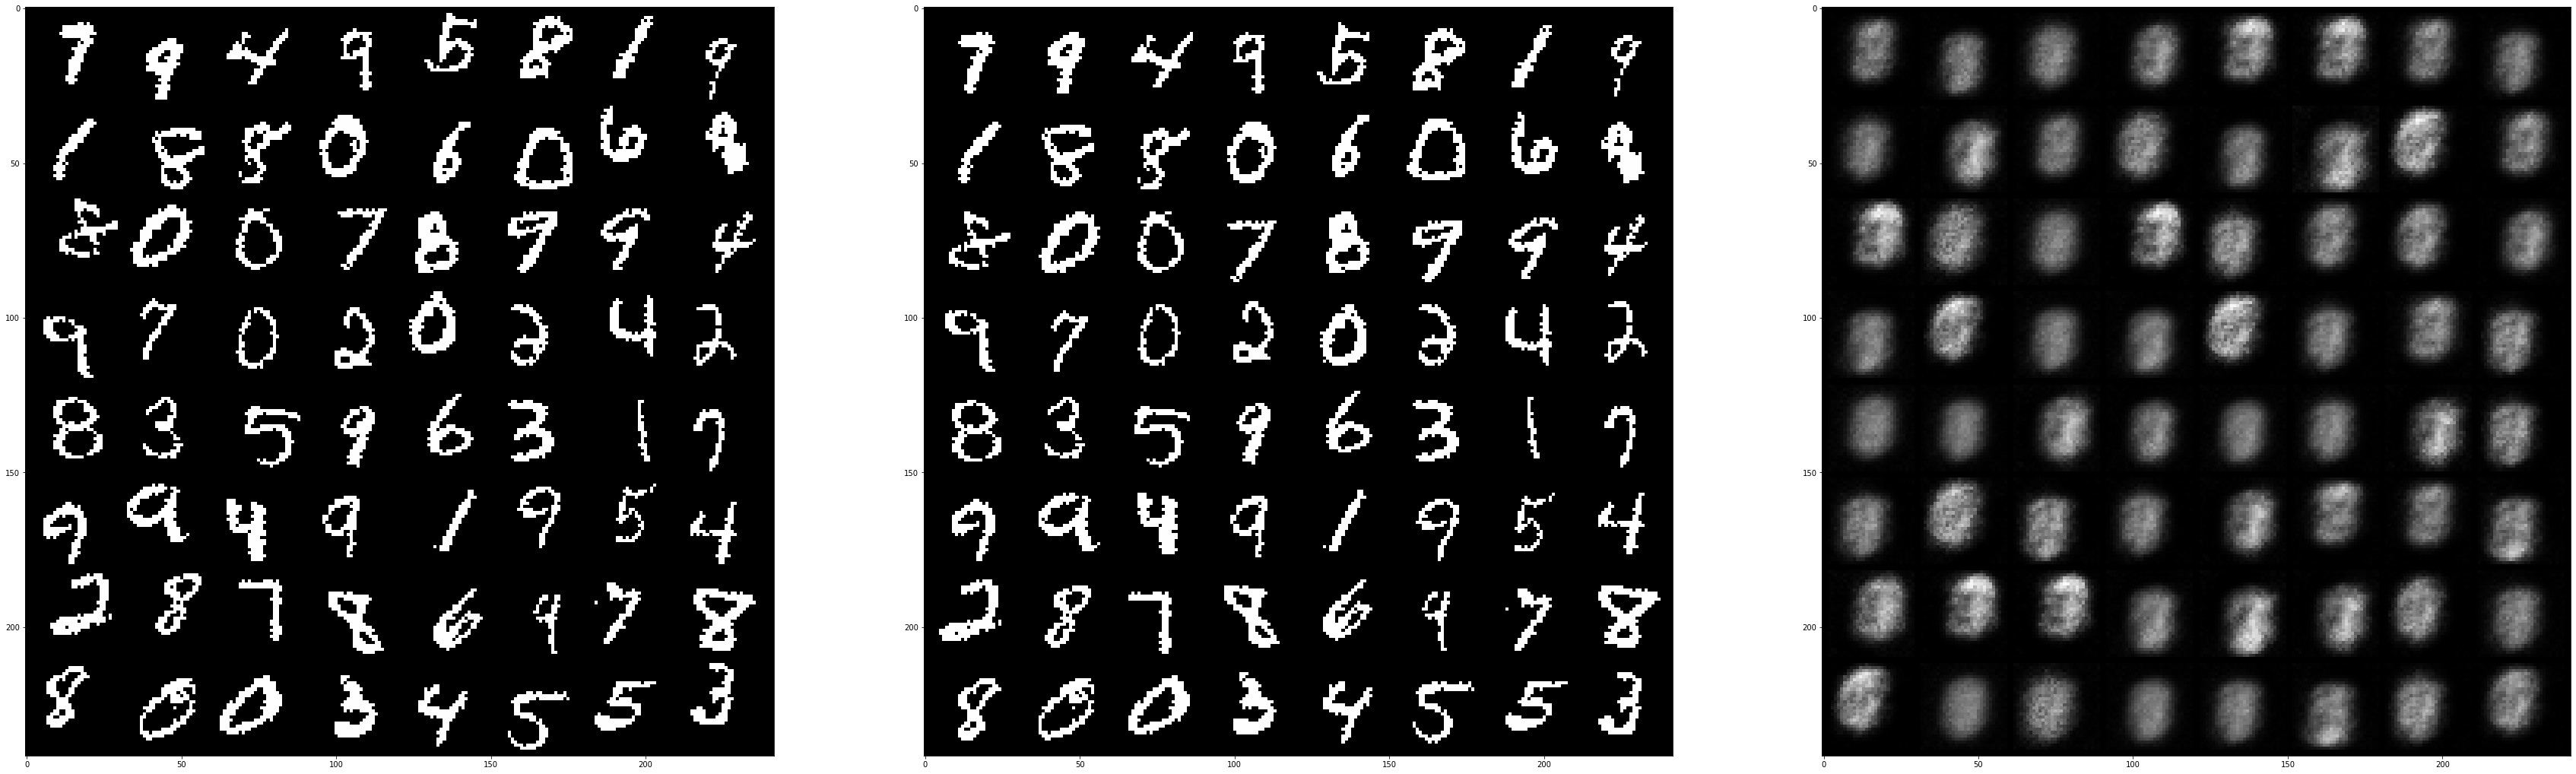

00001, 00101 loss : 0.35333, time: 16.30


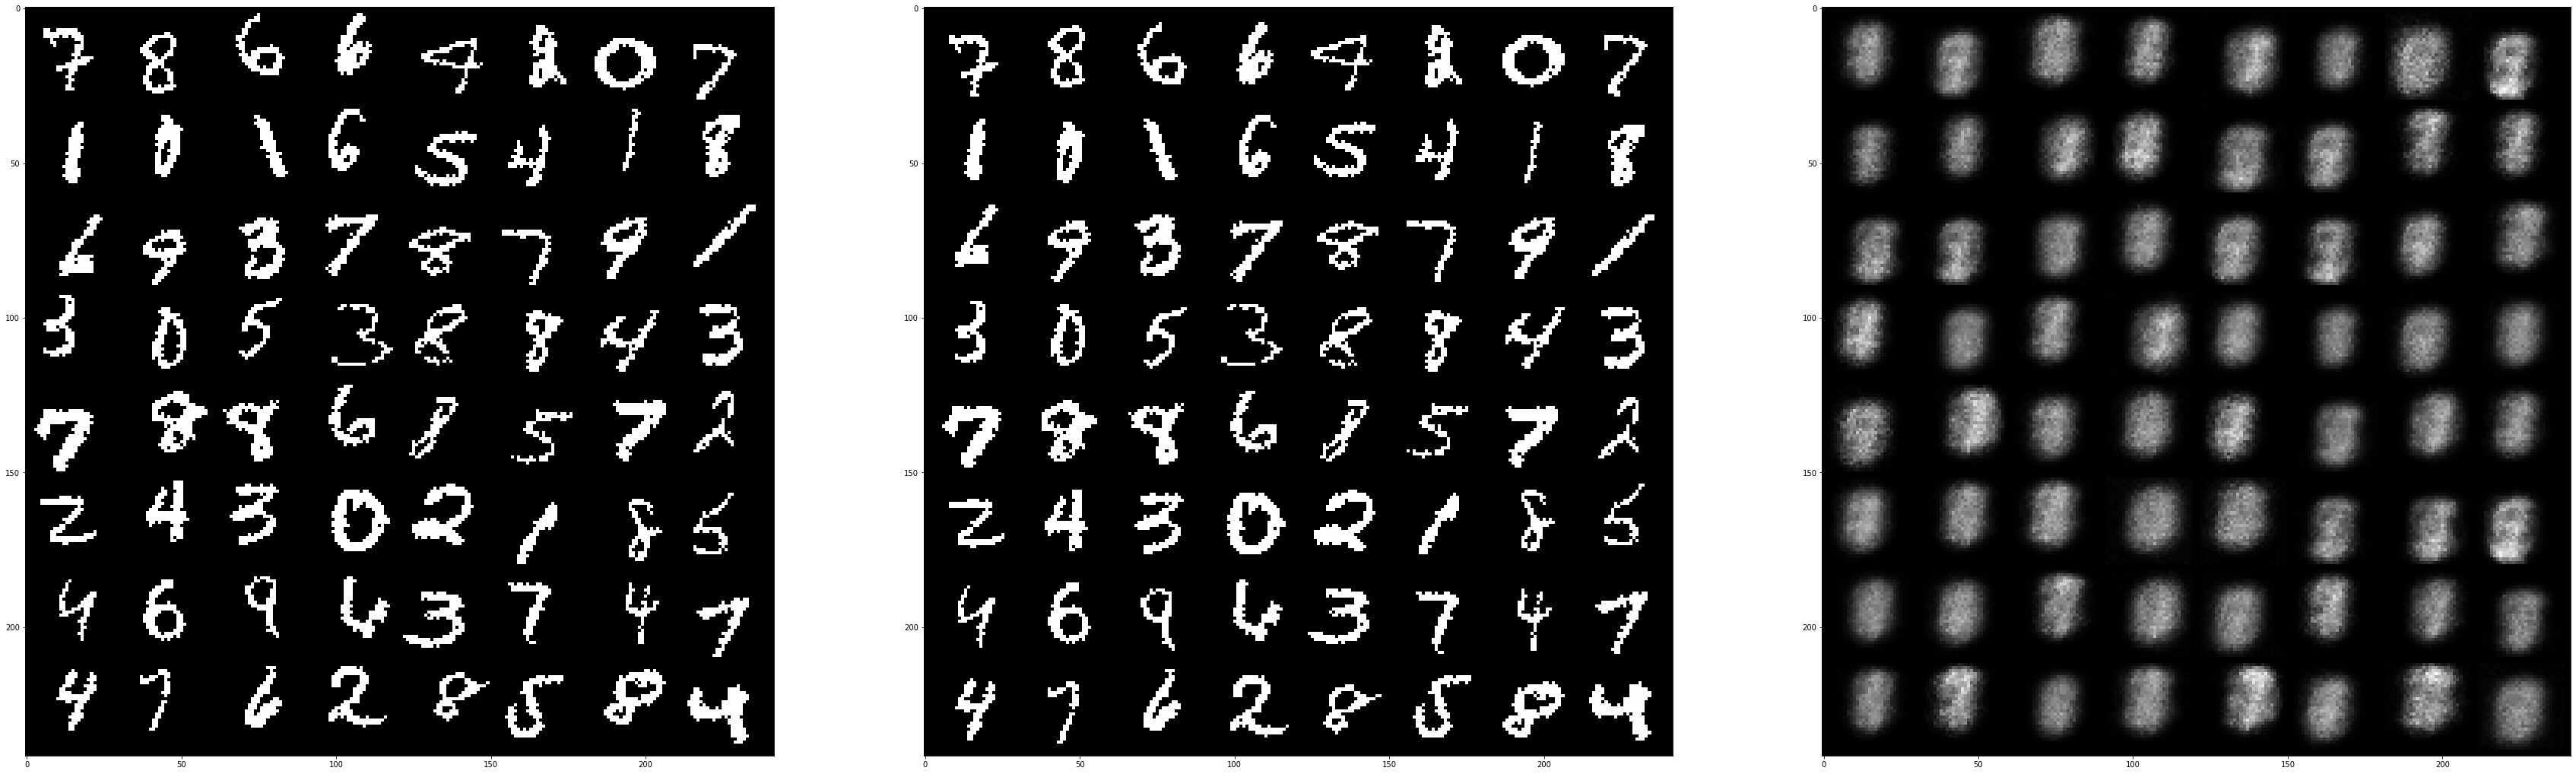

00001, 00201 loss : 0.26330, time: 32.20


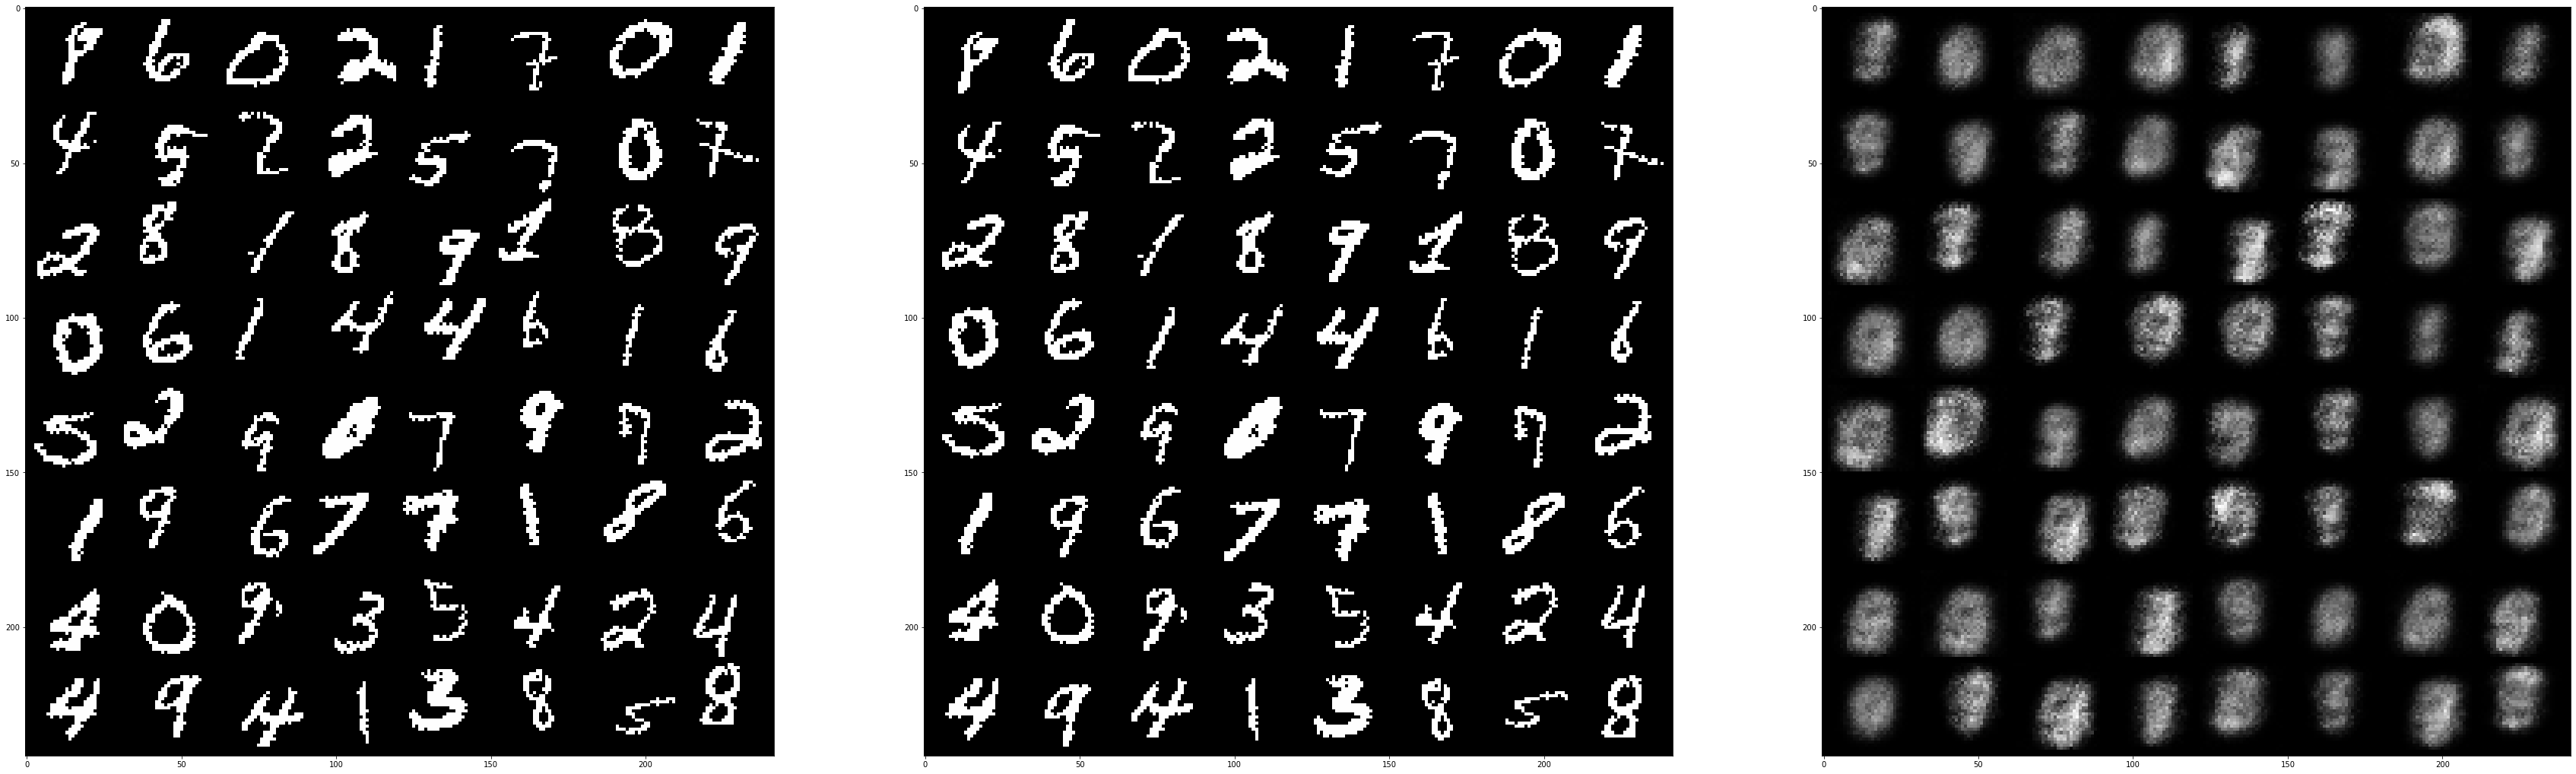

00001, 00301 loss : 0.25241, time: 48.26


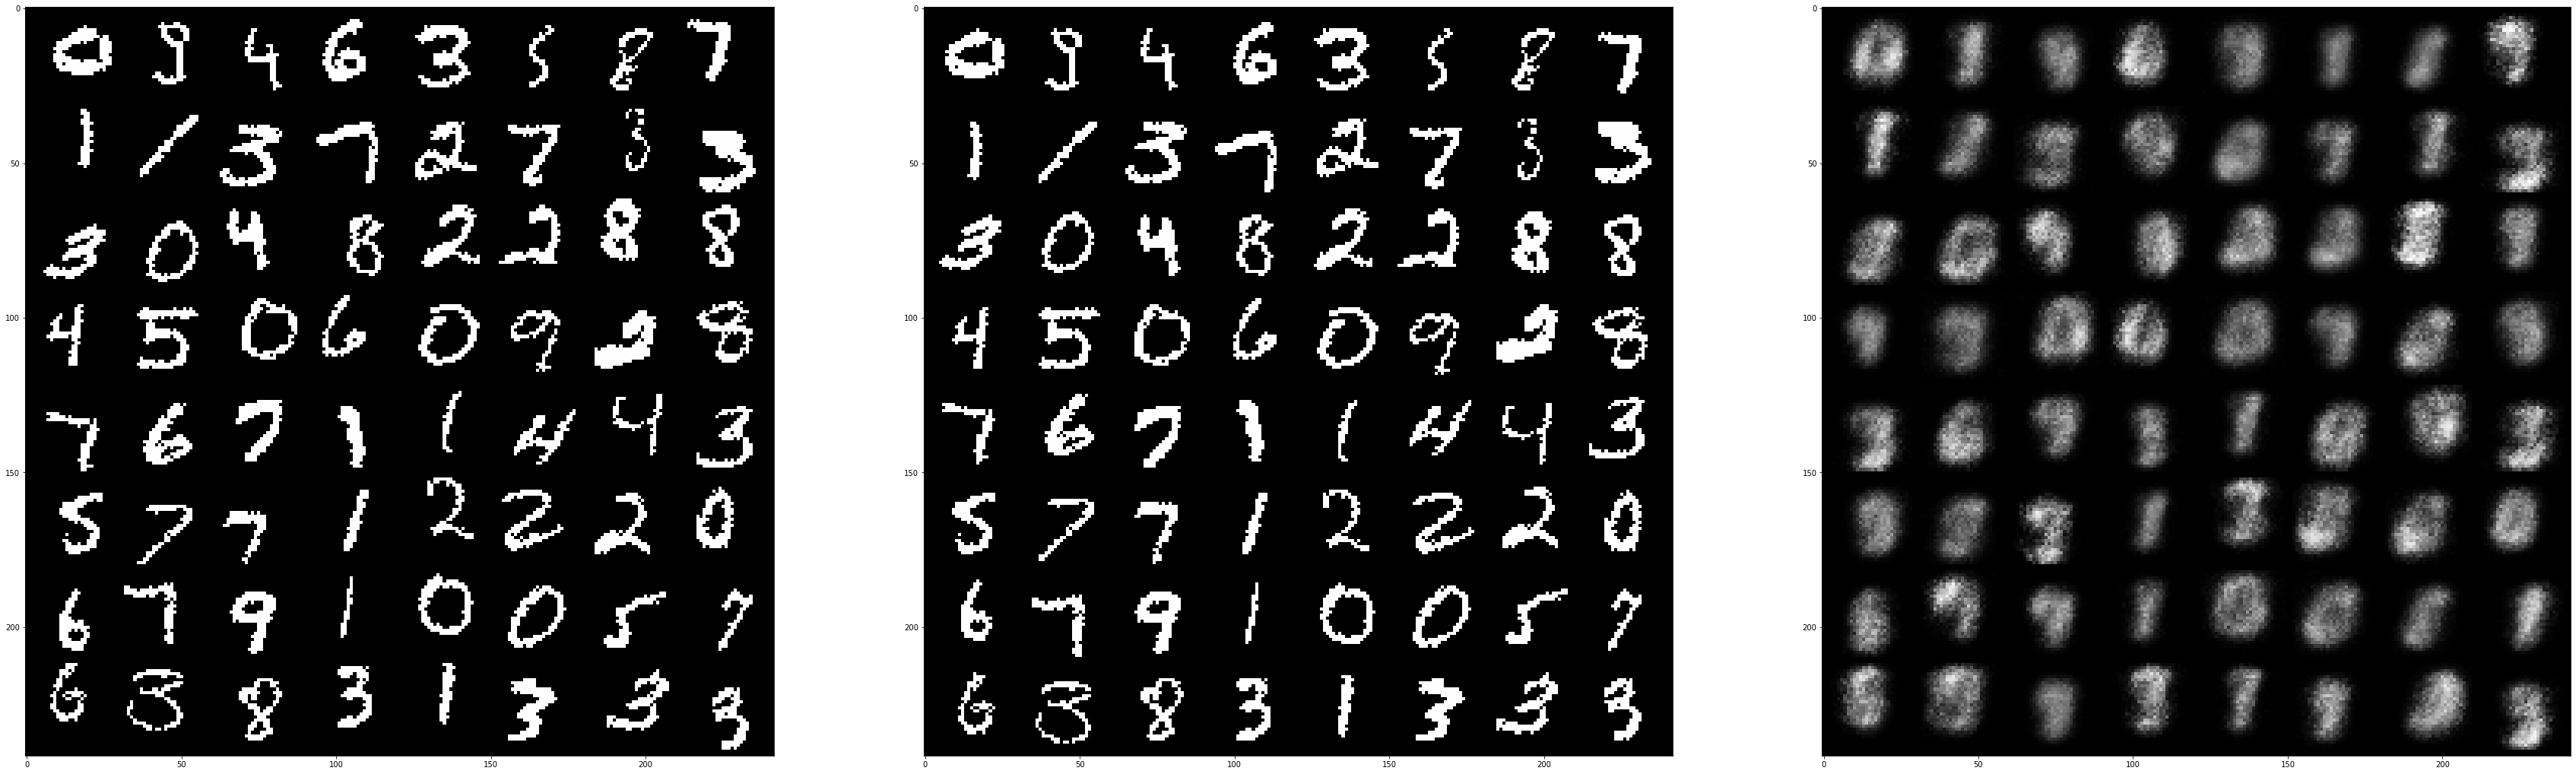

00001, 00401 loss : 0.24126, time: 64.36


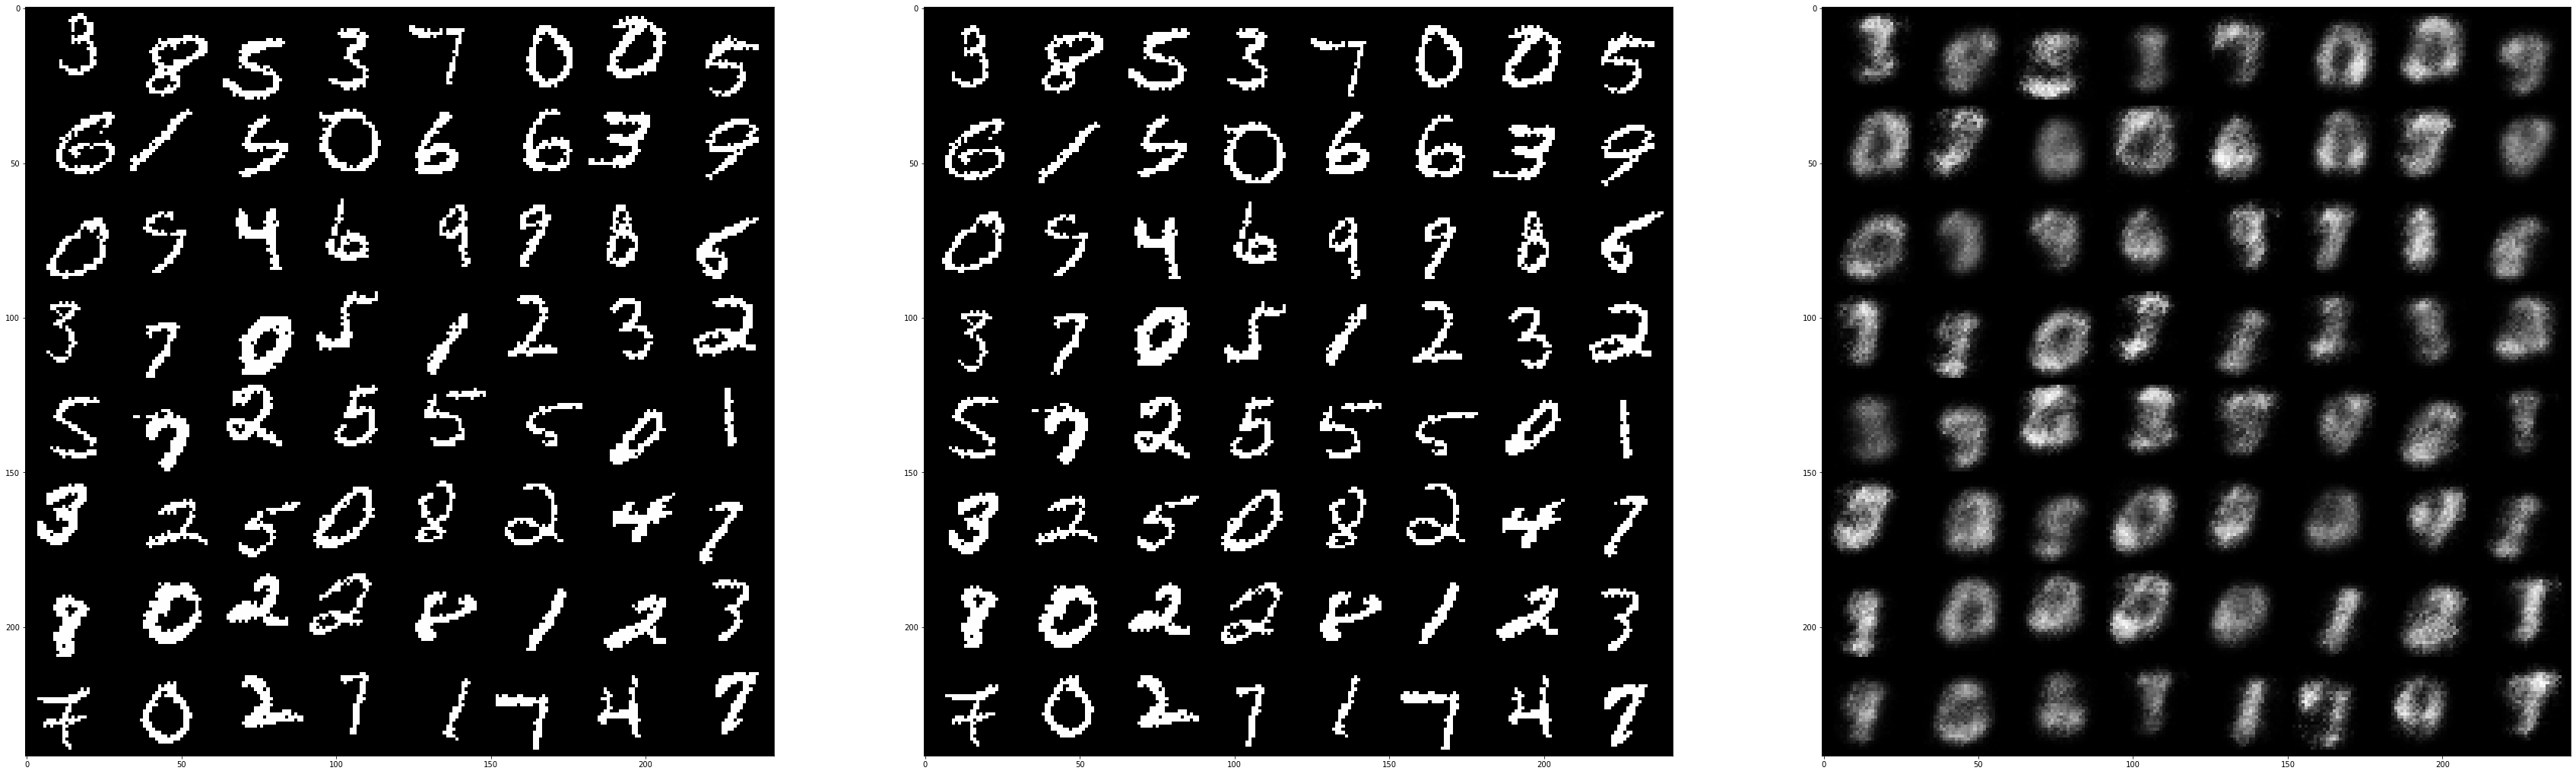

00001, 00501 loss : 0.23139, time: 80.58


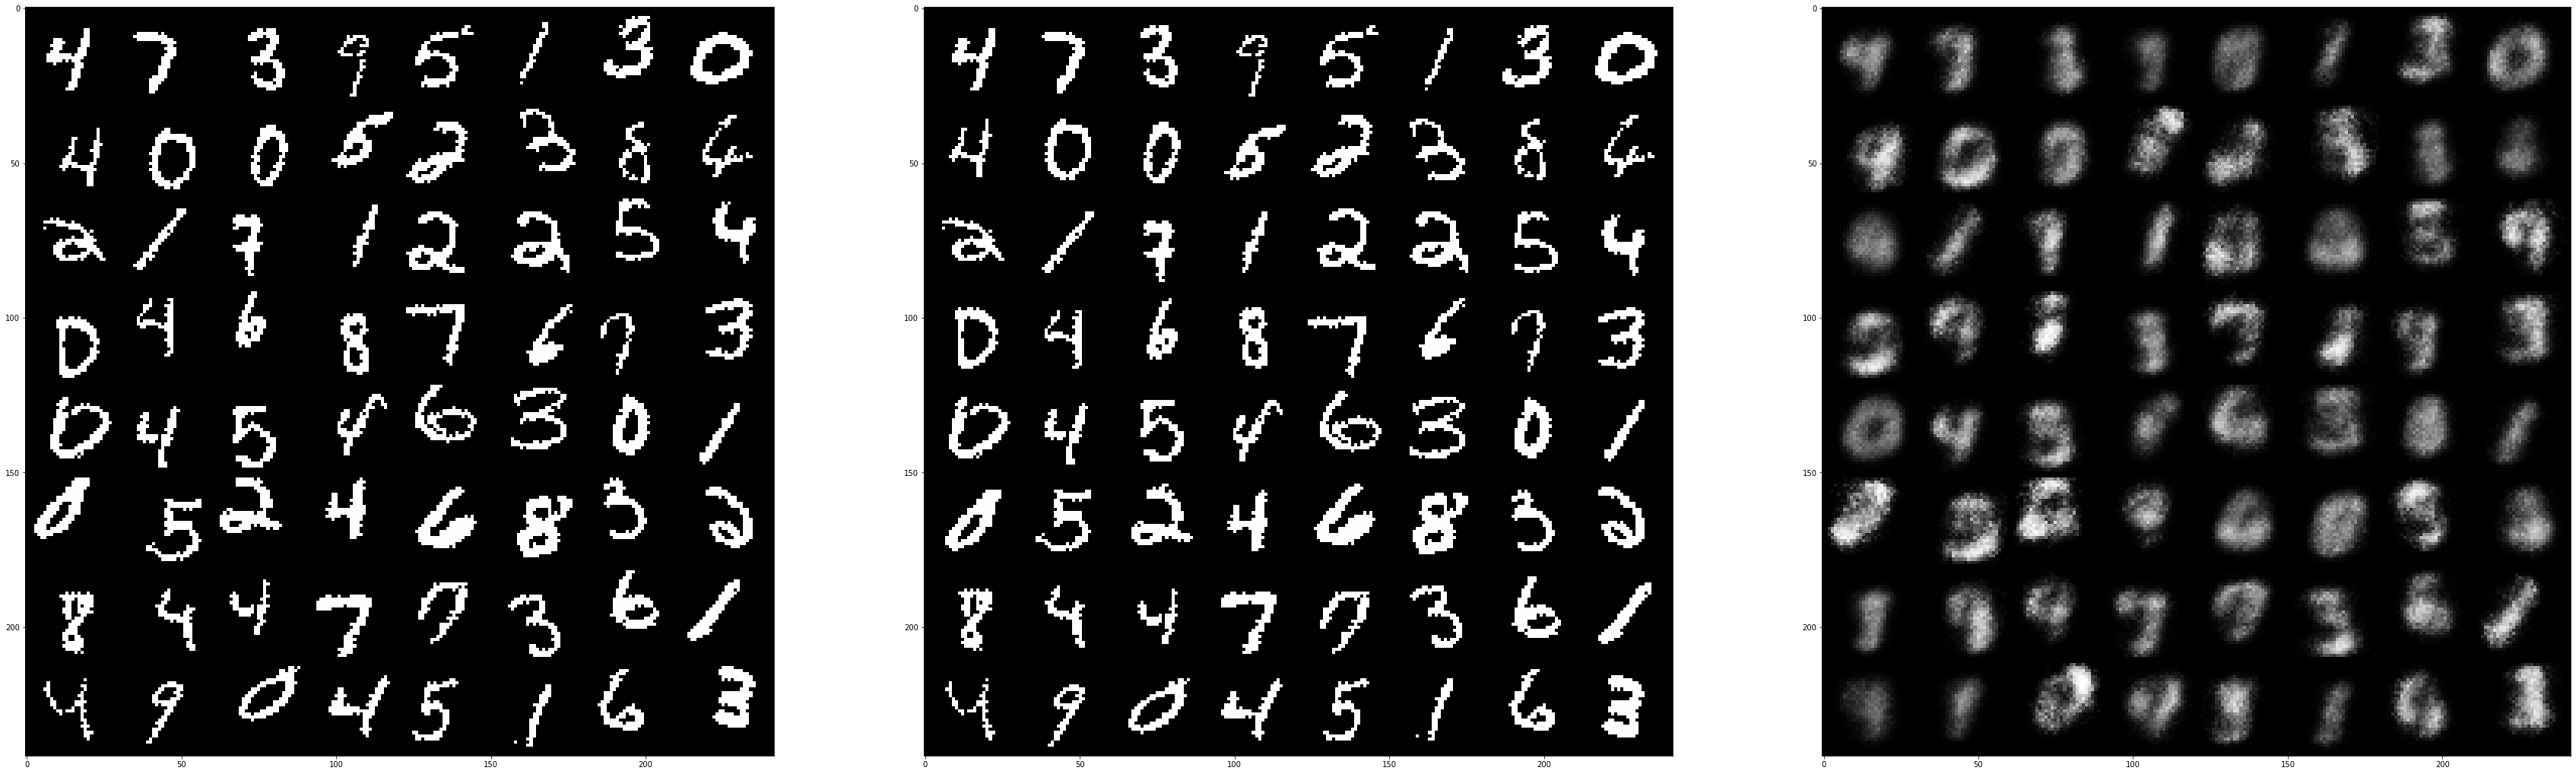

00001, 00601 loss : 0.22081, time: 96.79


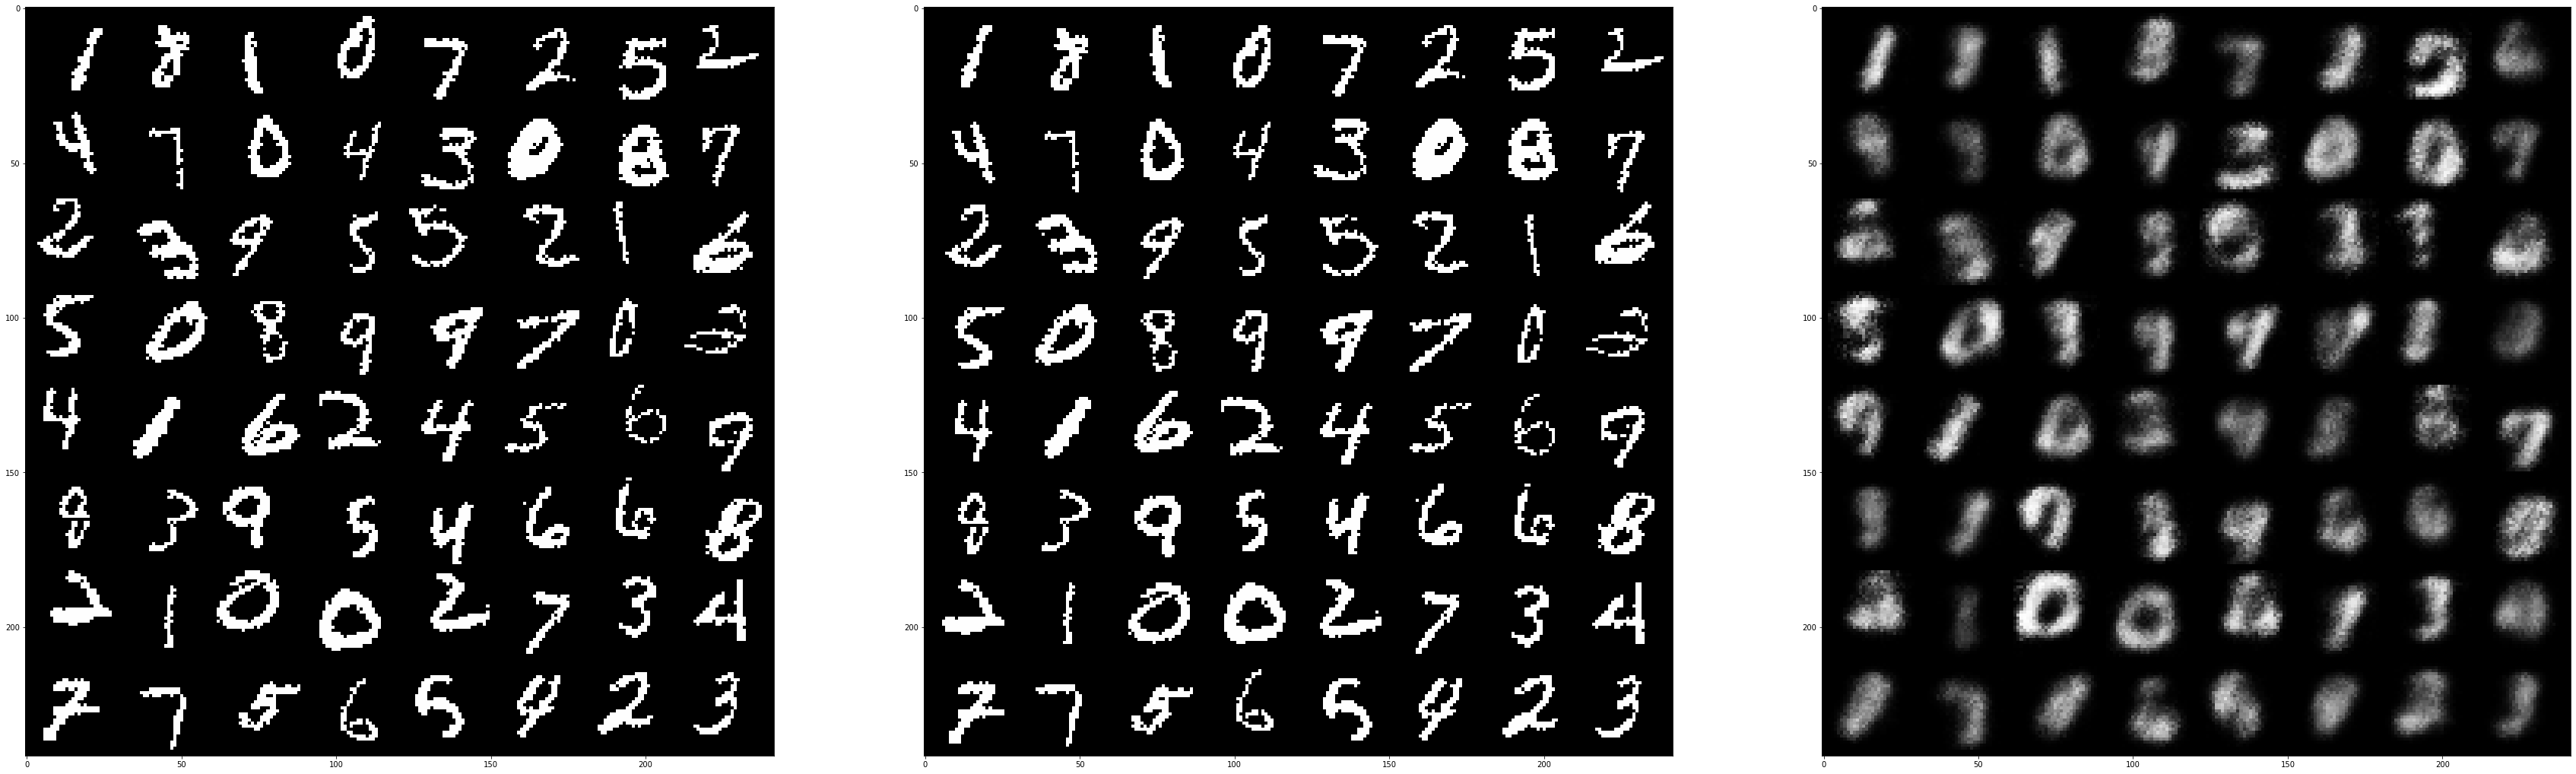

00001, 00701 loss : 0.21457, time: 113.00


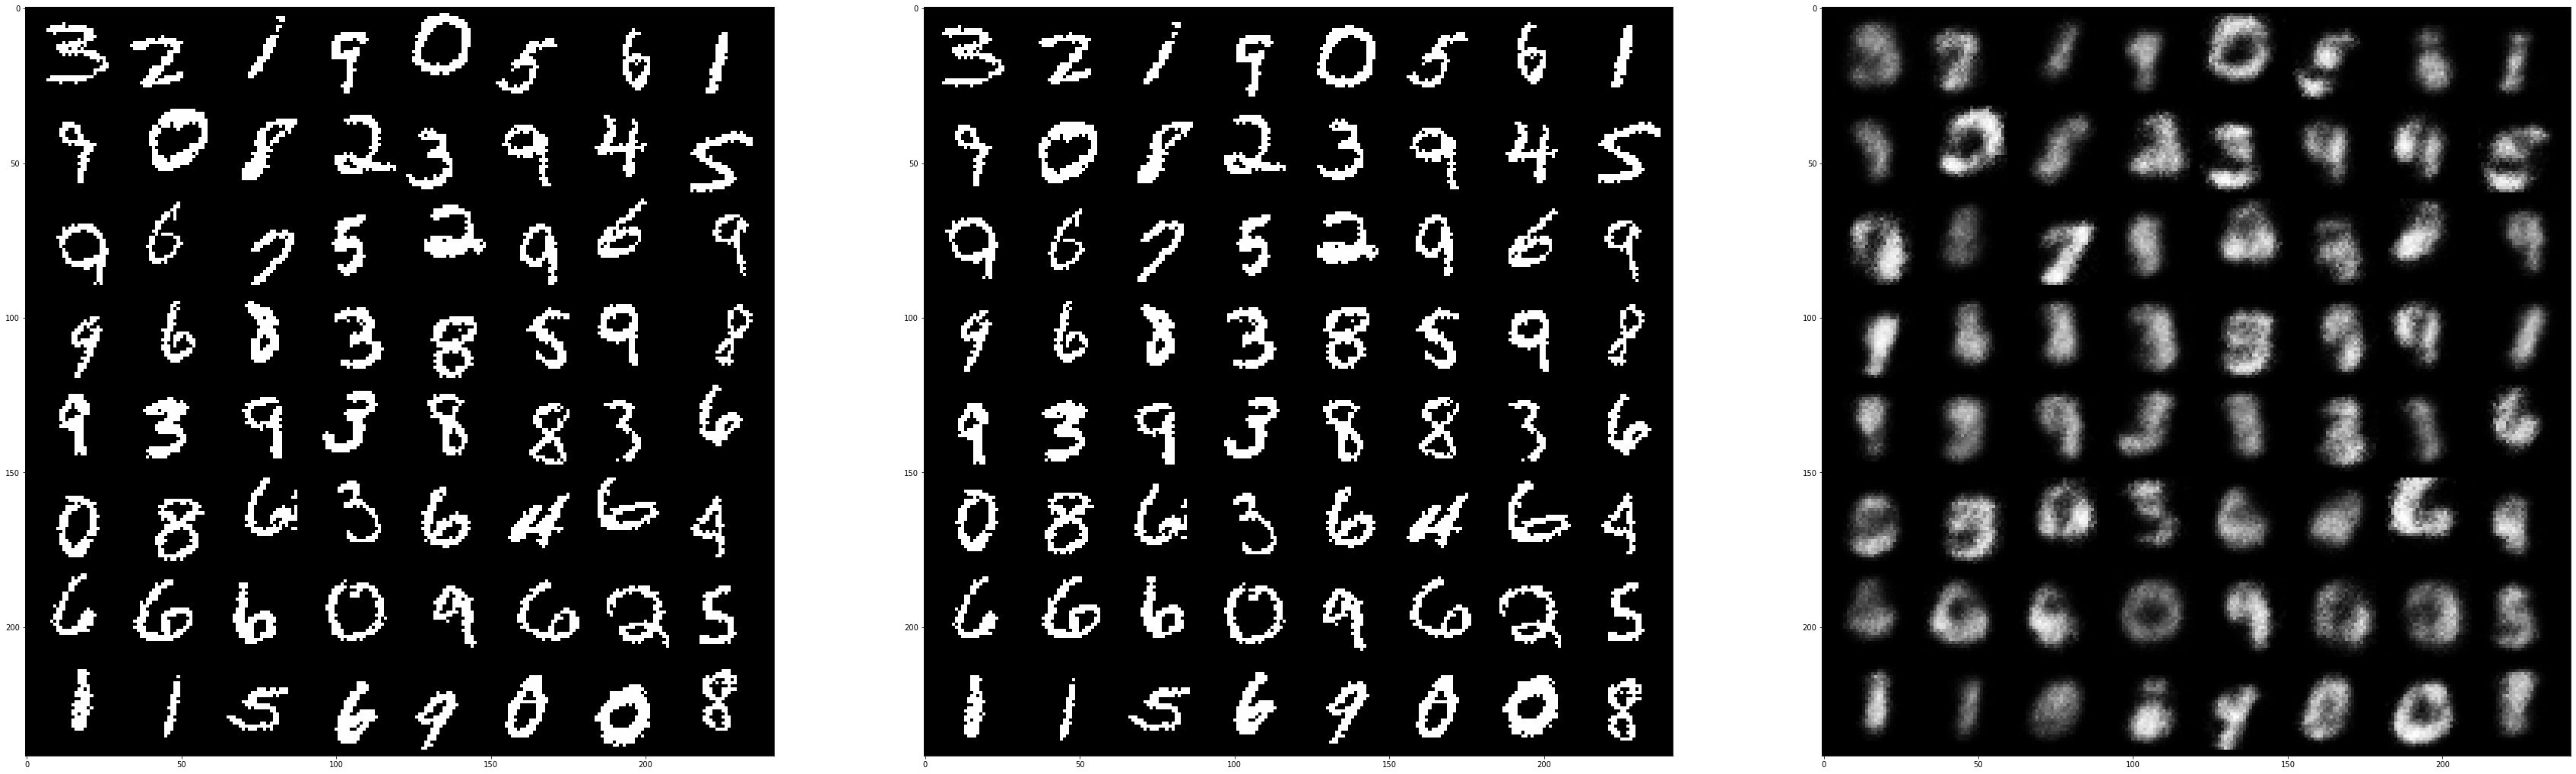

00001, 00801 loss : 0.20948, time: 129.22


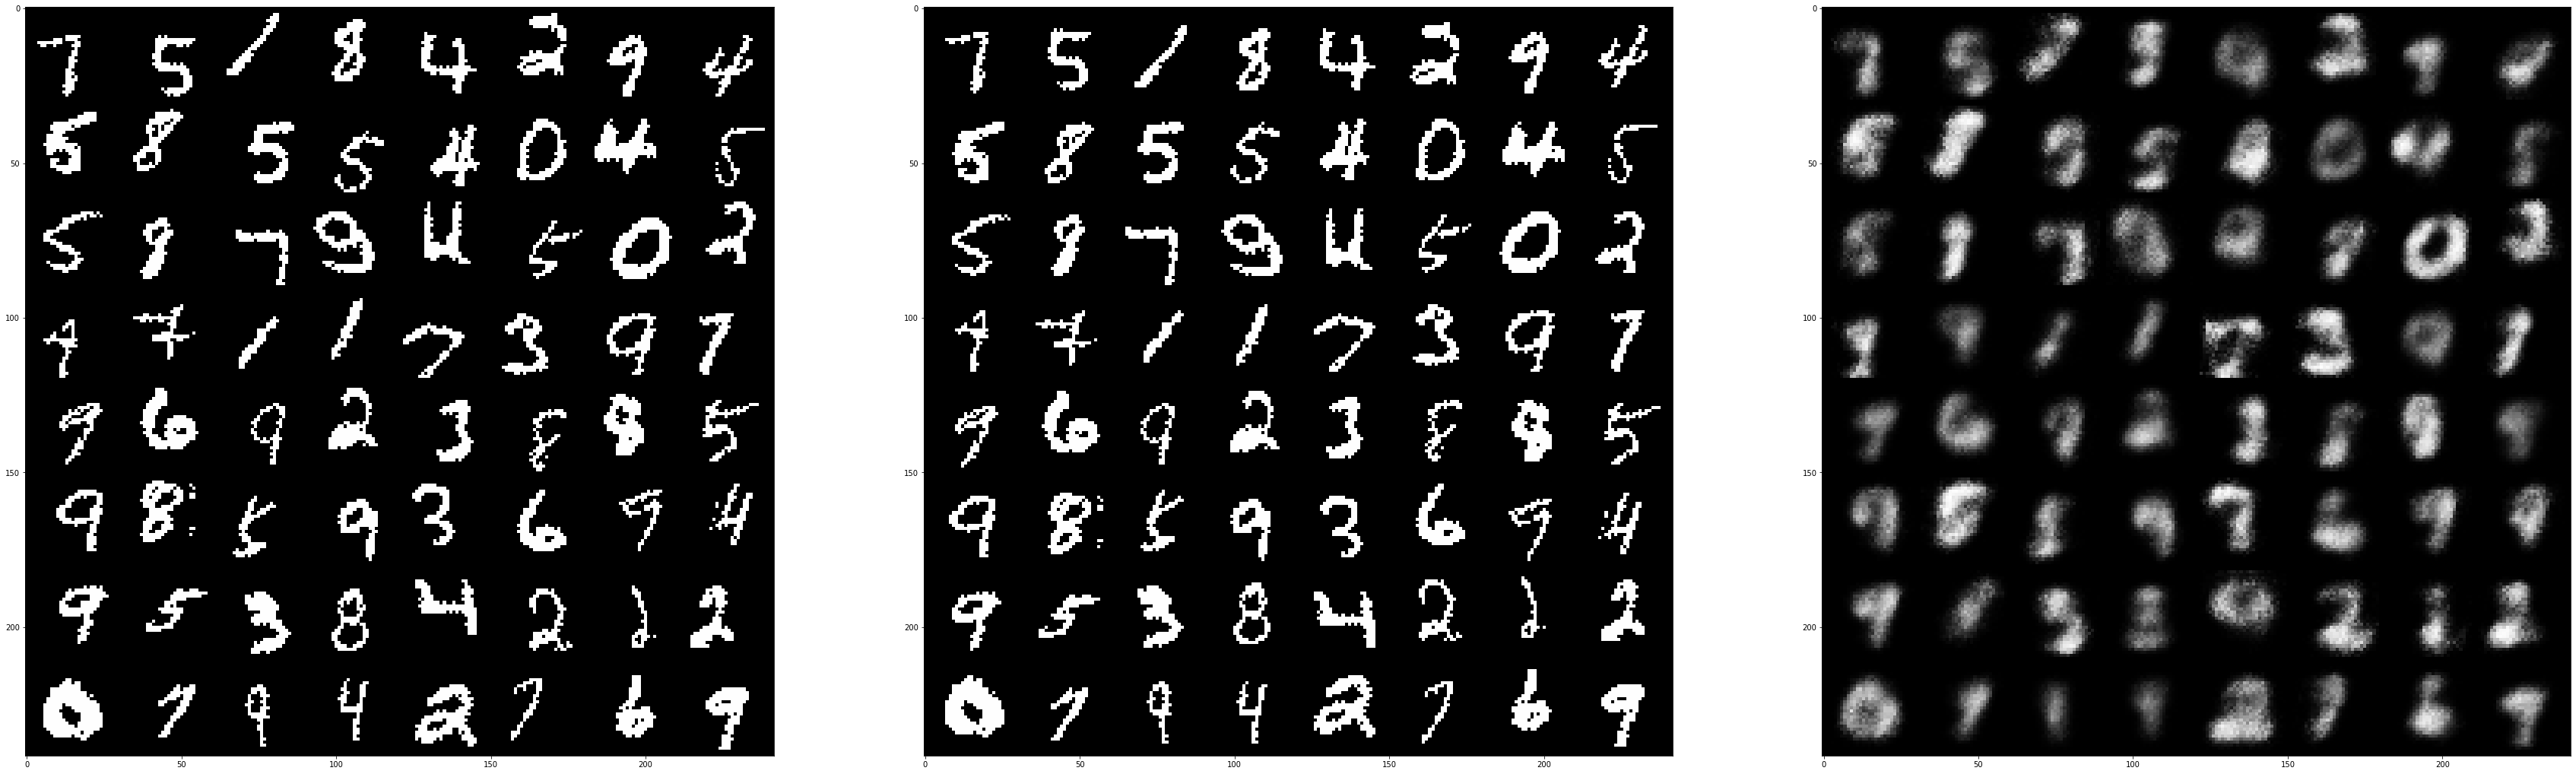

00001, 00901 loss : 0.20508, time: 145.39


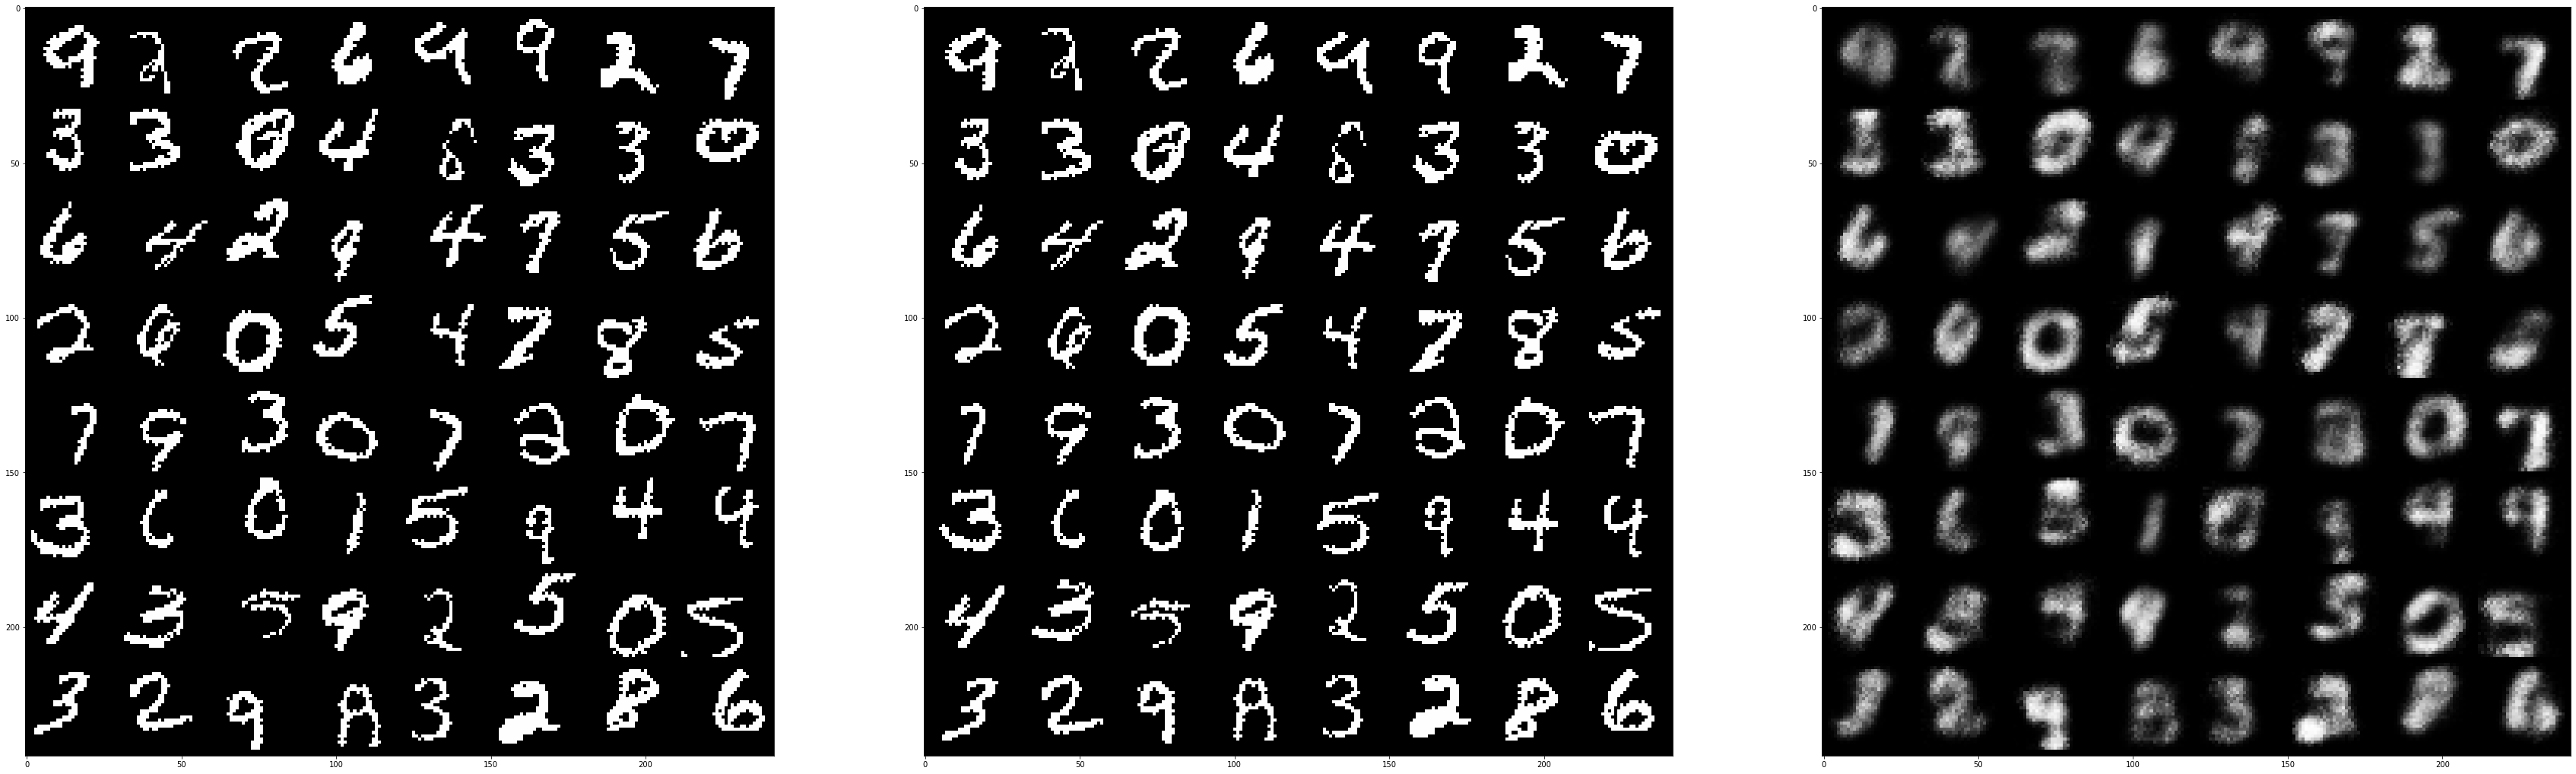

00002, 00101 loss : 0.20057, time: 167.52


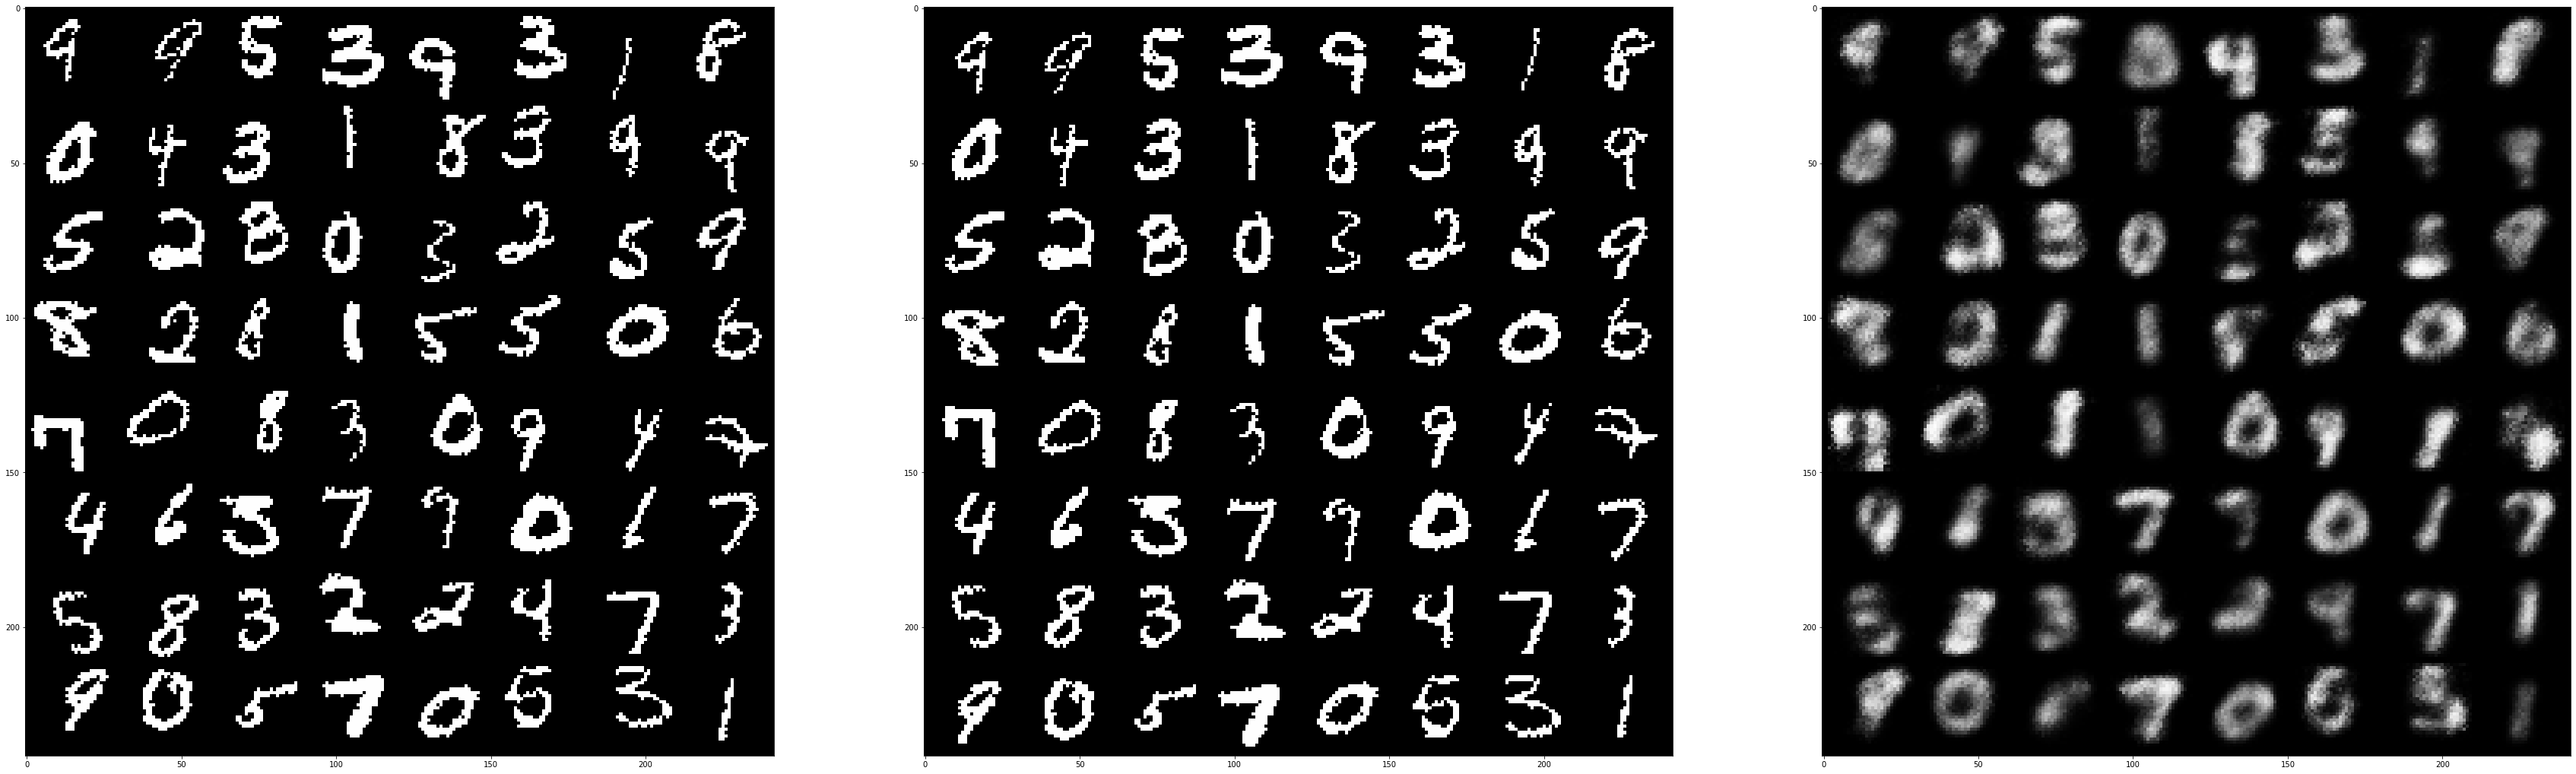

00002, 00201 loss : 0.19705, time: 183.71


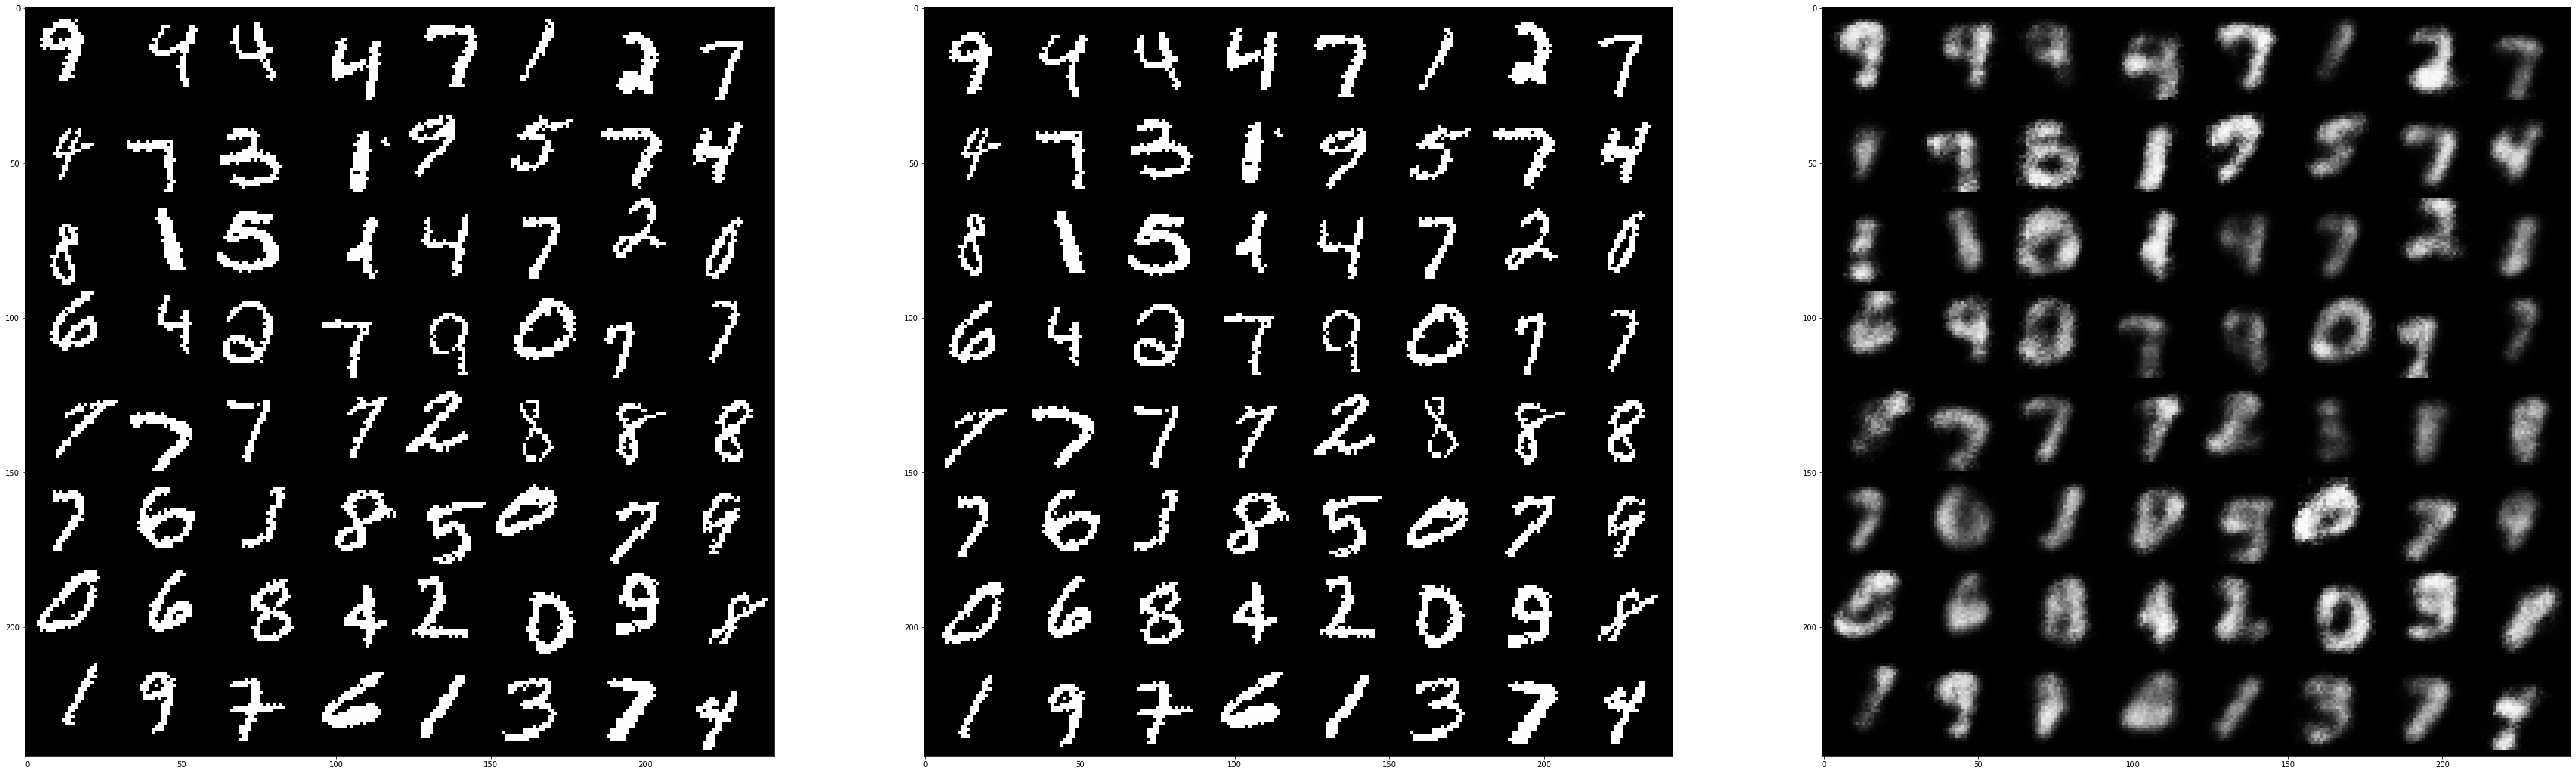

00002, 00301 loss : 0.19716, time: 199.89


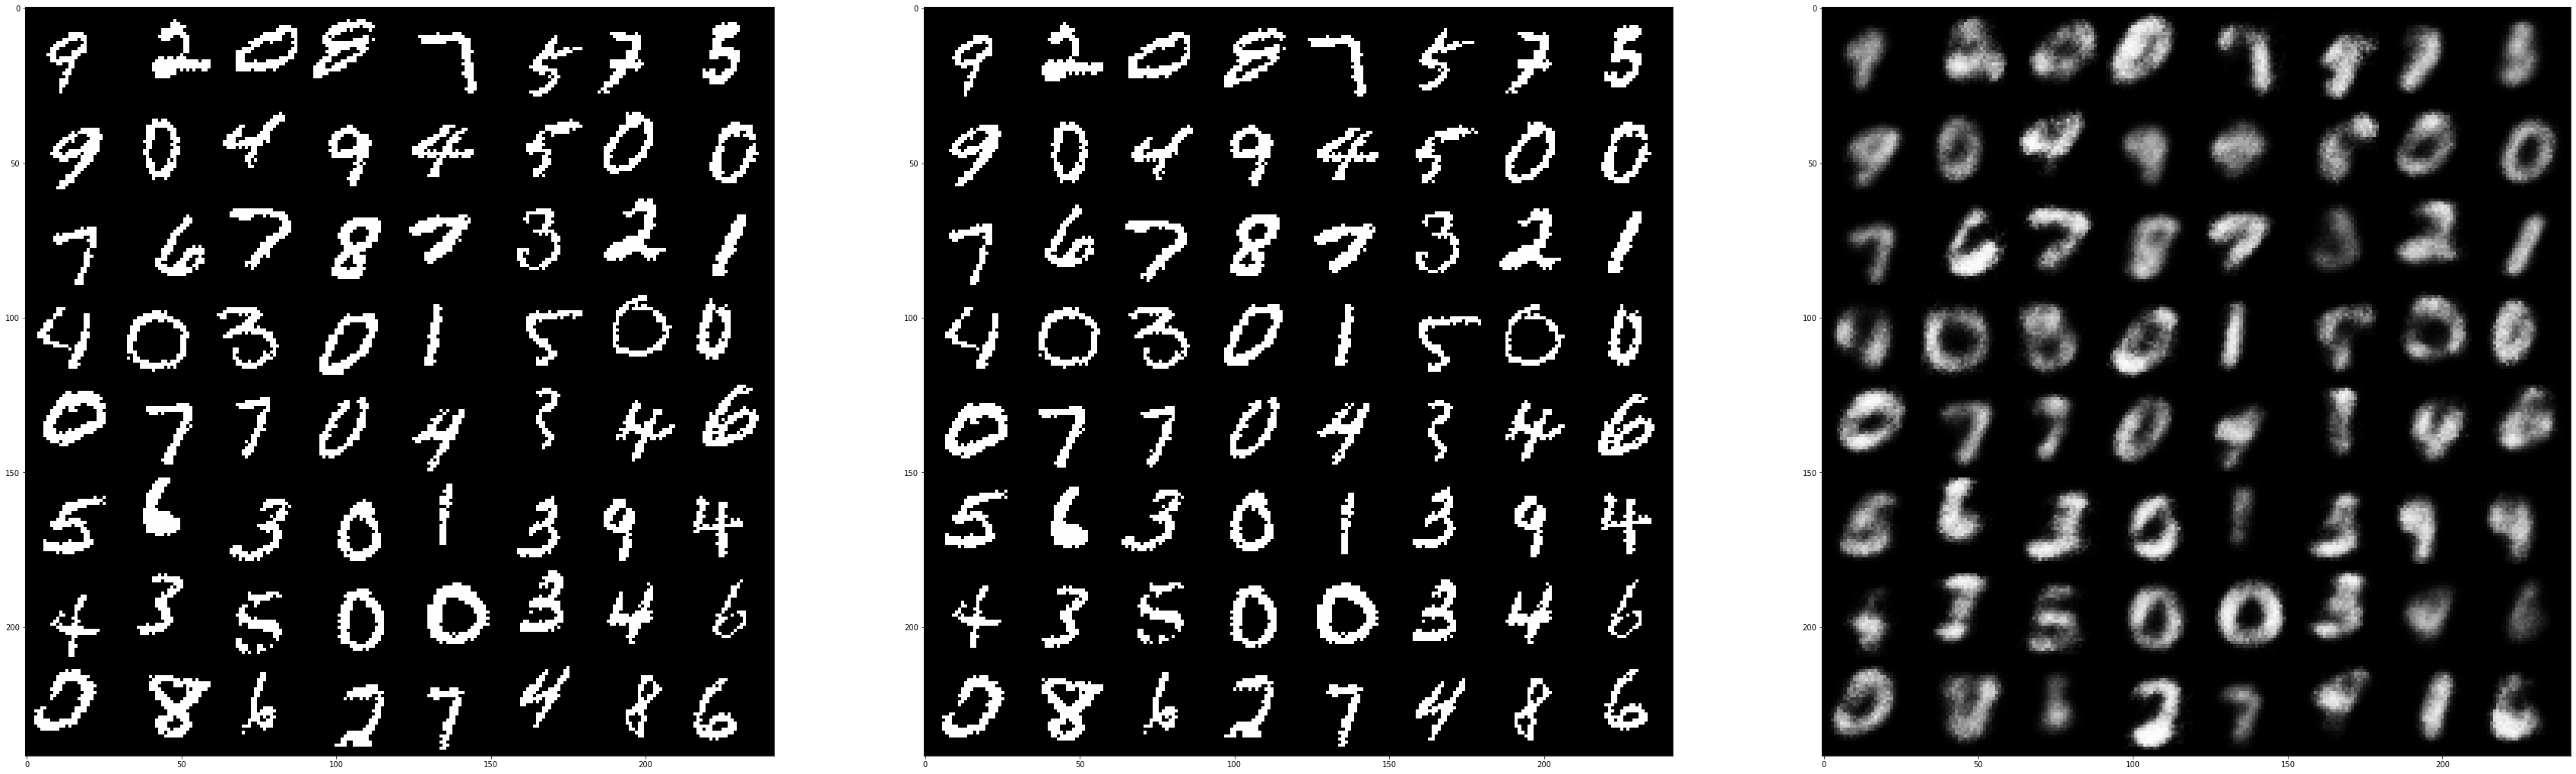

00002, 00401 loss : 0.19569, time: 216.05


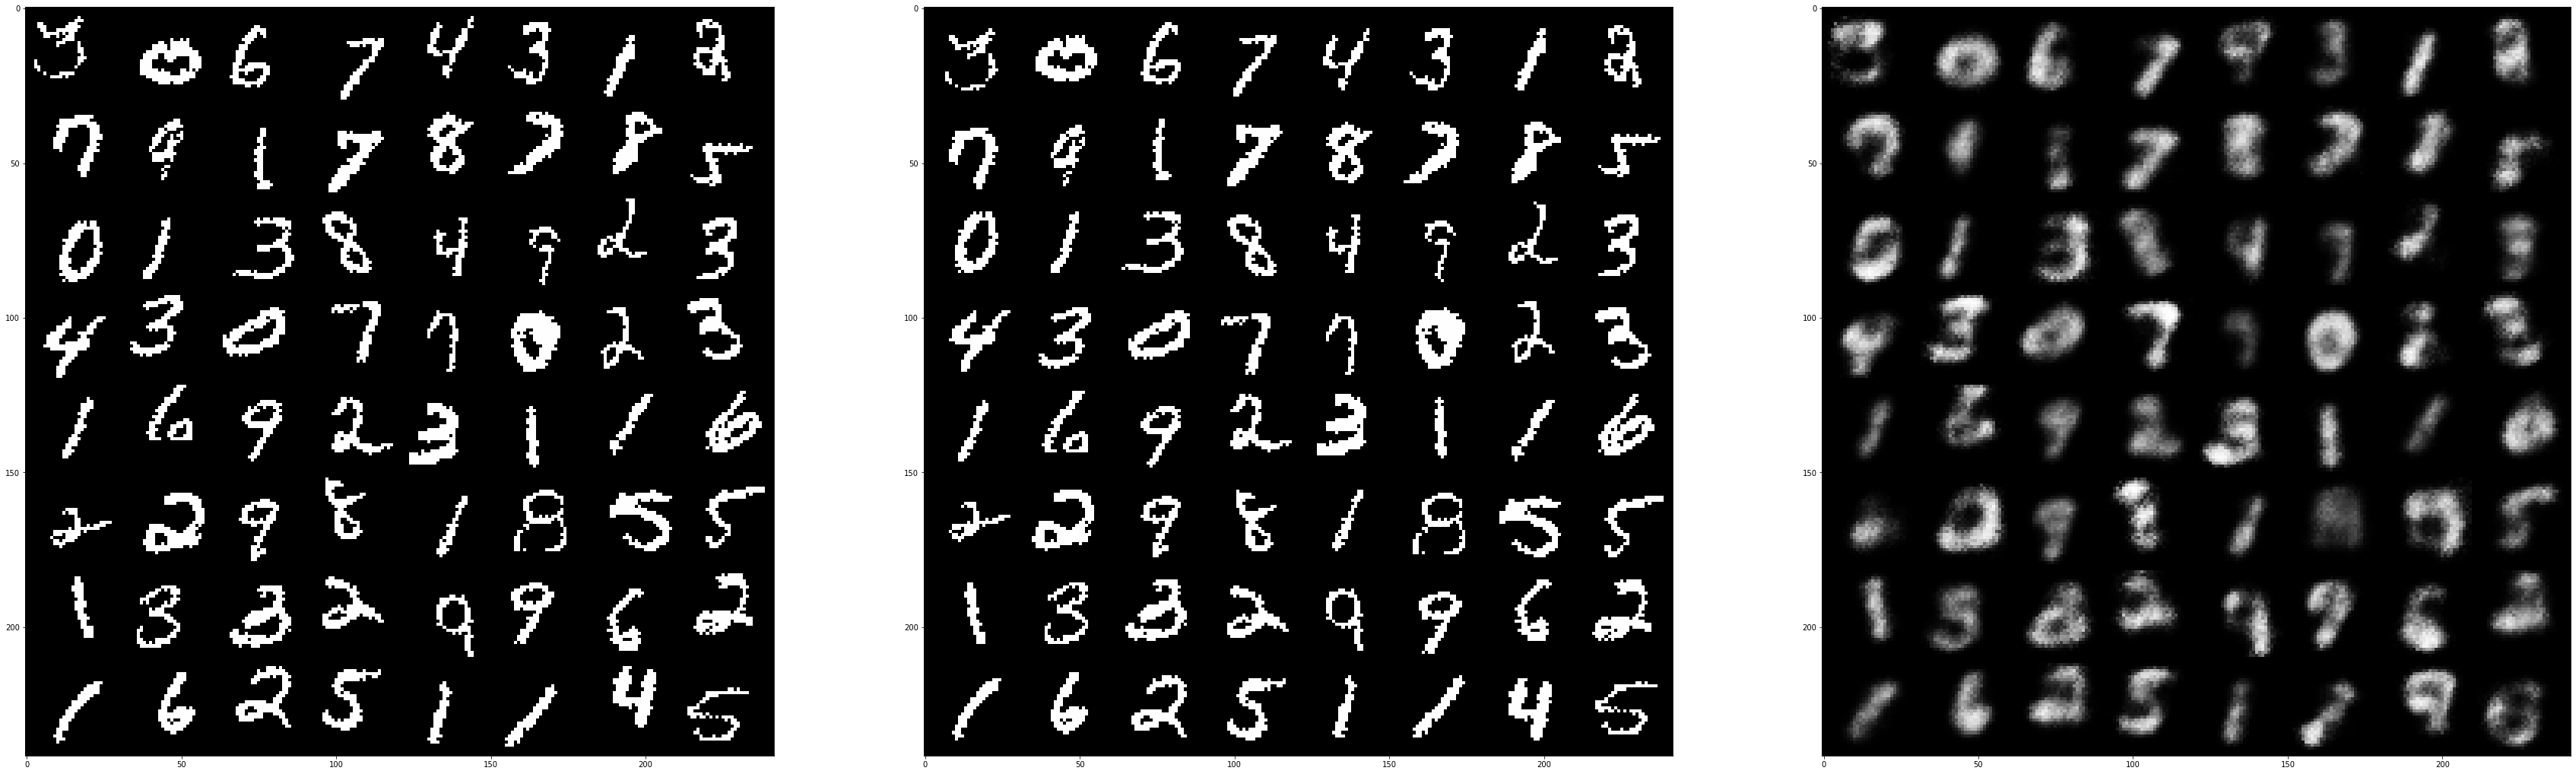

00002, 00501 loss : 0.19284, time: 232.24


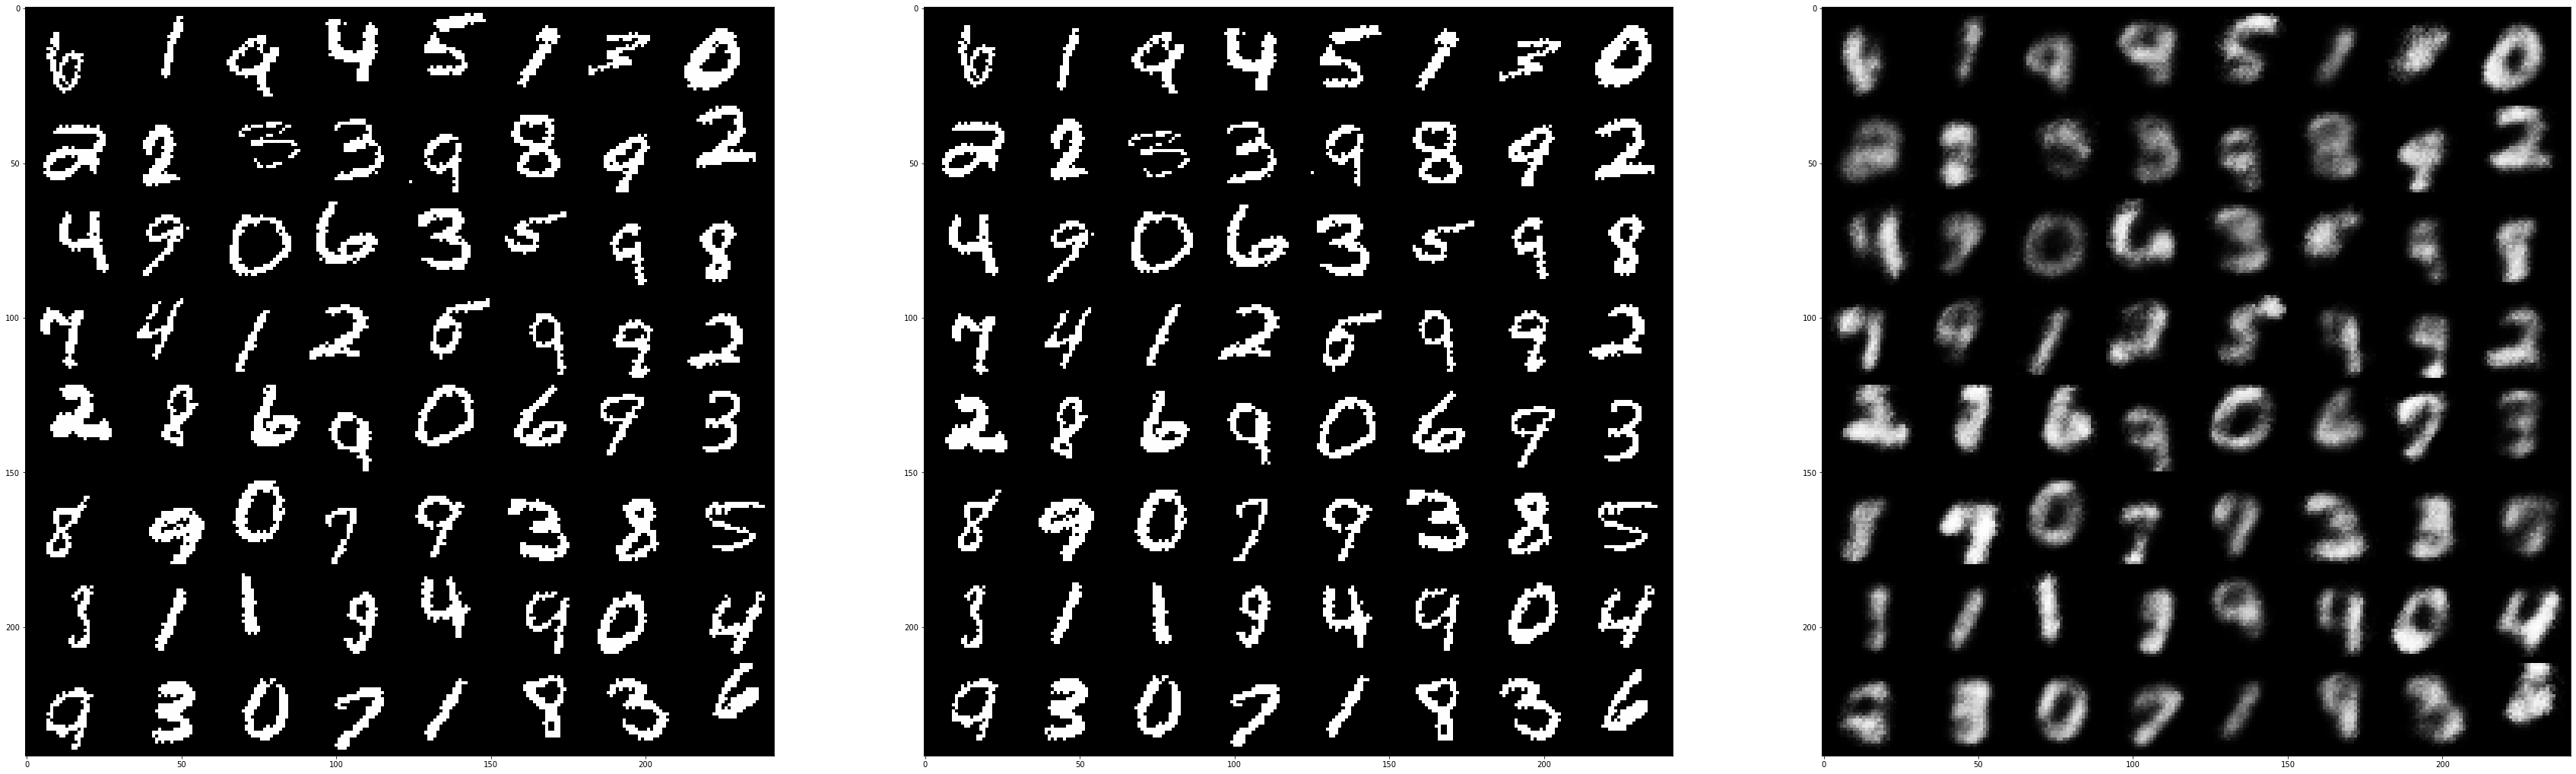

00002, 00601 loss : 0.19246, time: 248.74


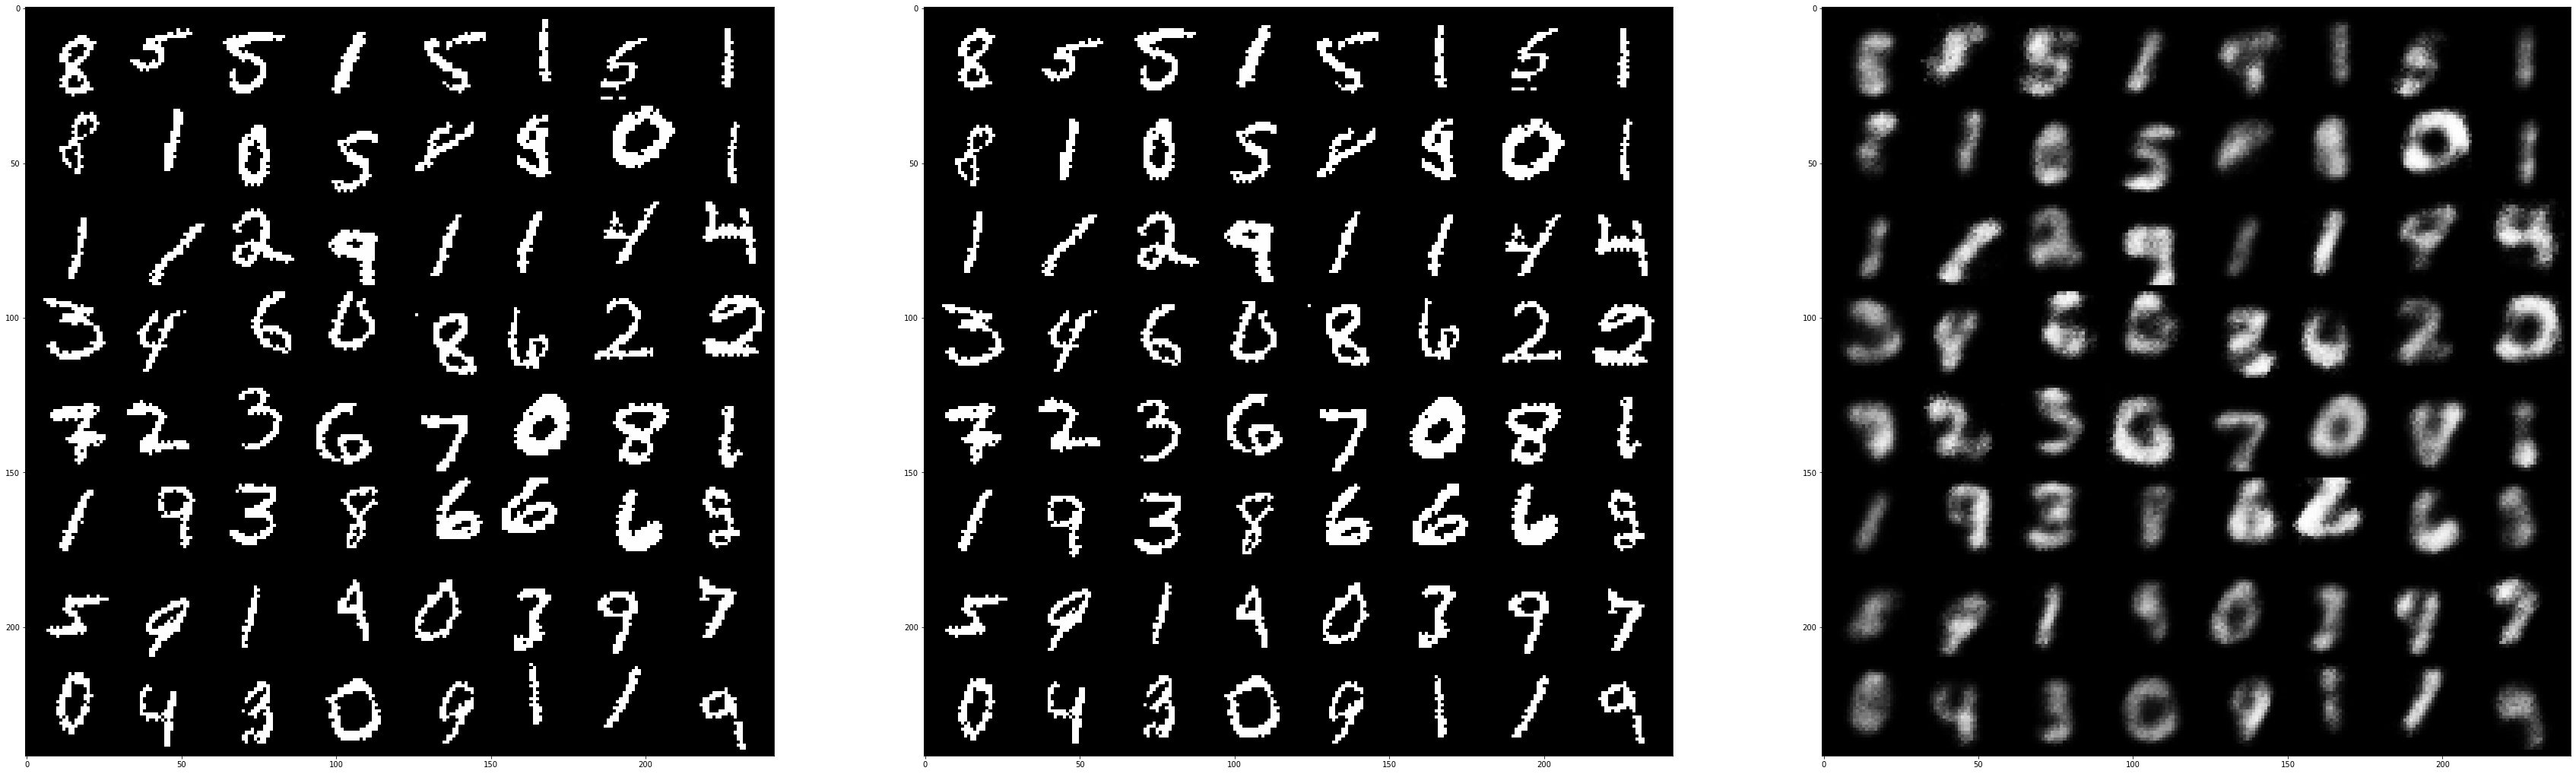

00002, 00701 loss : 0.19111, time: 264.89


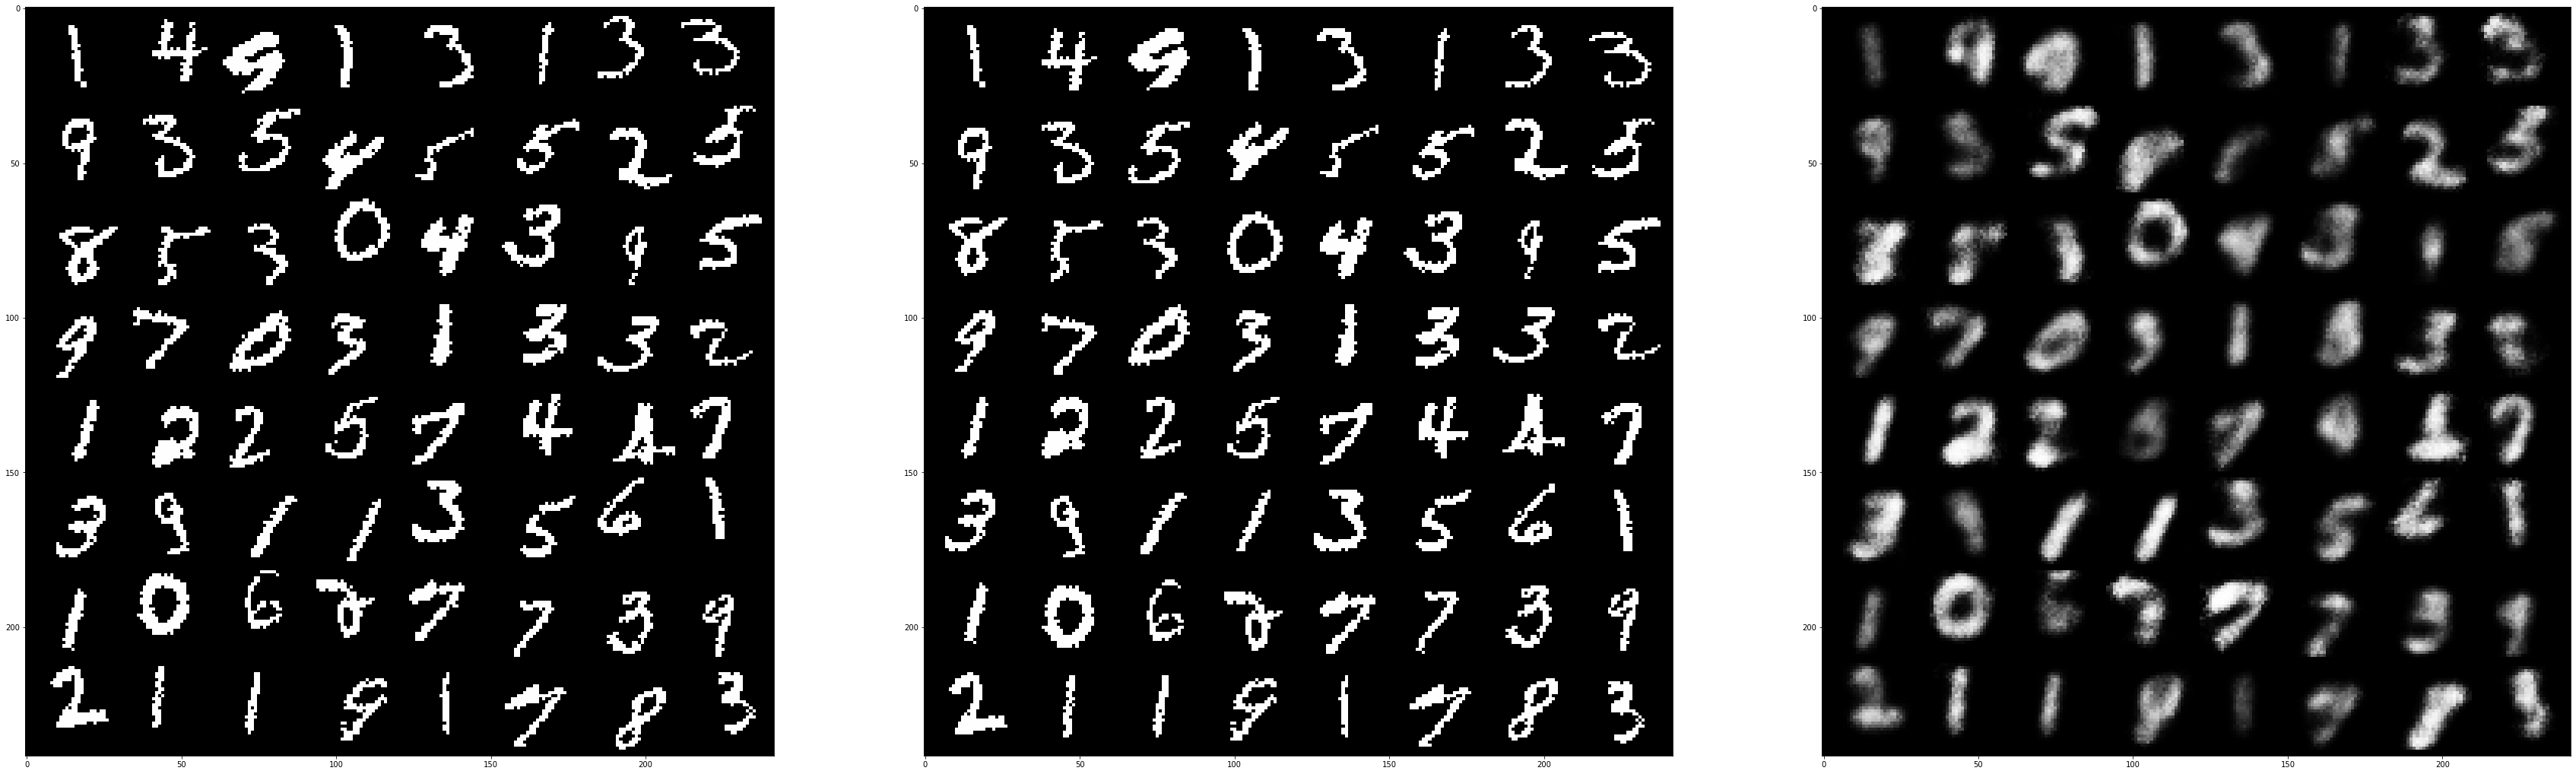

00002, 00801 loss : 0.18982, time: 281.06


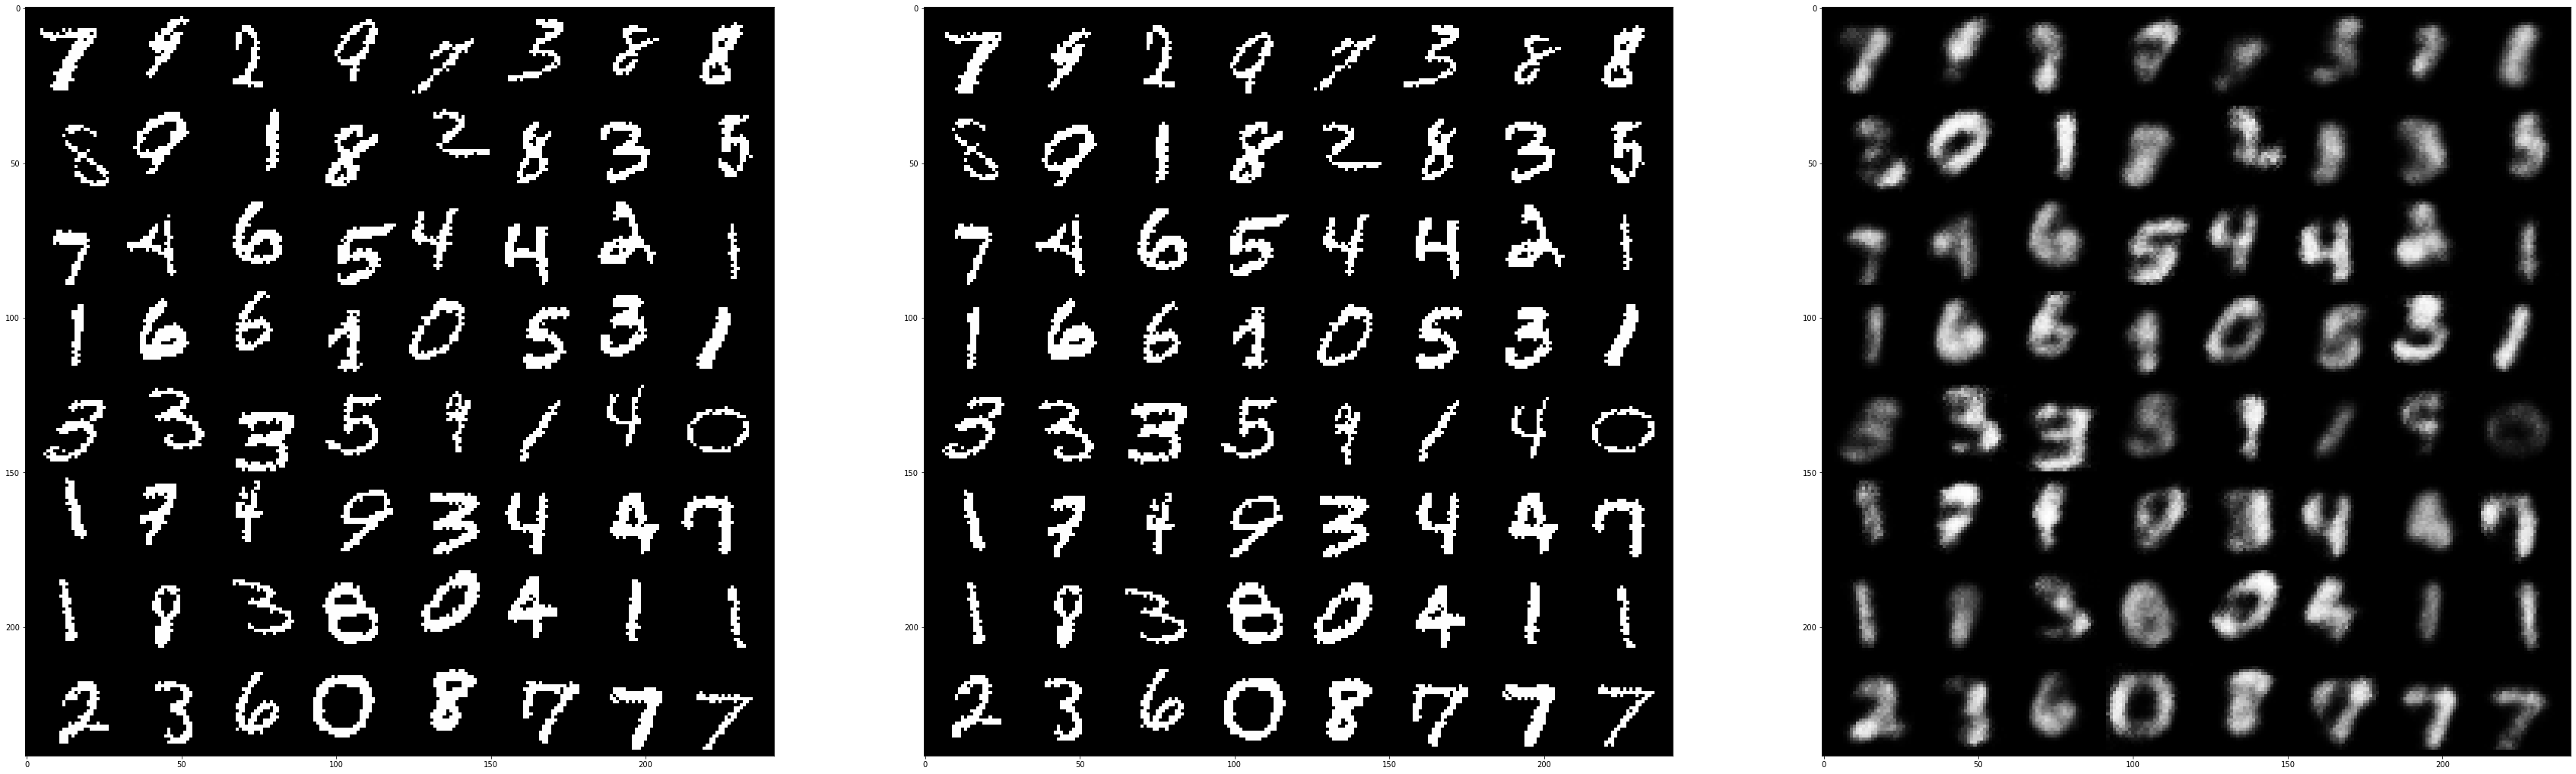

00002, 00901 loss : 0.18983, time: 297.21


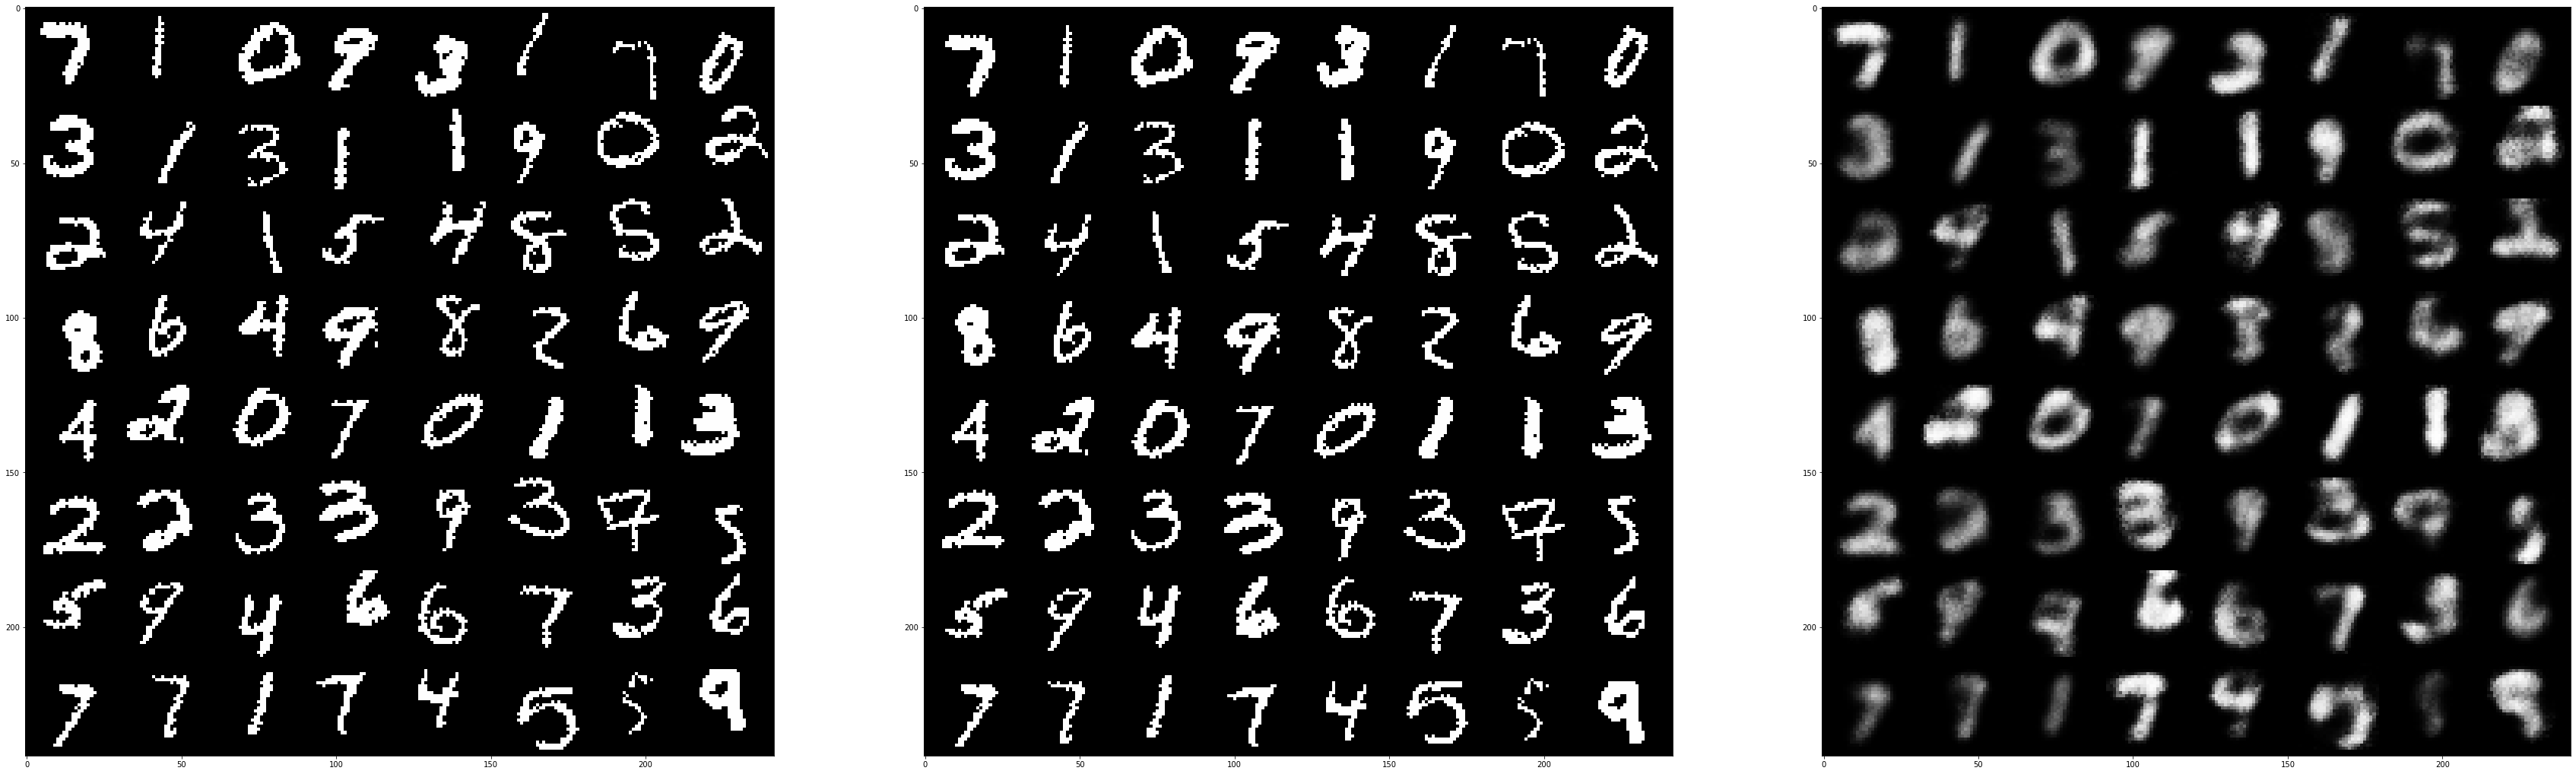

00003, 00101 loss : 0.18837, time: 319.05


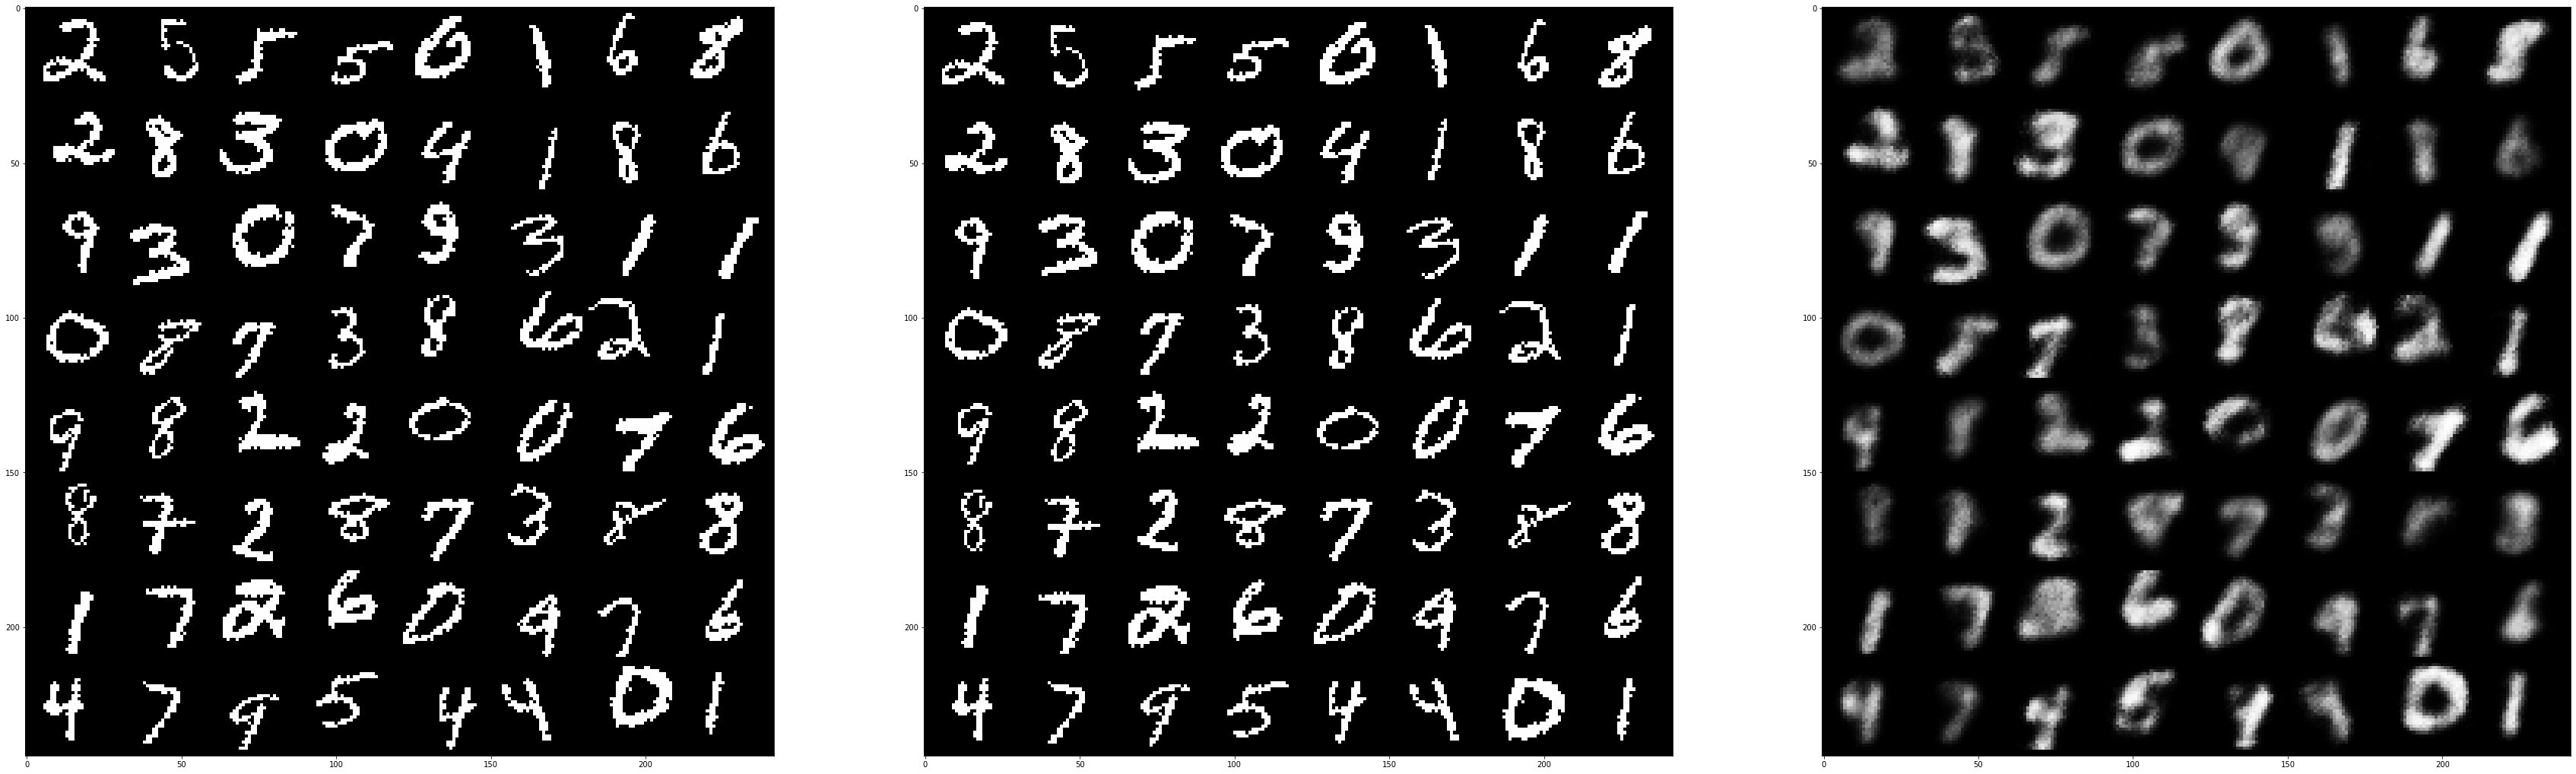

00003, 00201 loss : 0.18828, time: 334.85


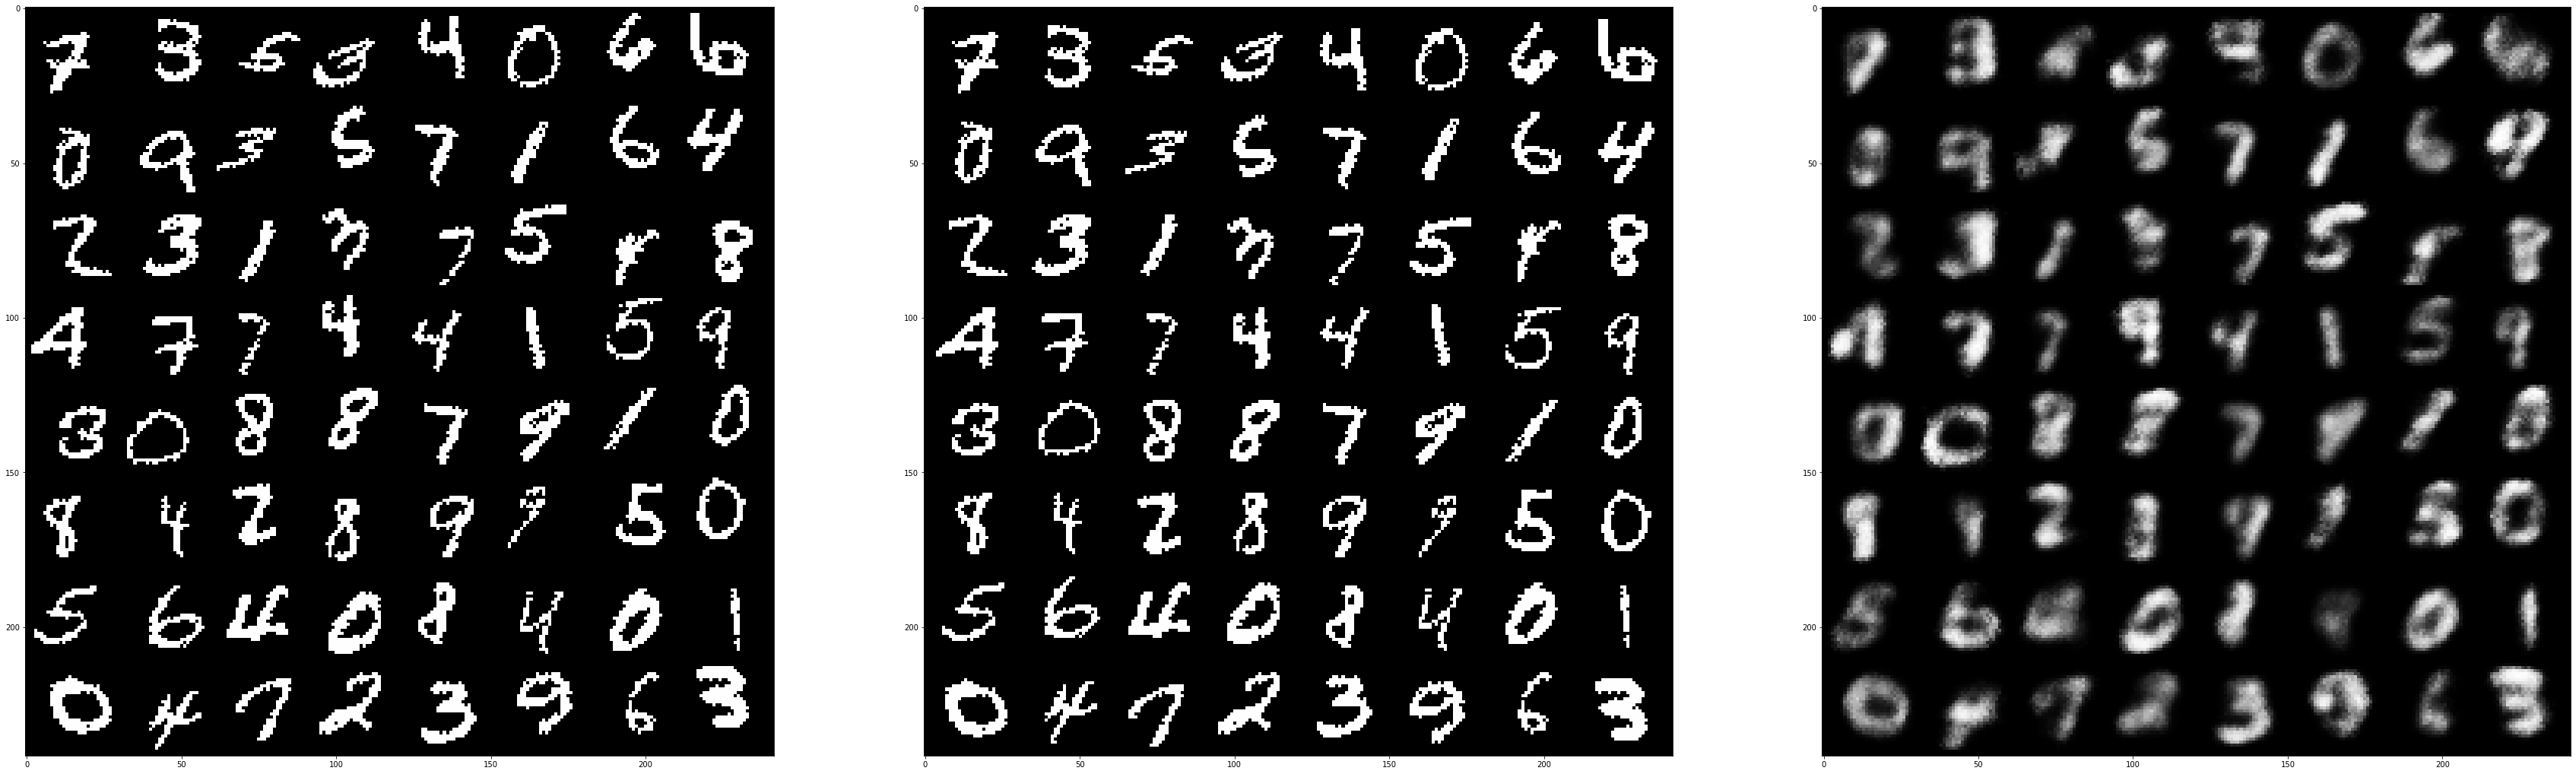

00003, 00301 loss : 0.18693, time: 350.58


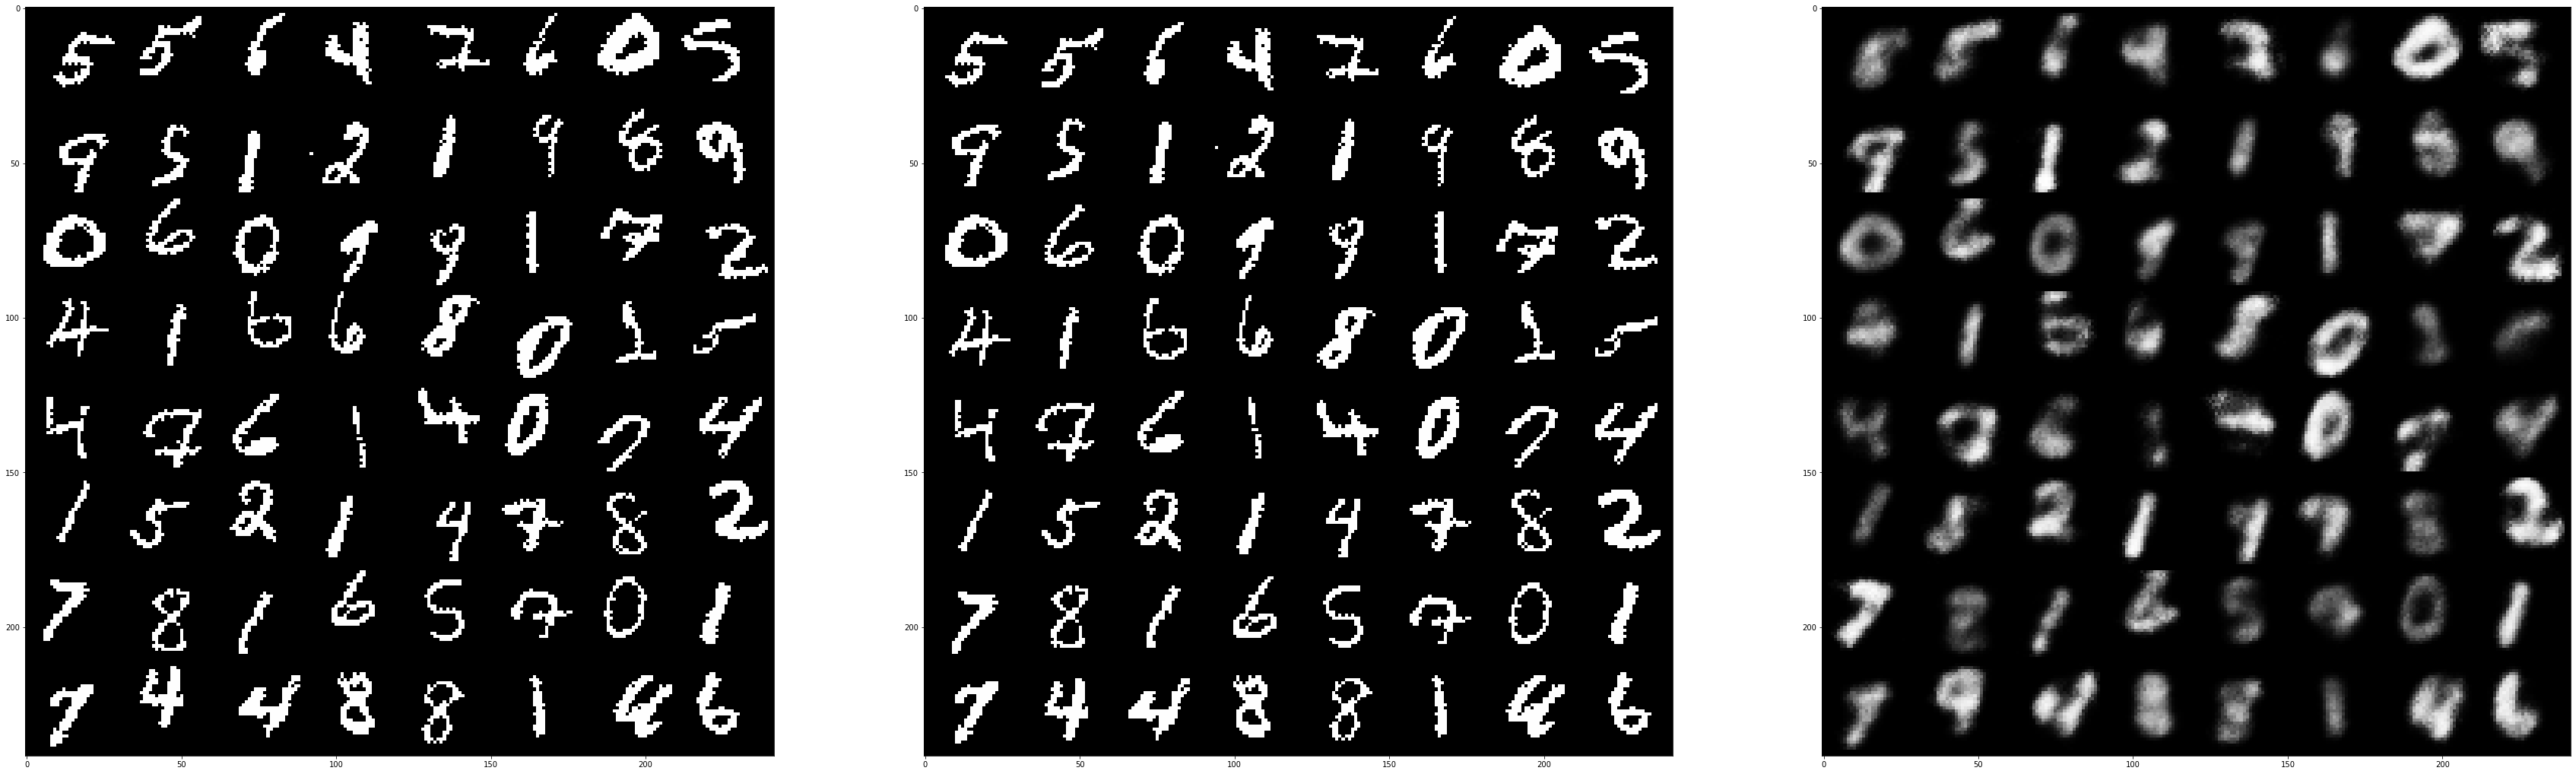

00003, 00401 loss : 0.18679, time: 366.16


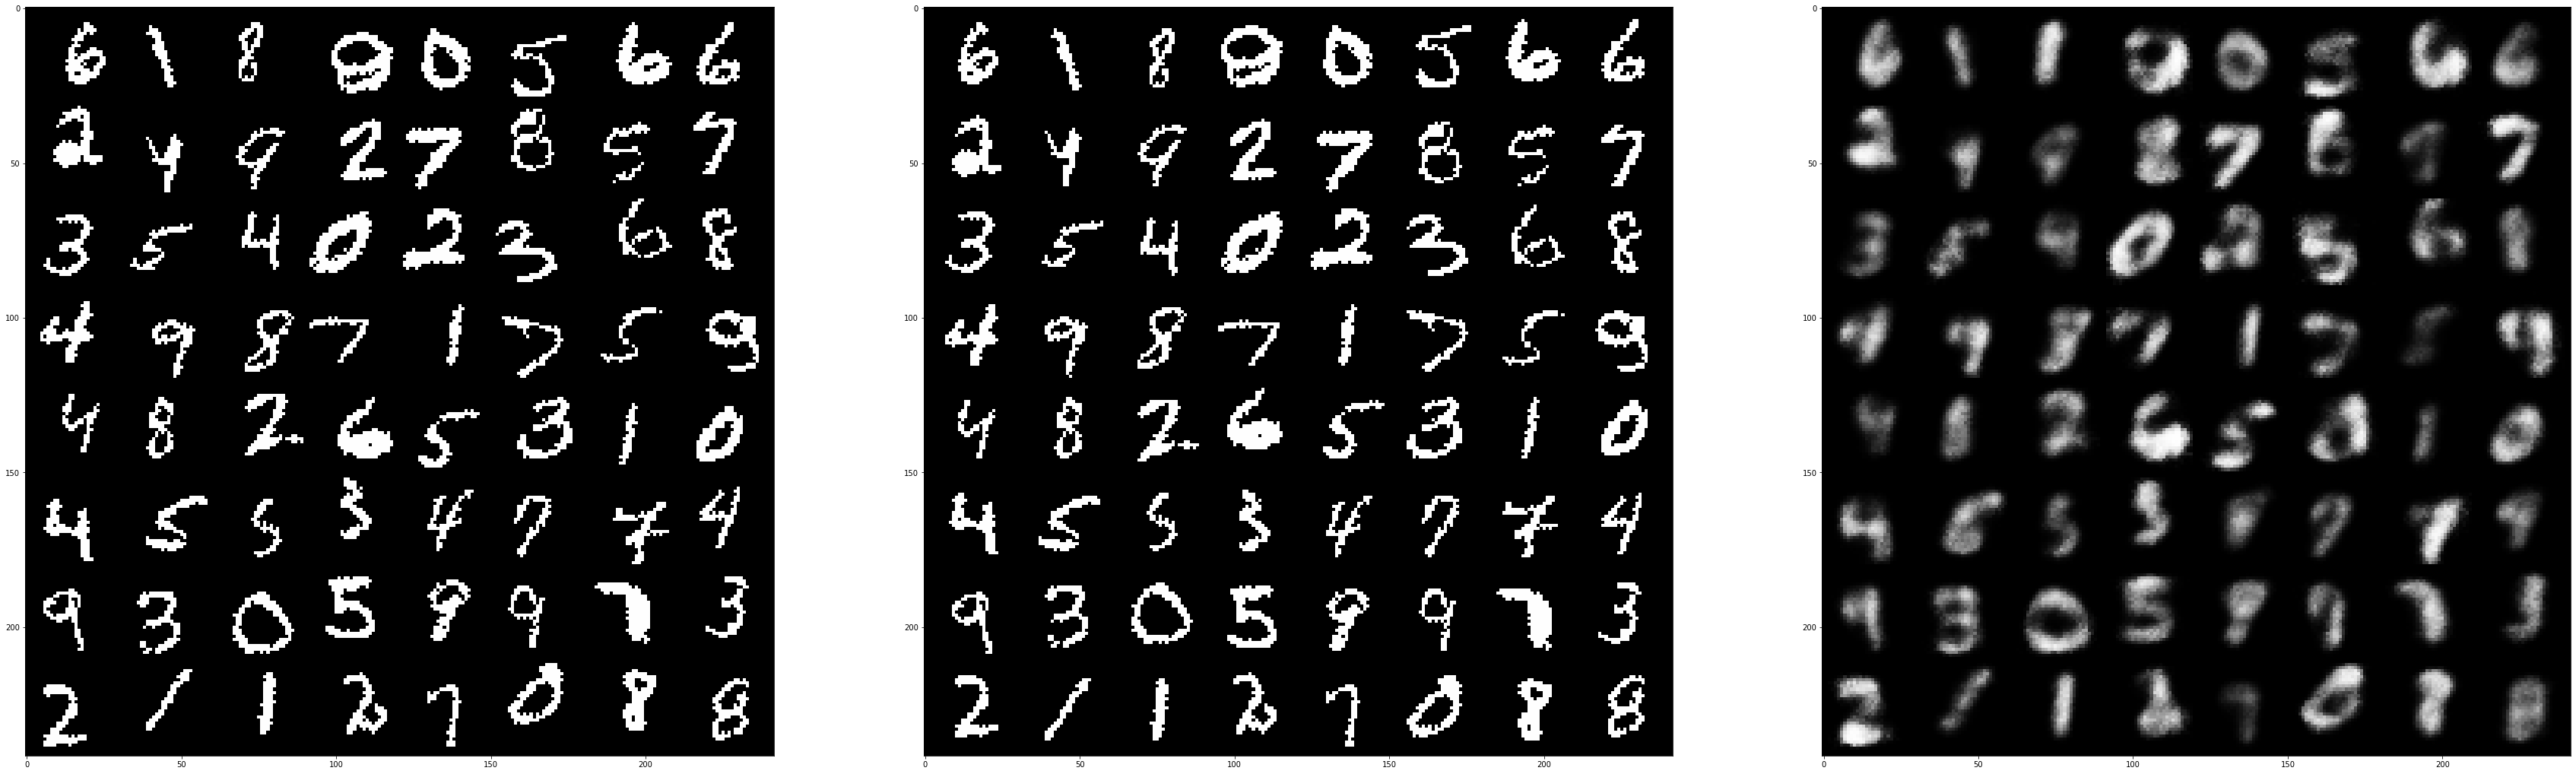

00003, 00501 loss : 0.18581, time: 382.04


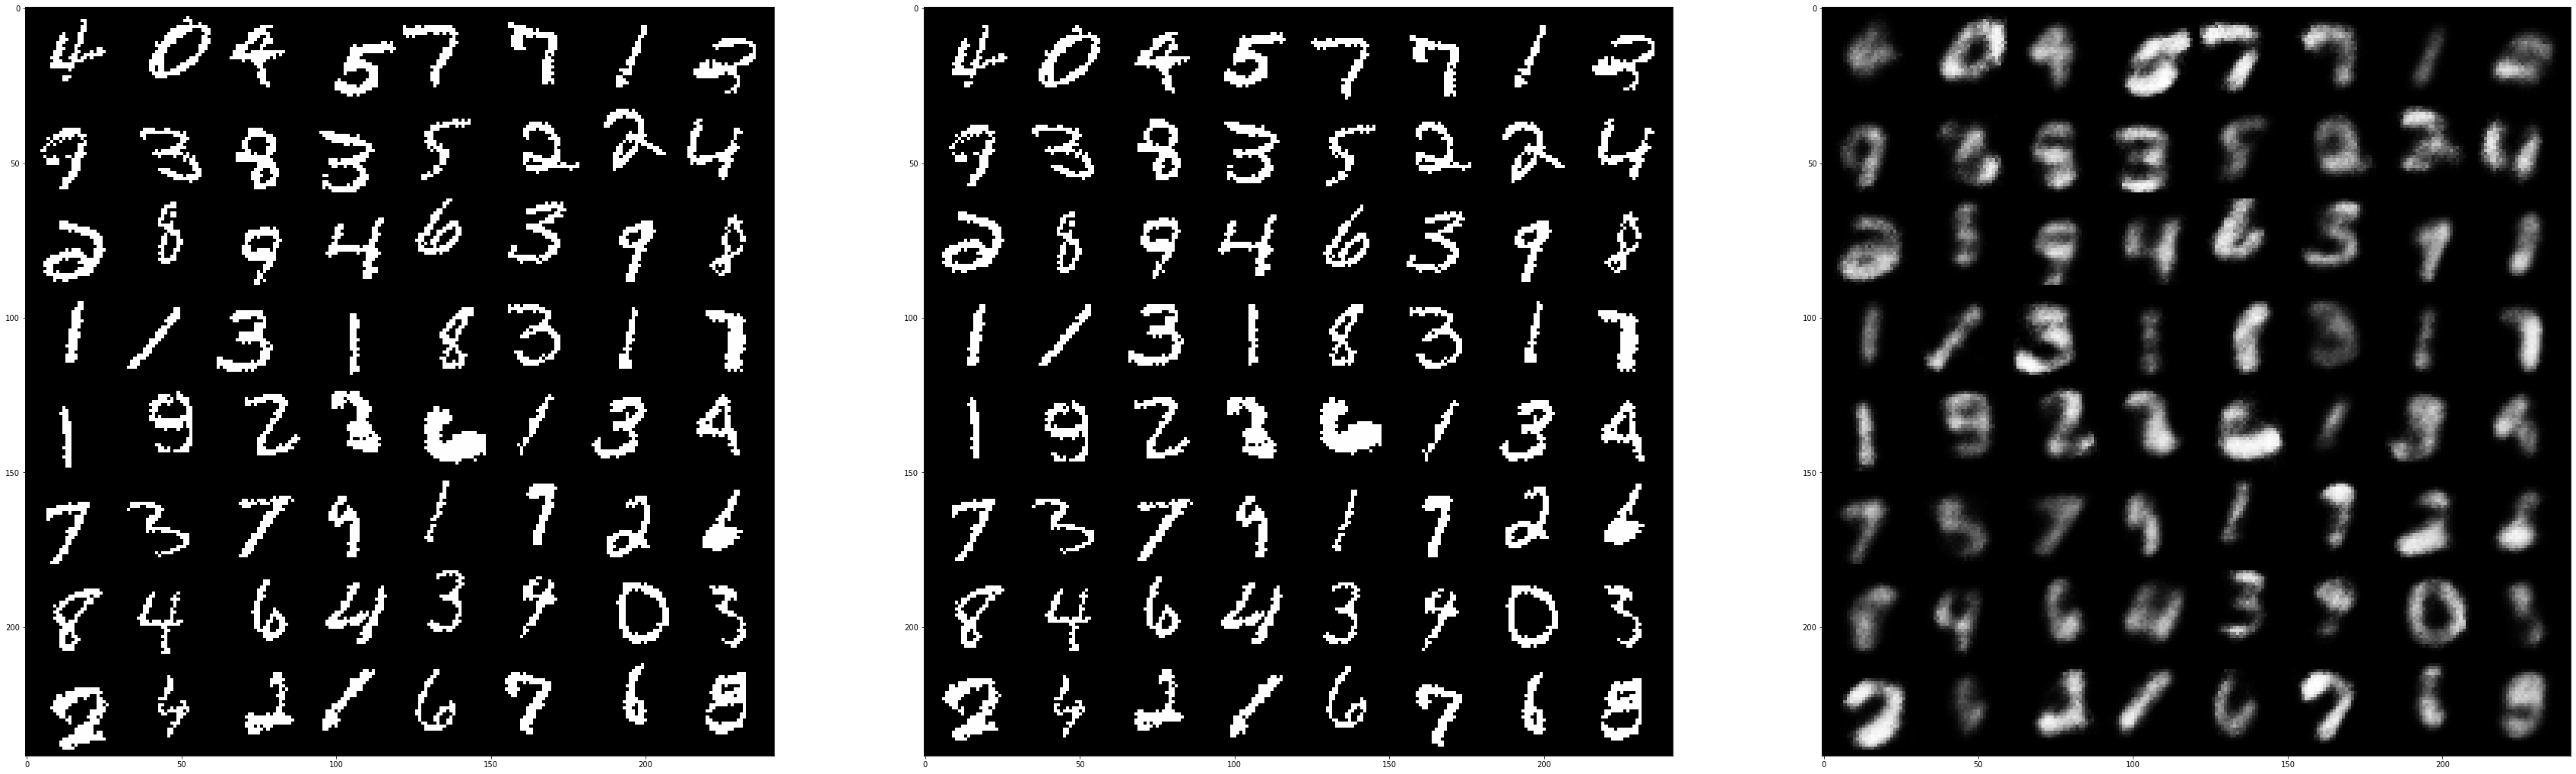

00003, 00601 loss : 0.18841, time: 398.20


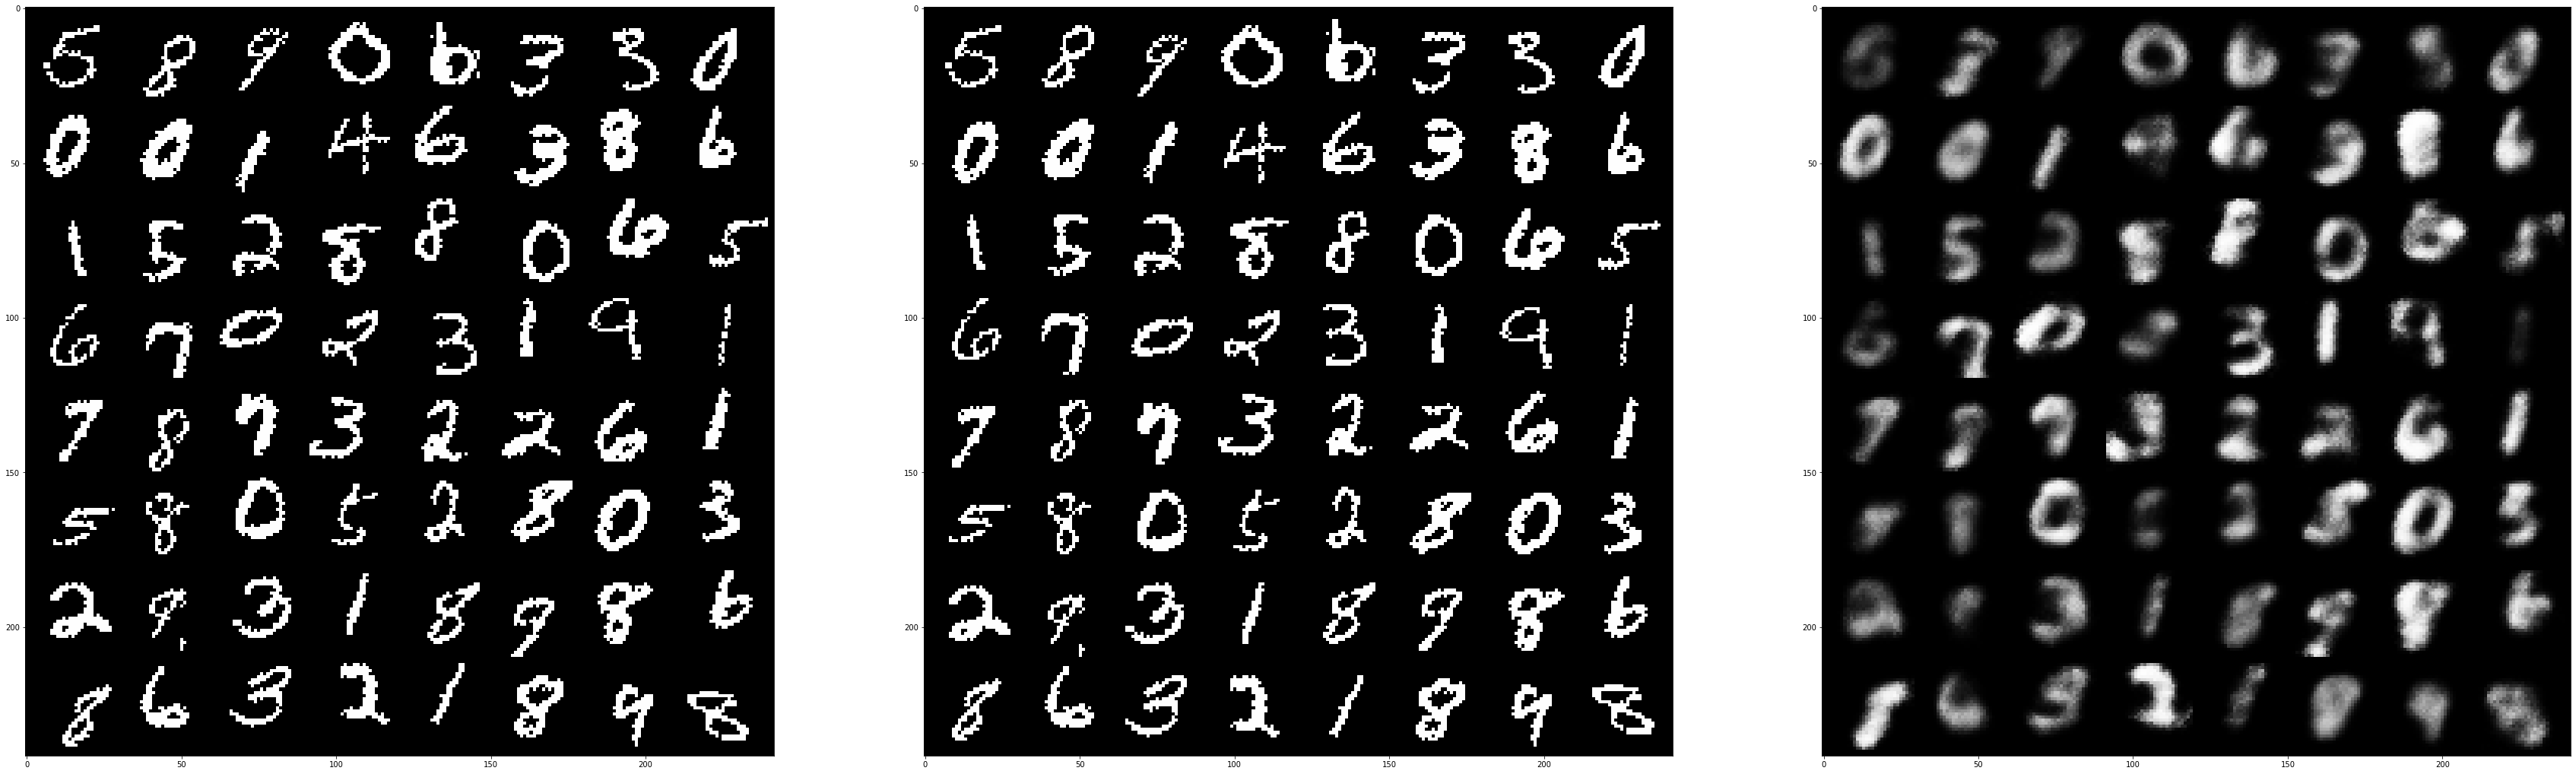

00003, 00701 loss : 0.18561, time: 414.38


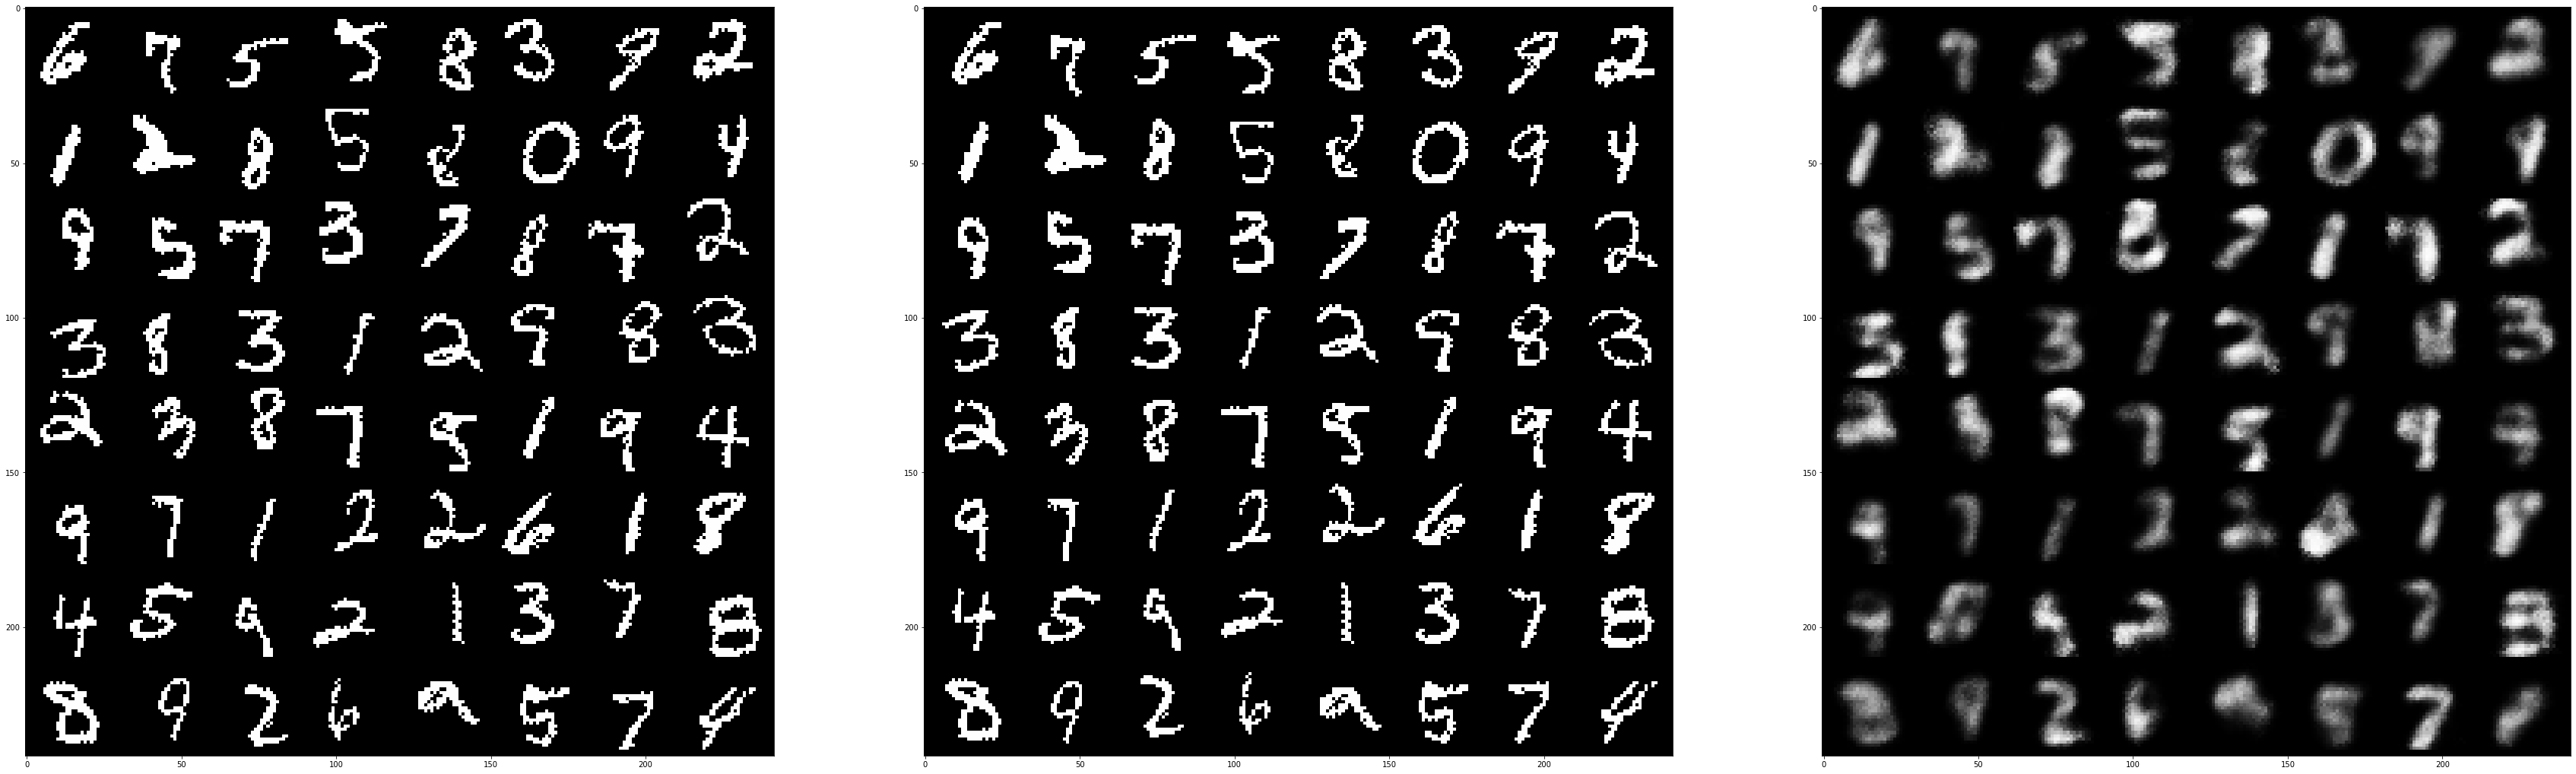

00003, 00801 loss : 0.18654, time: 430.58


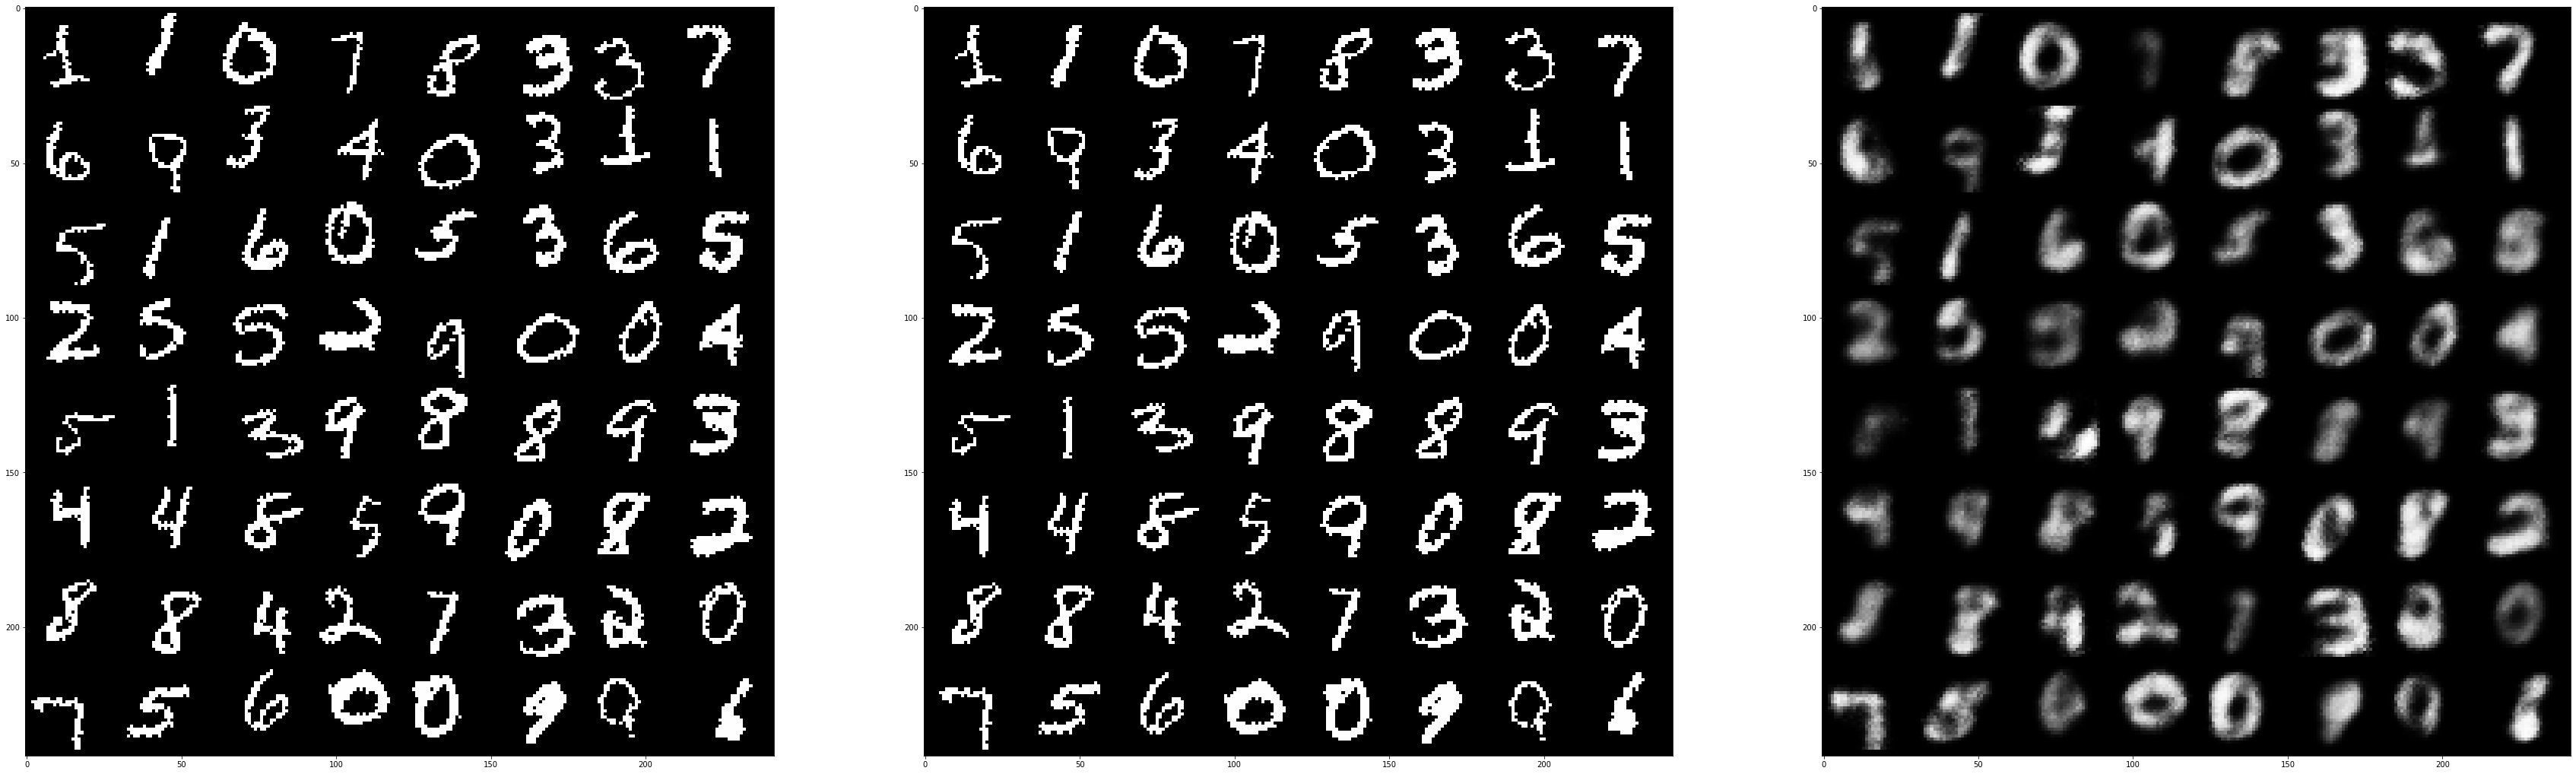

00003, 00901 loss : 0.18479, time: 446.77


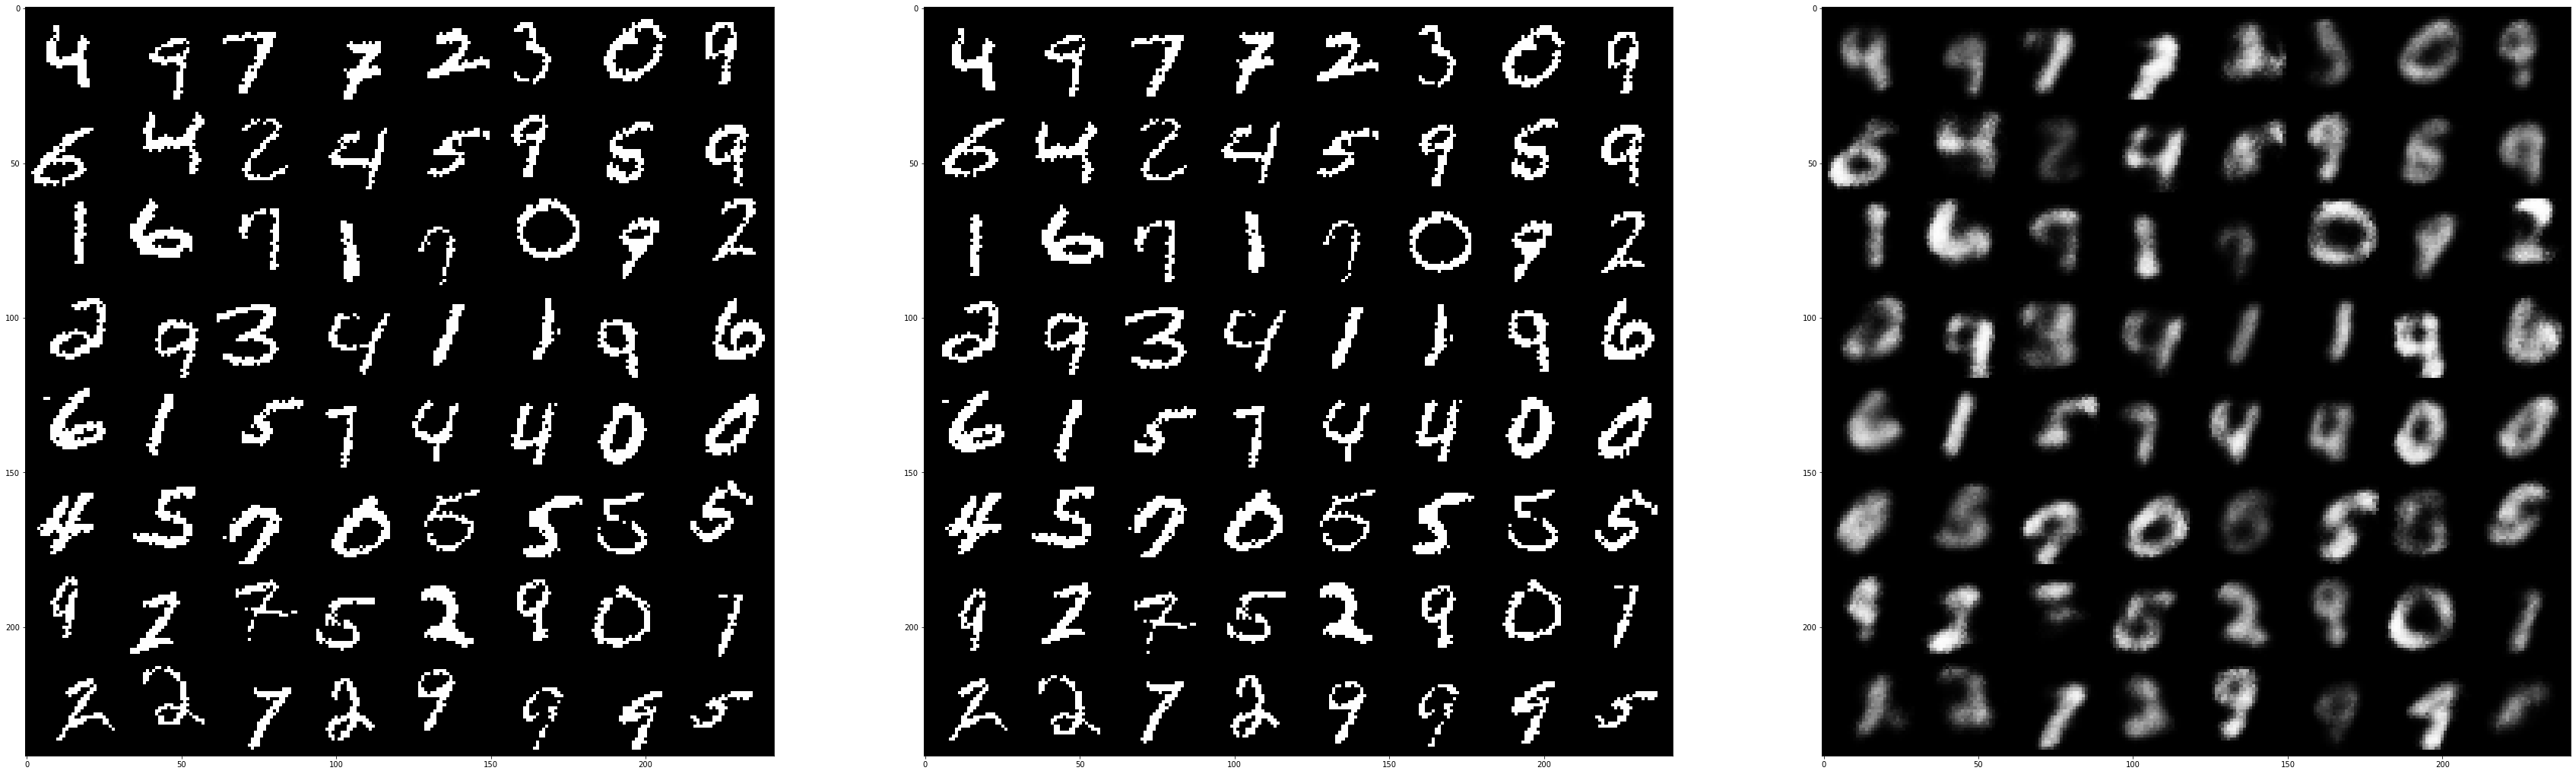

00004, 00101 loss : 0.18581, time: 468.78


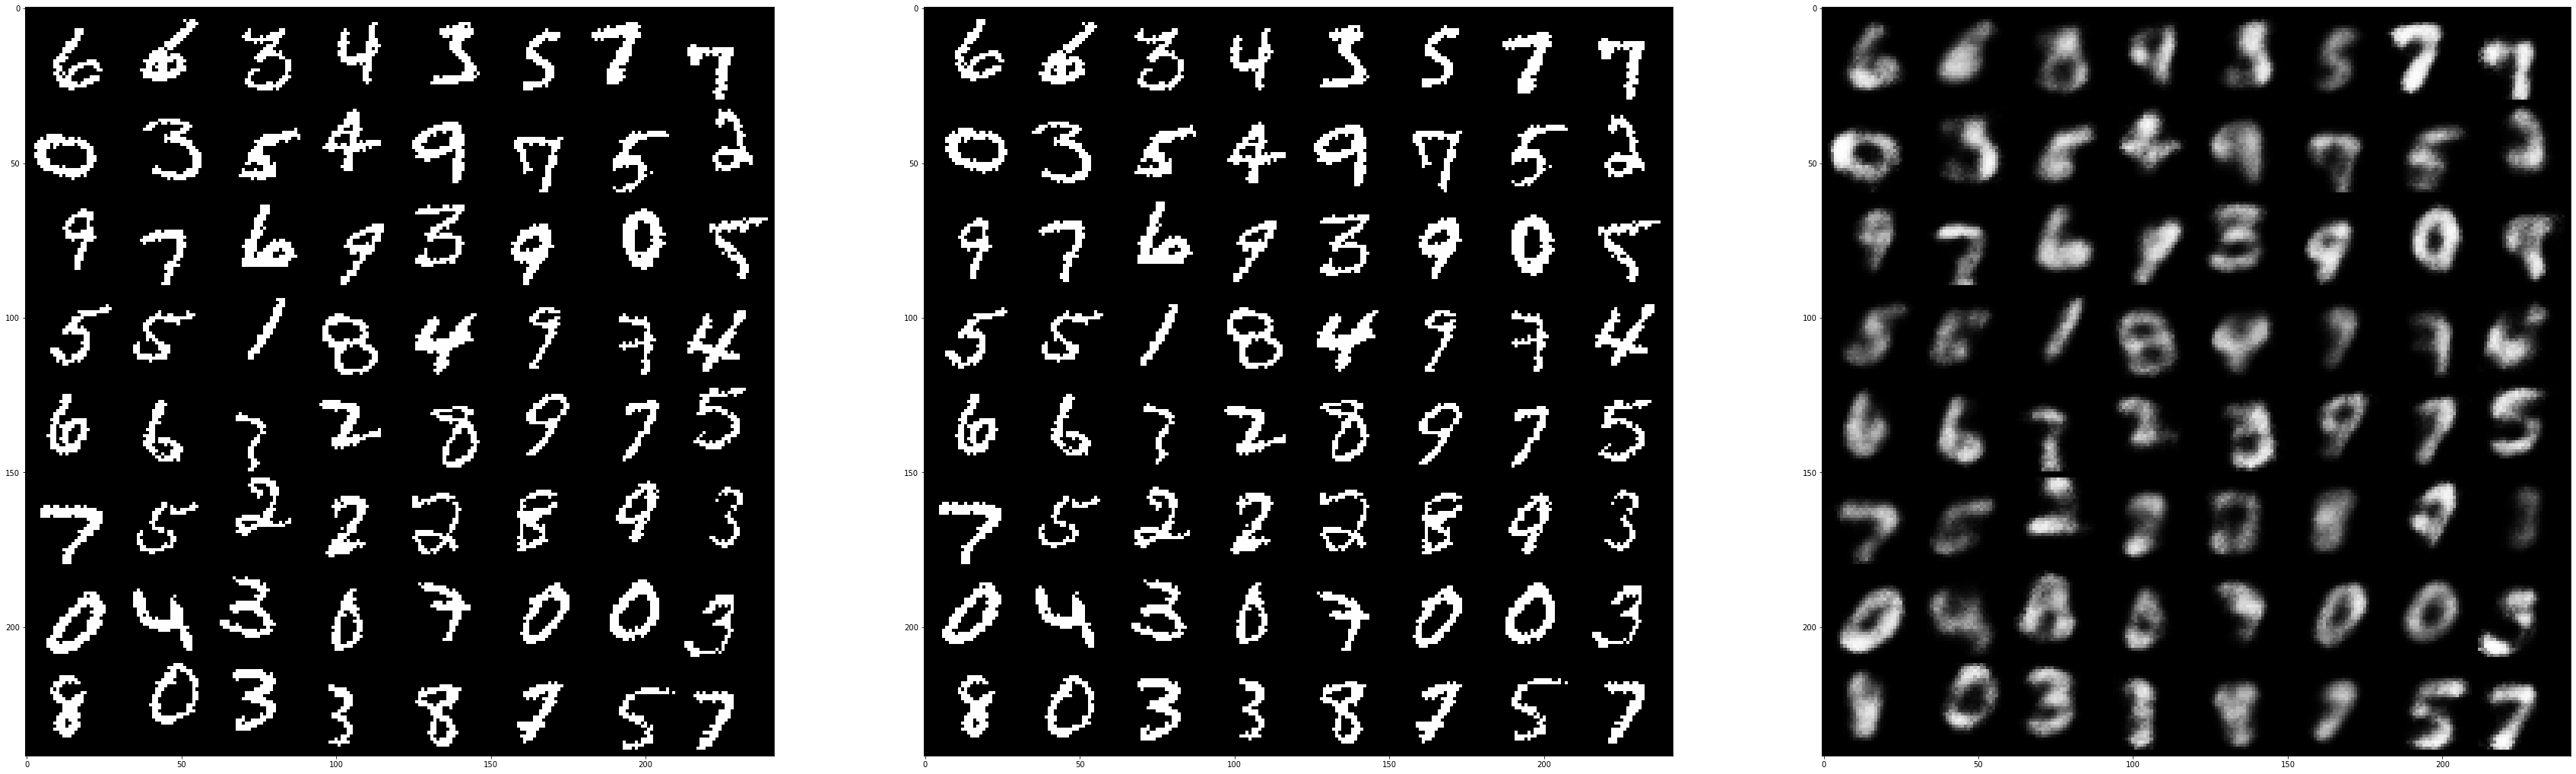

00004, 00201 loss : 0.18437, time: 484.91


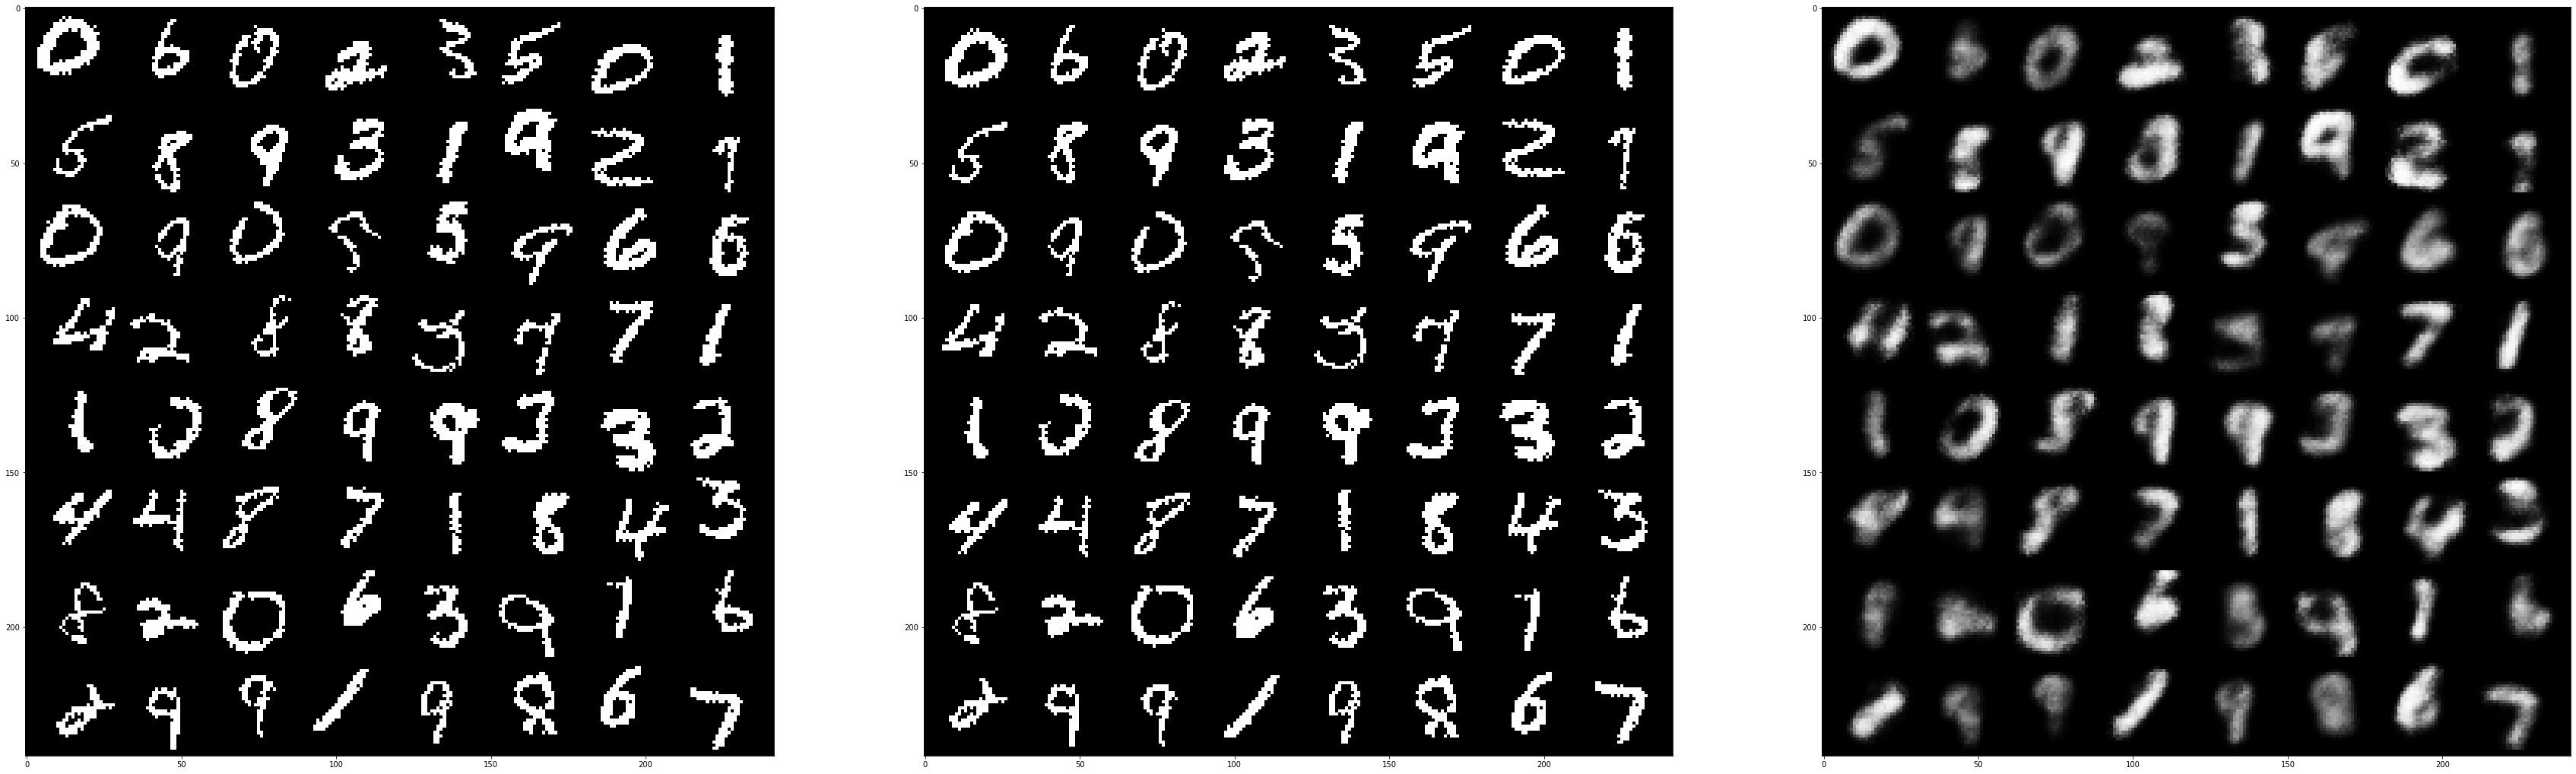

00004, 00301 loss : 0.18469, time: 501.42


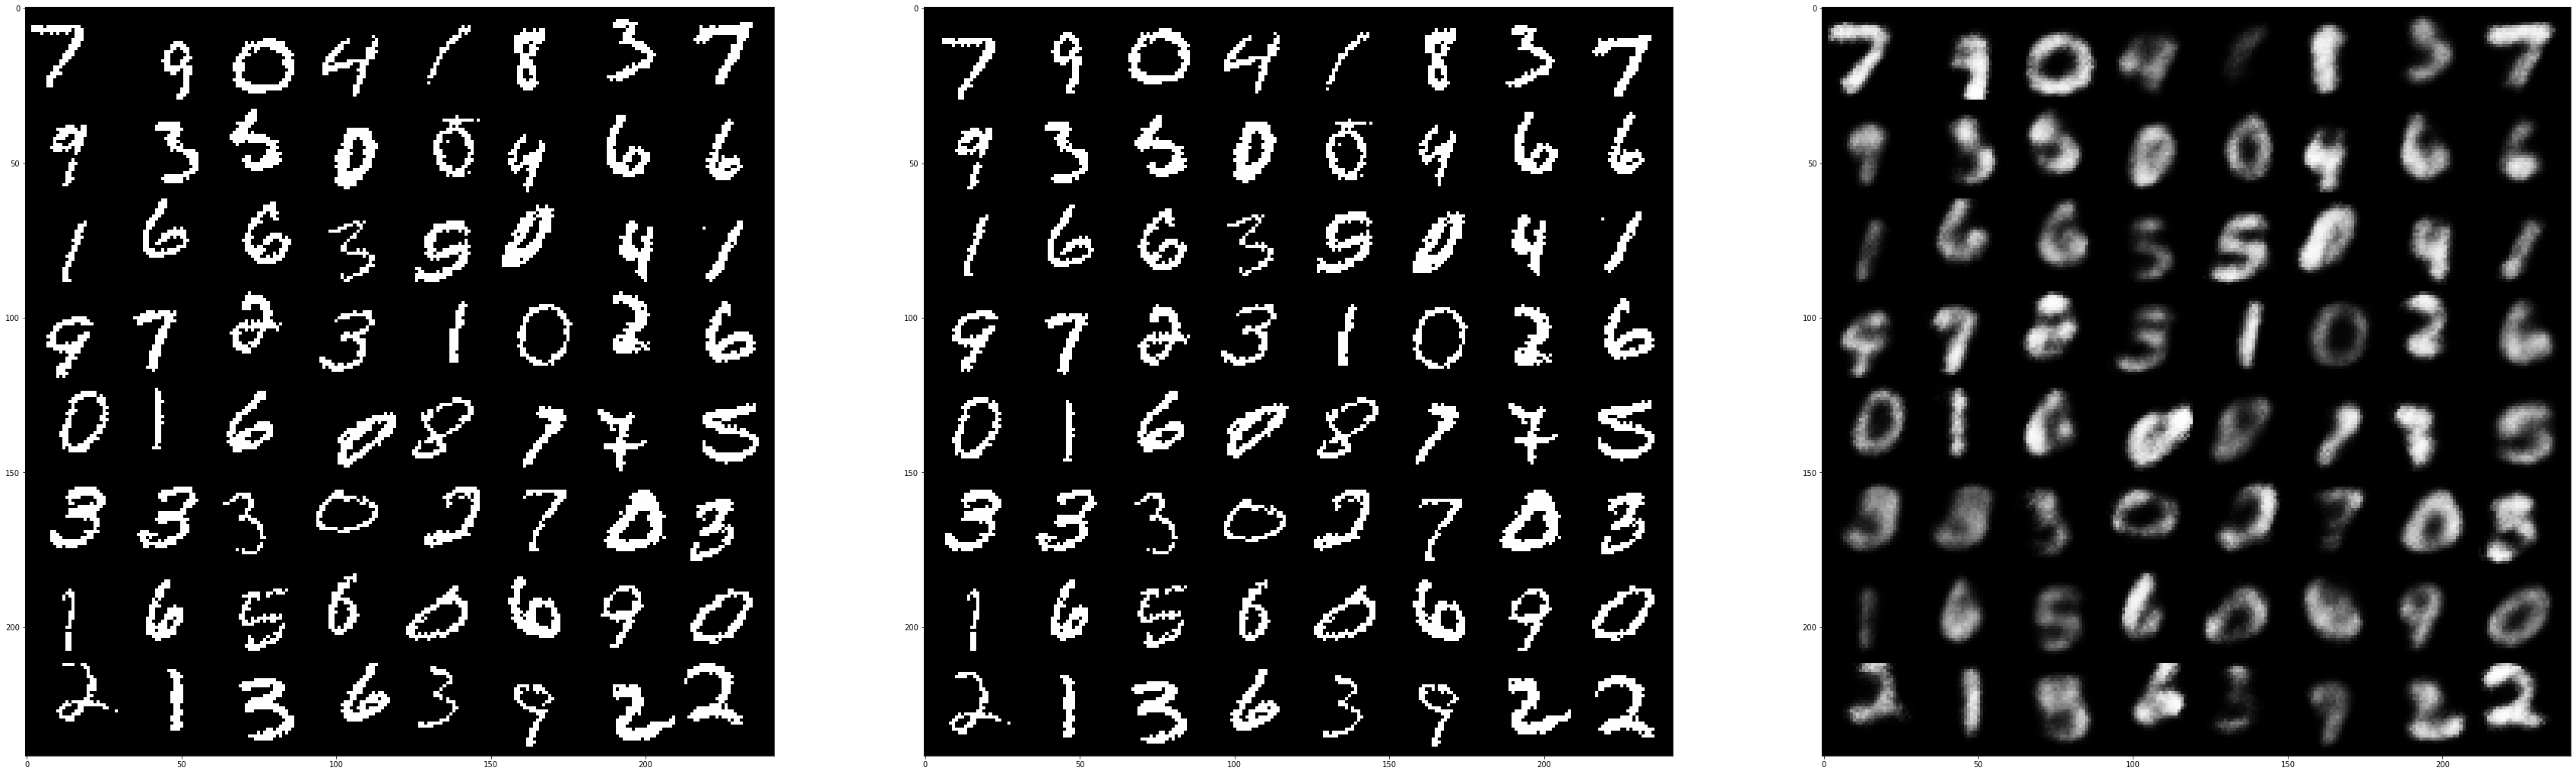

00004, 00401 loss : 0.18342, time: 517.47


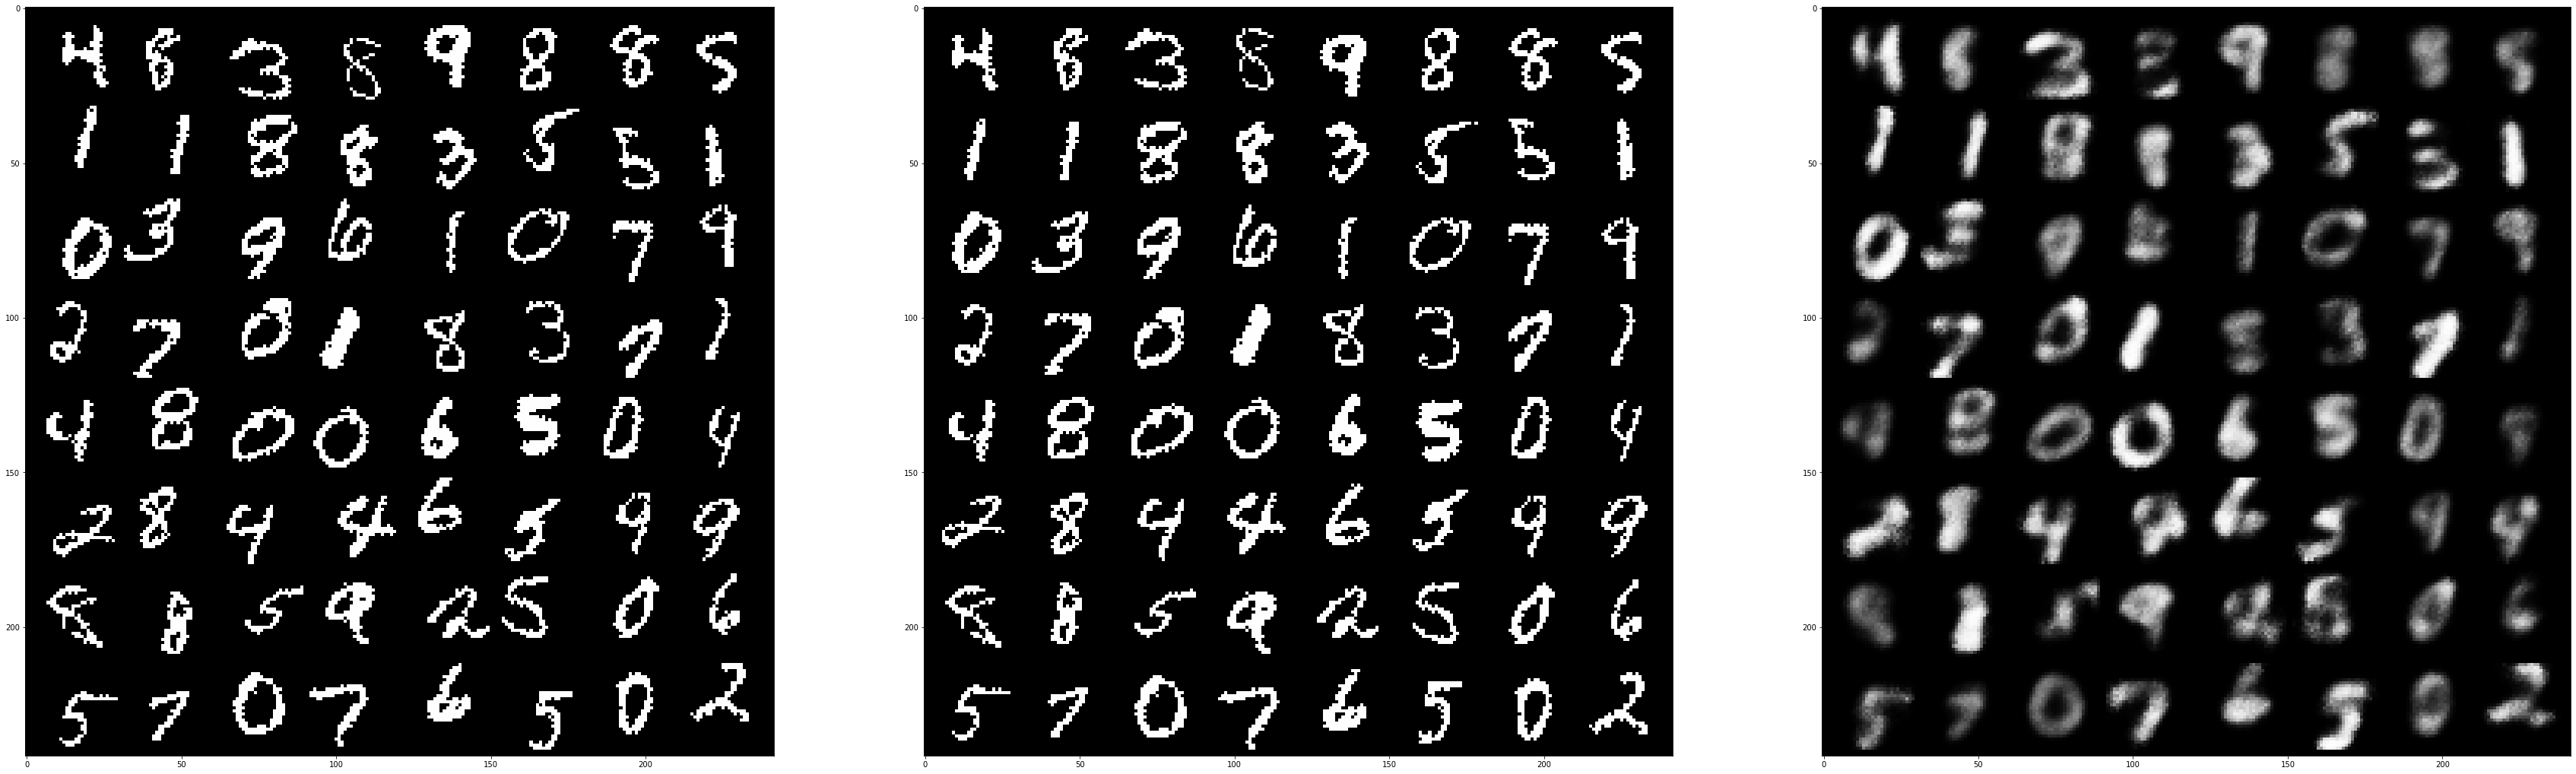

00004, 00501 loss : 0.18388, time: 533.53


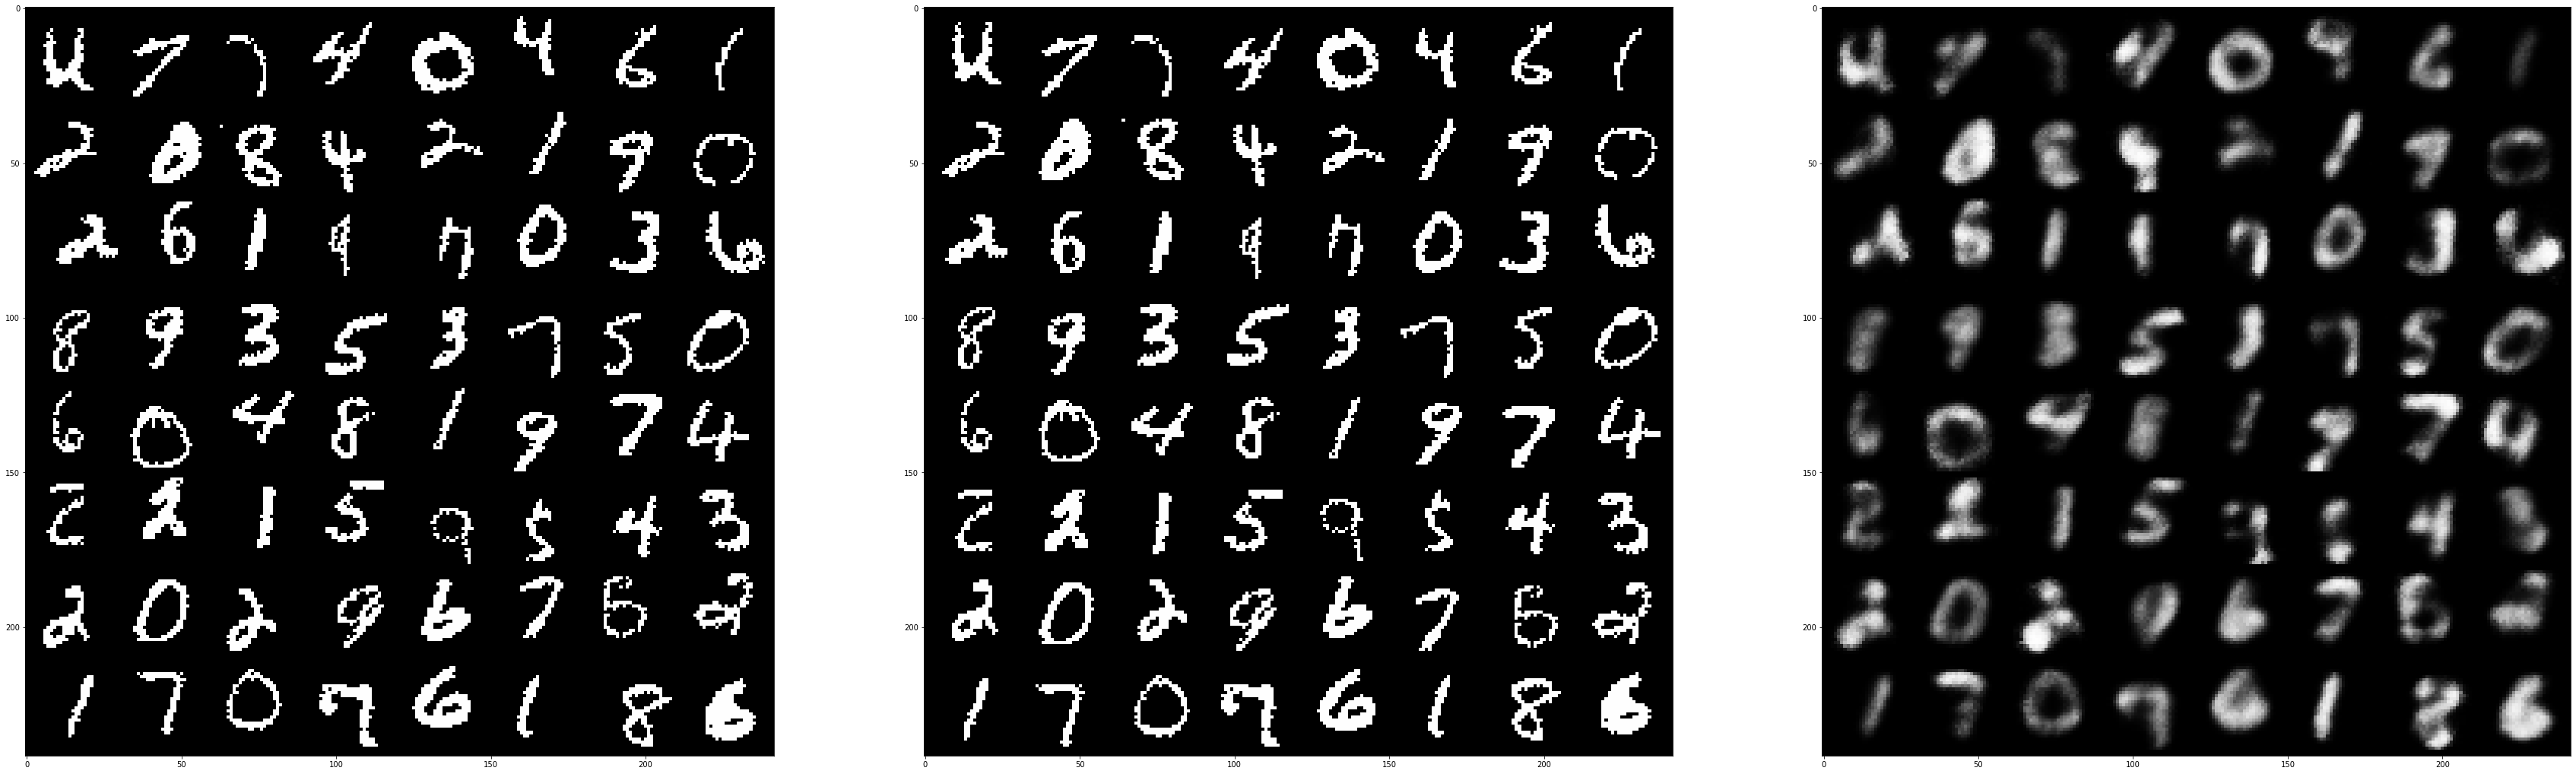

00004, 00601 loss : 0.18389, time: 549.58


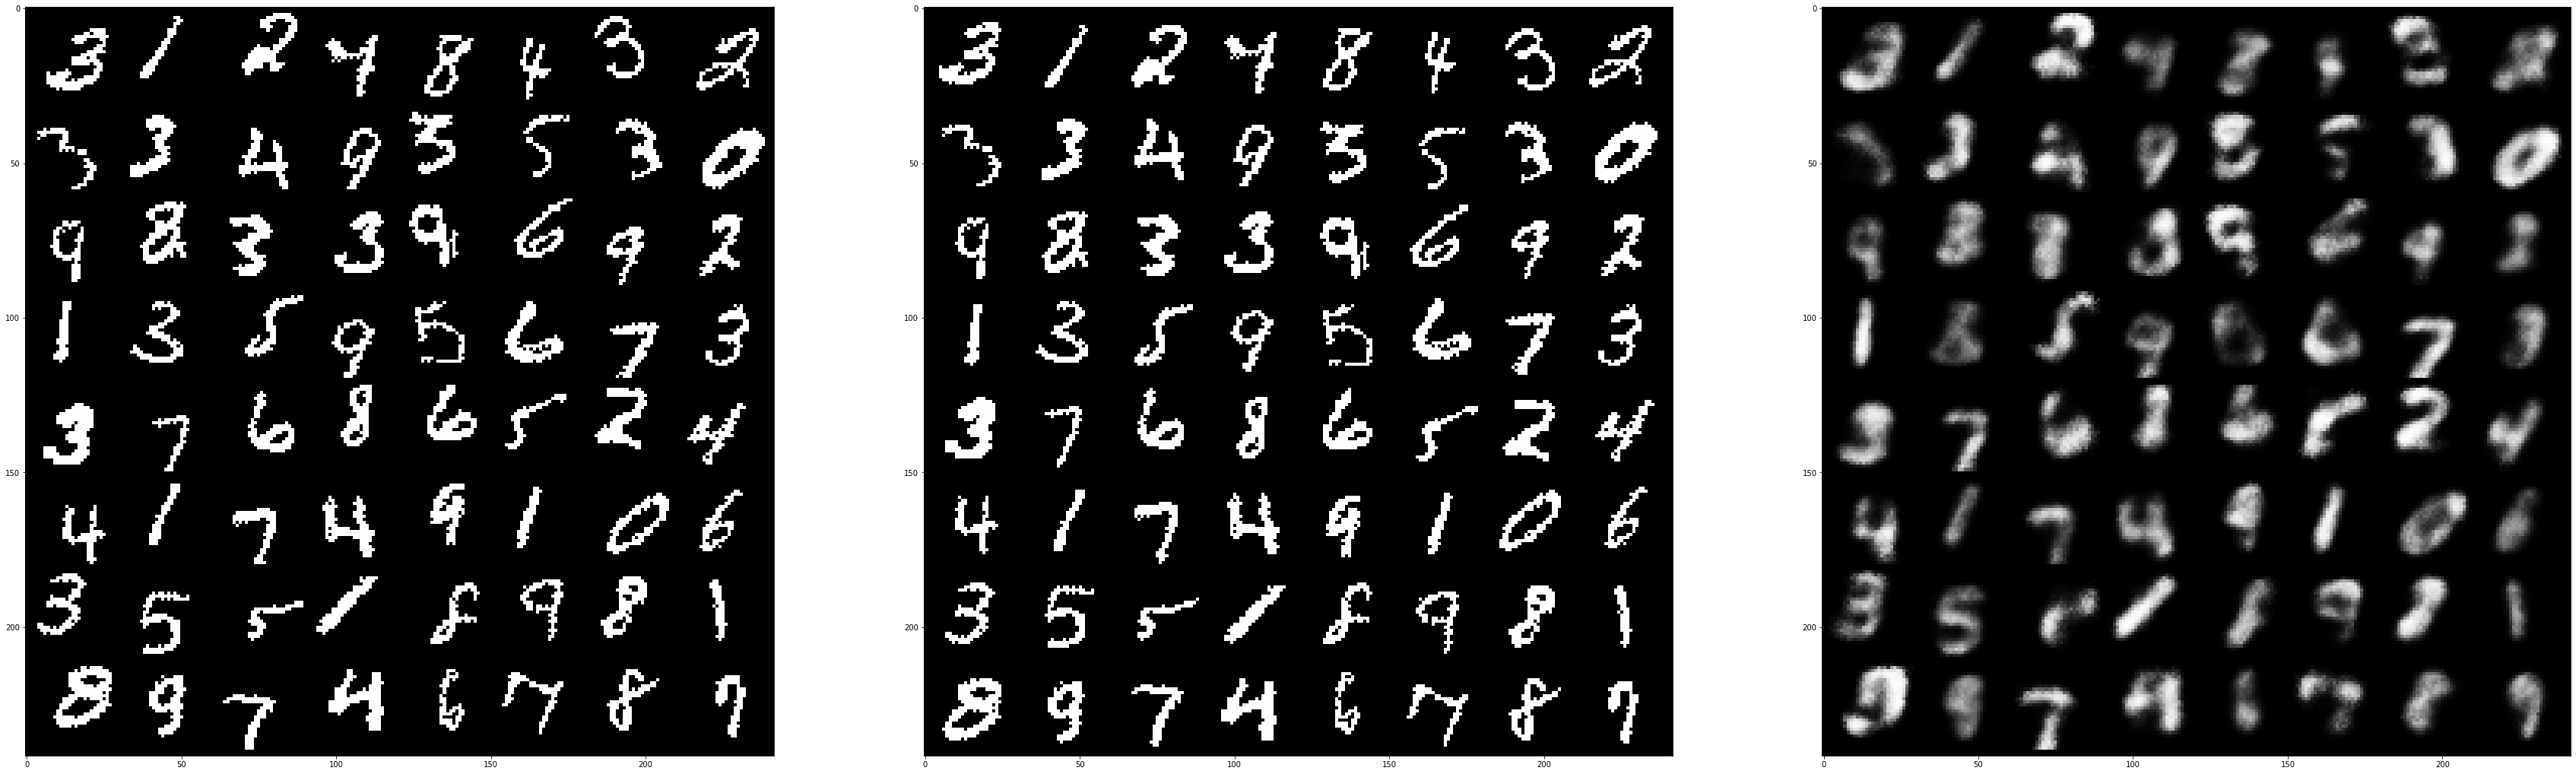

00004, 00701 loss : 0.18380, time: 565.77


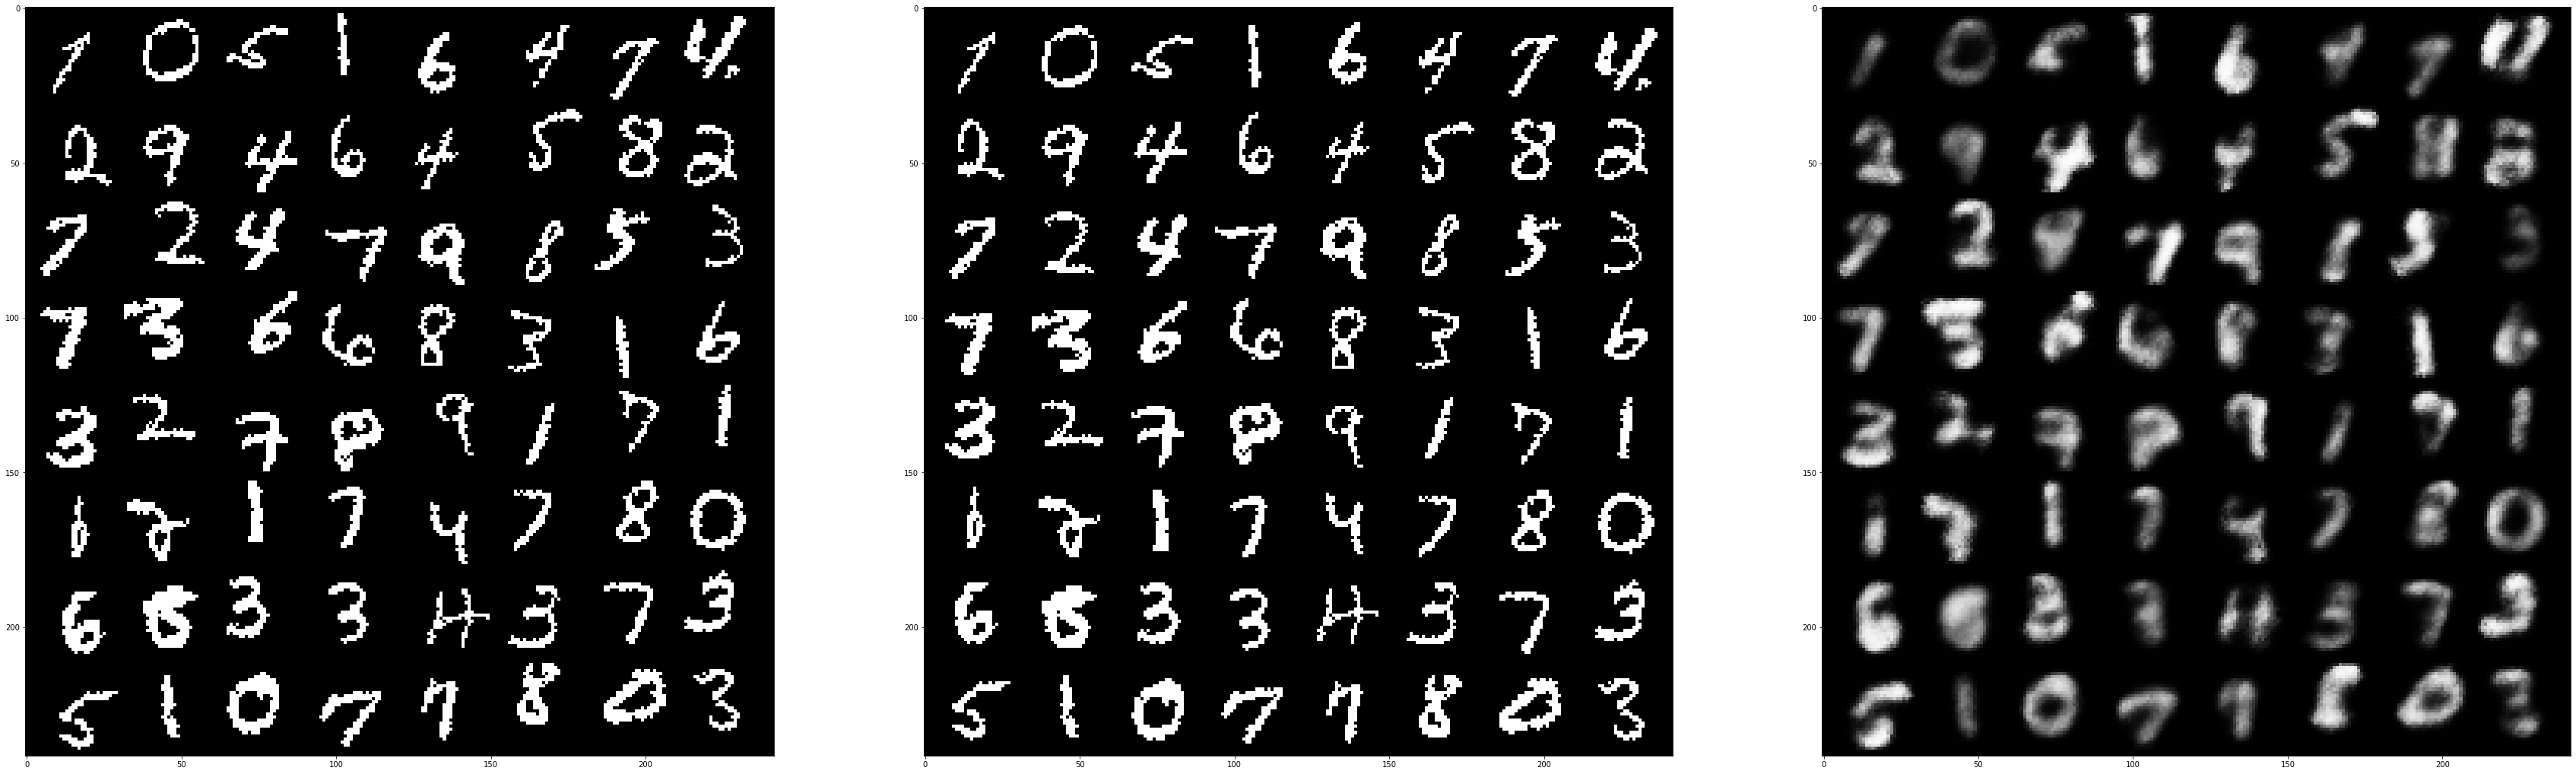

00004, 00801 loss : 0.18382, time: 581.96


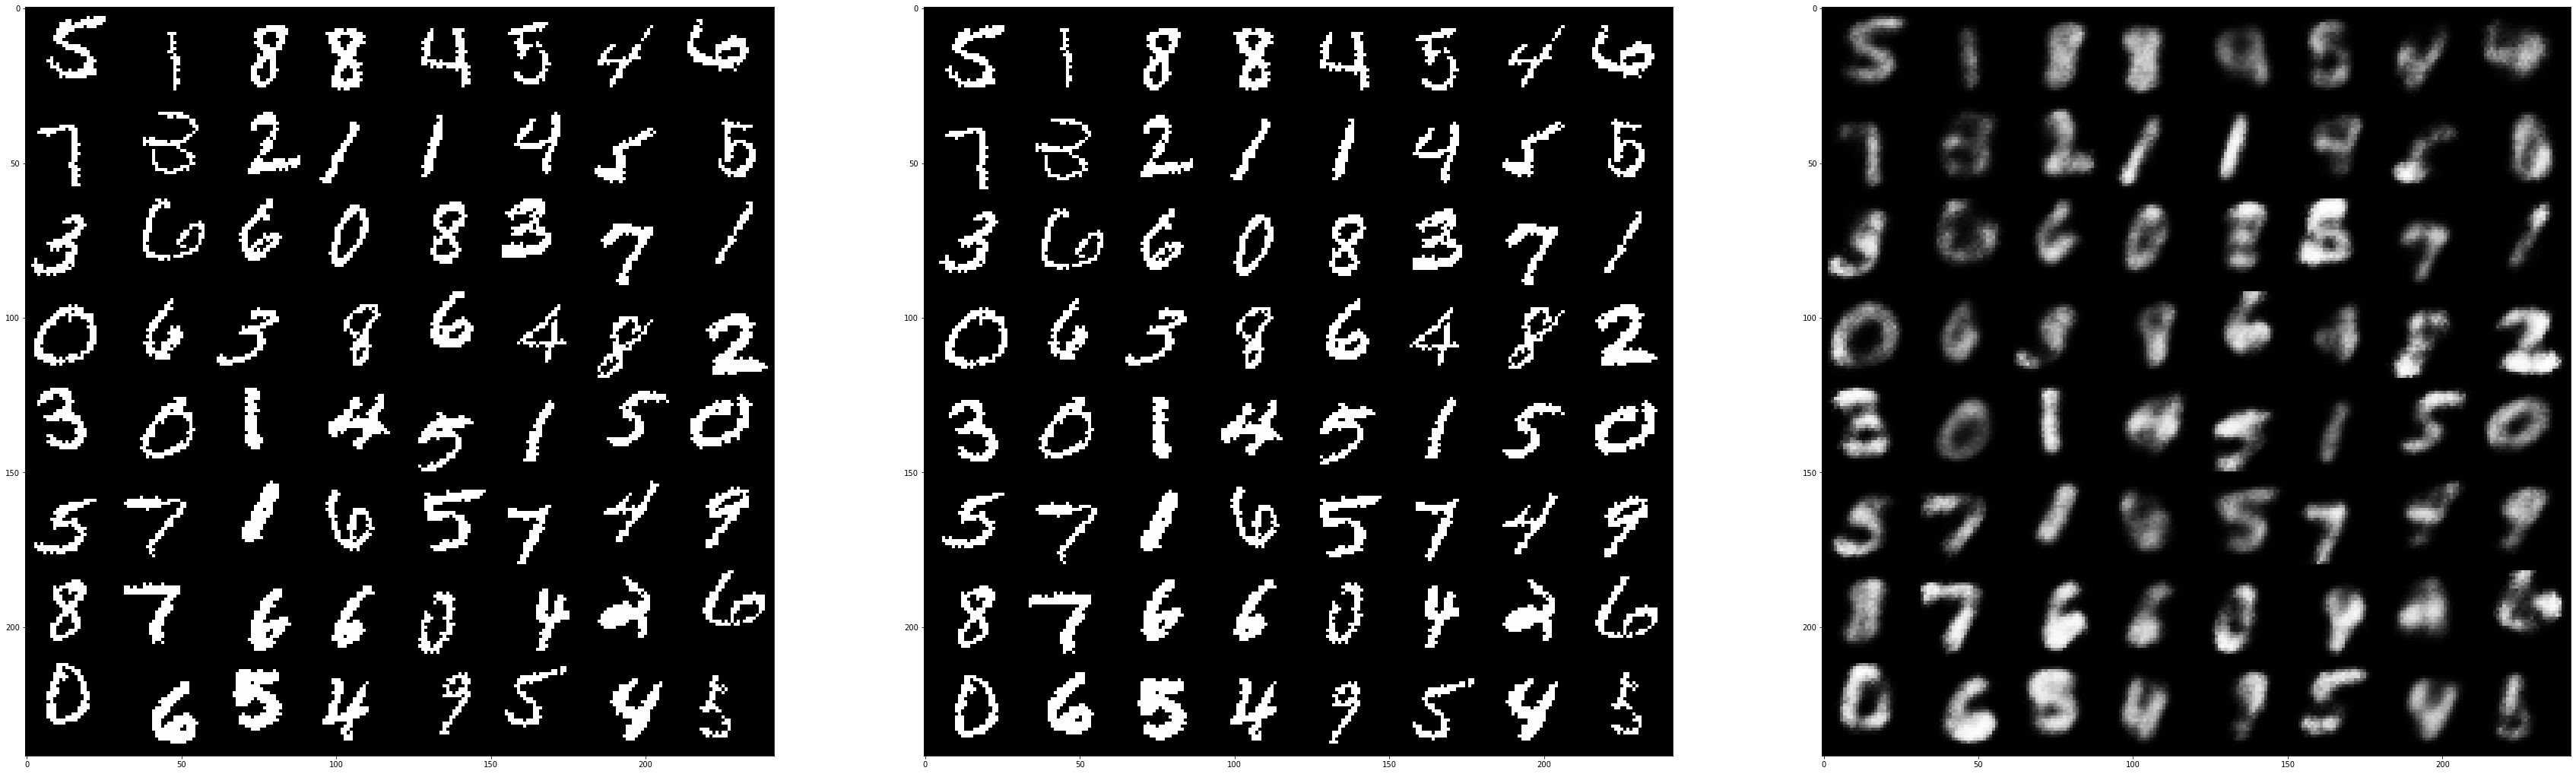

00004, 00901 loss : 0.18258, time: 598.14


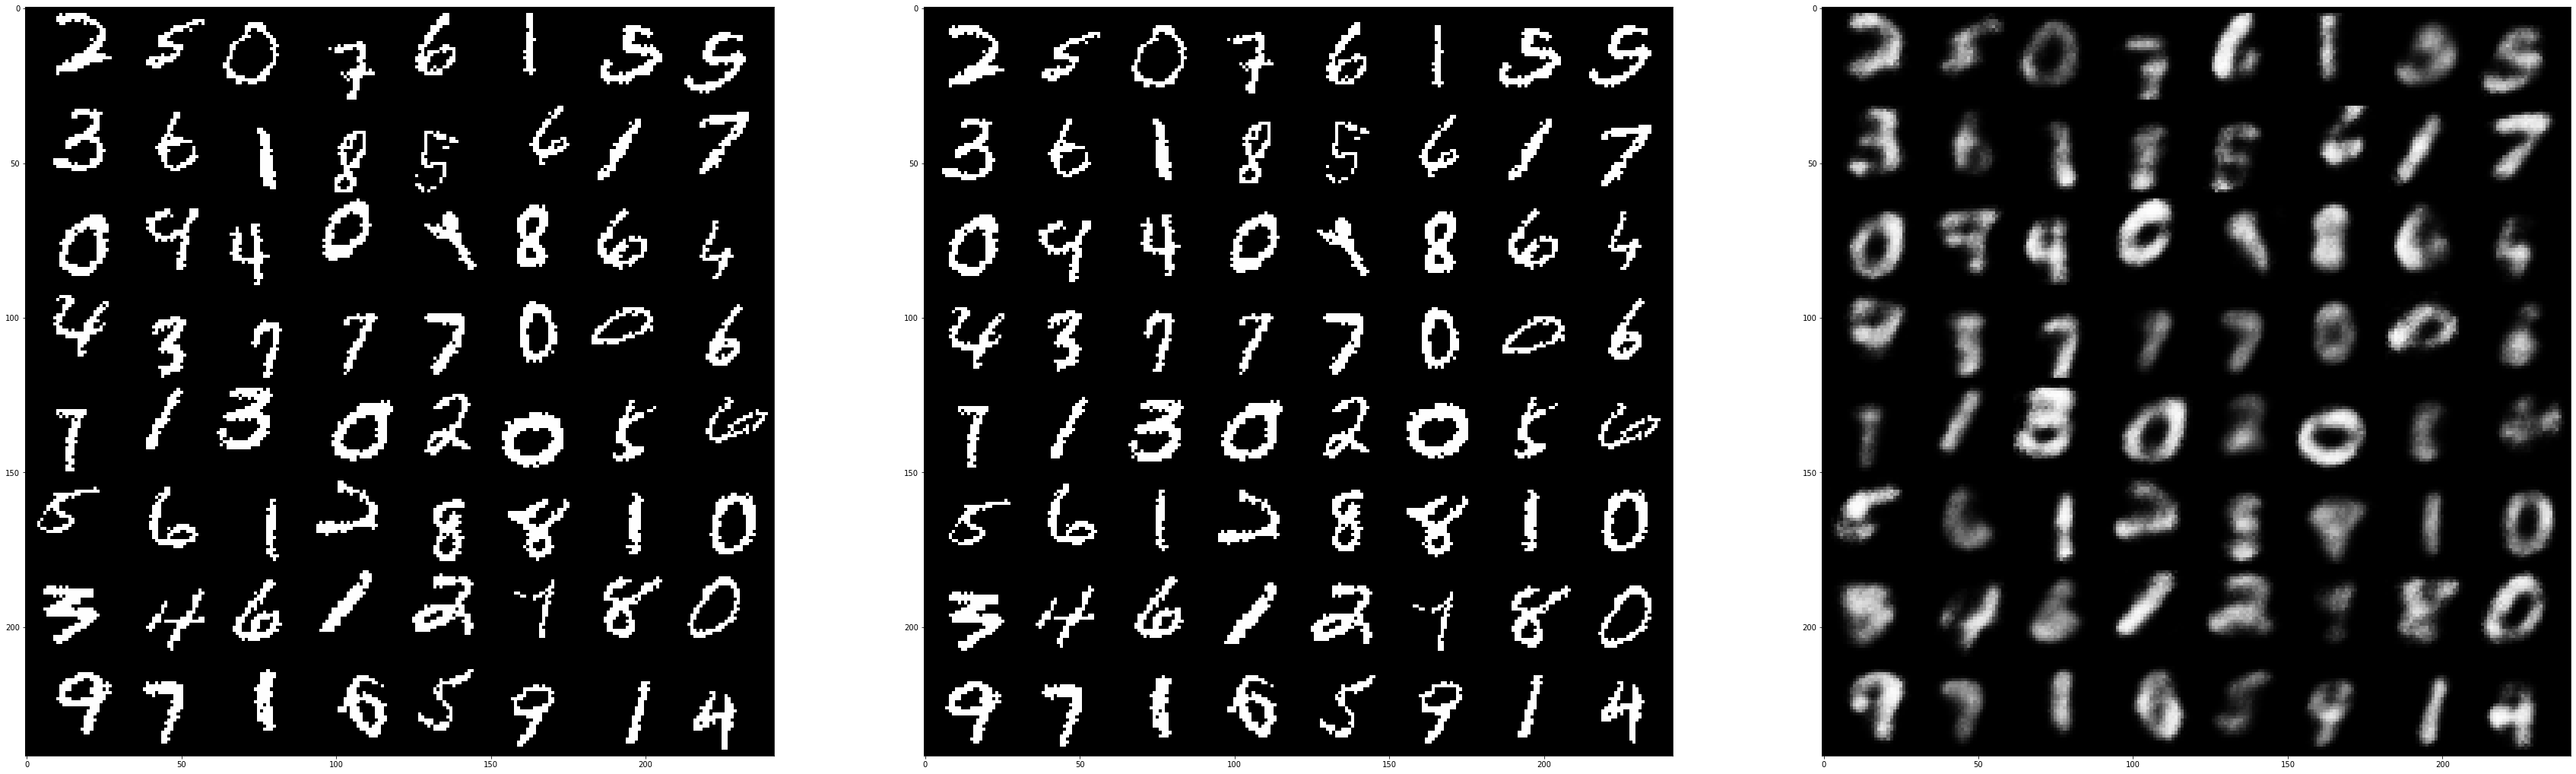

00005, 00101 loss : 0.18257, time: 620.00


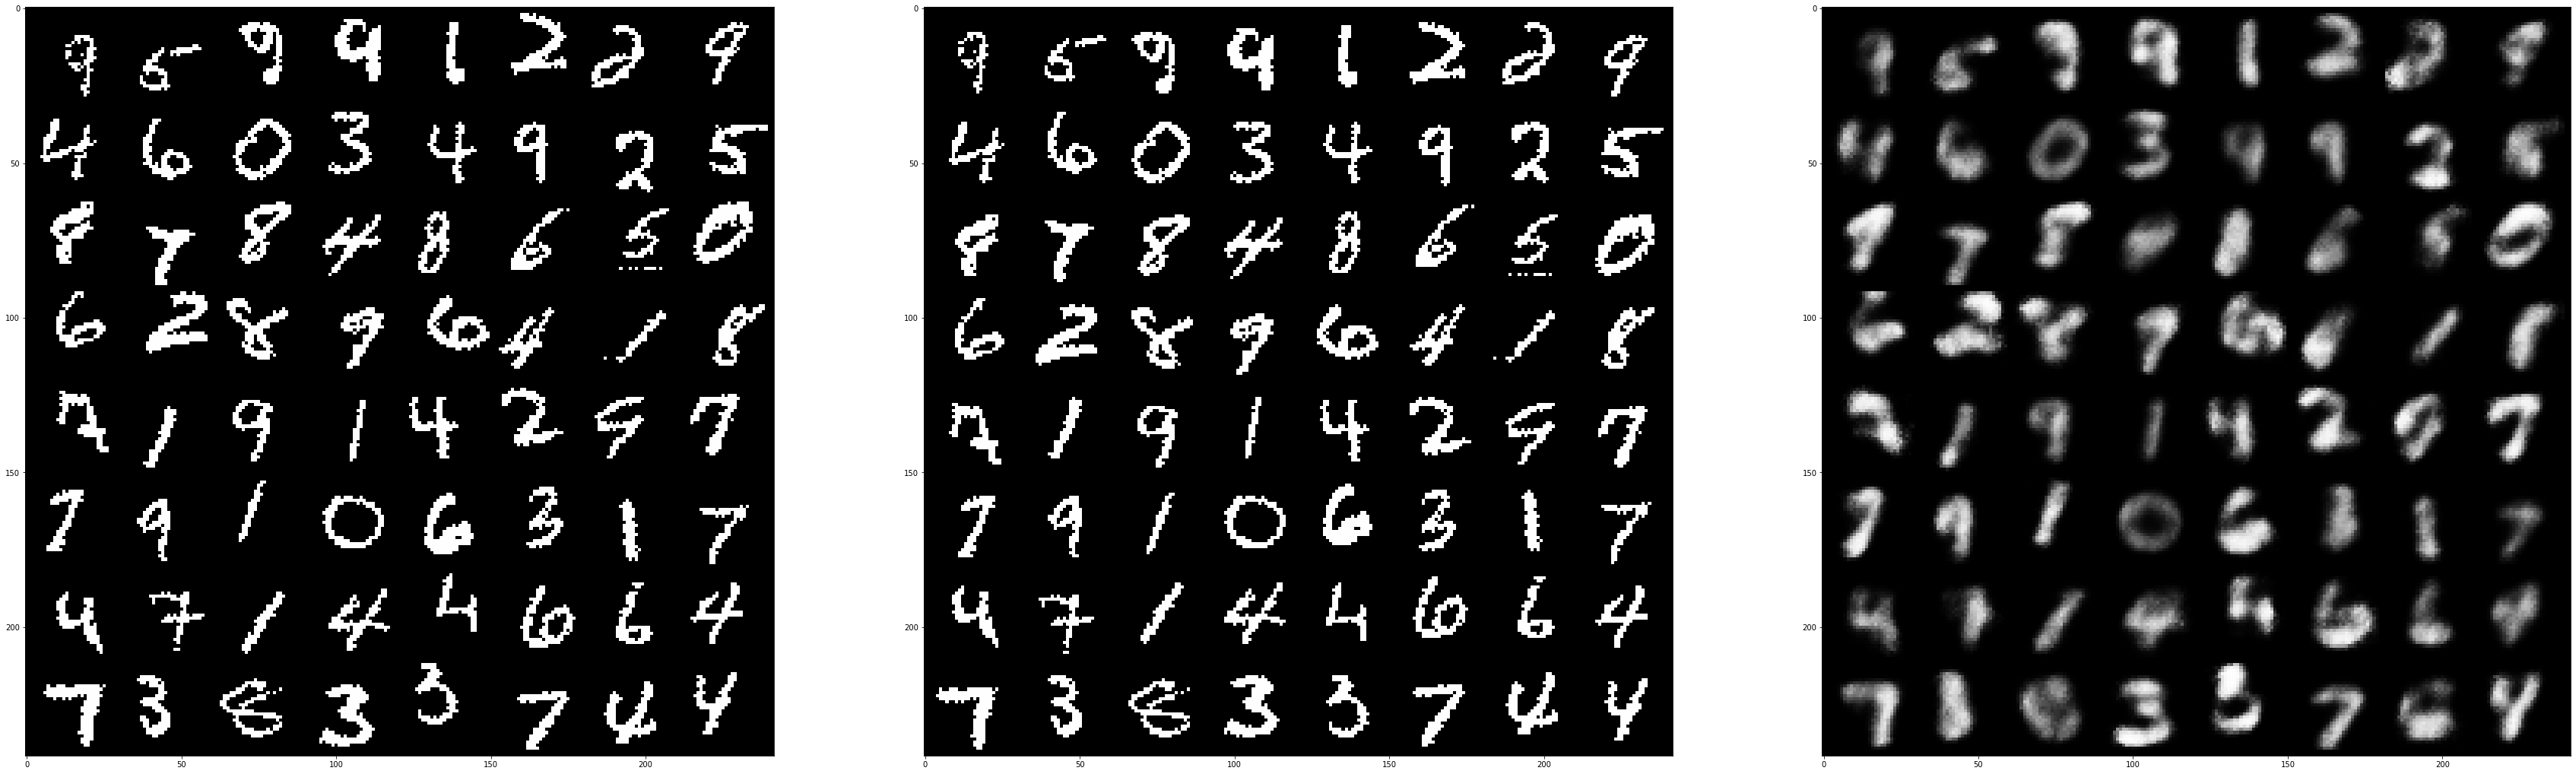

00005, 00201 loss : 0.18251, time: 635.89


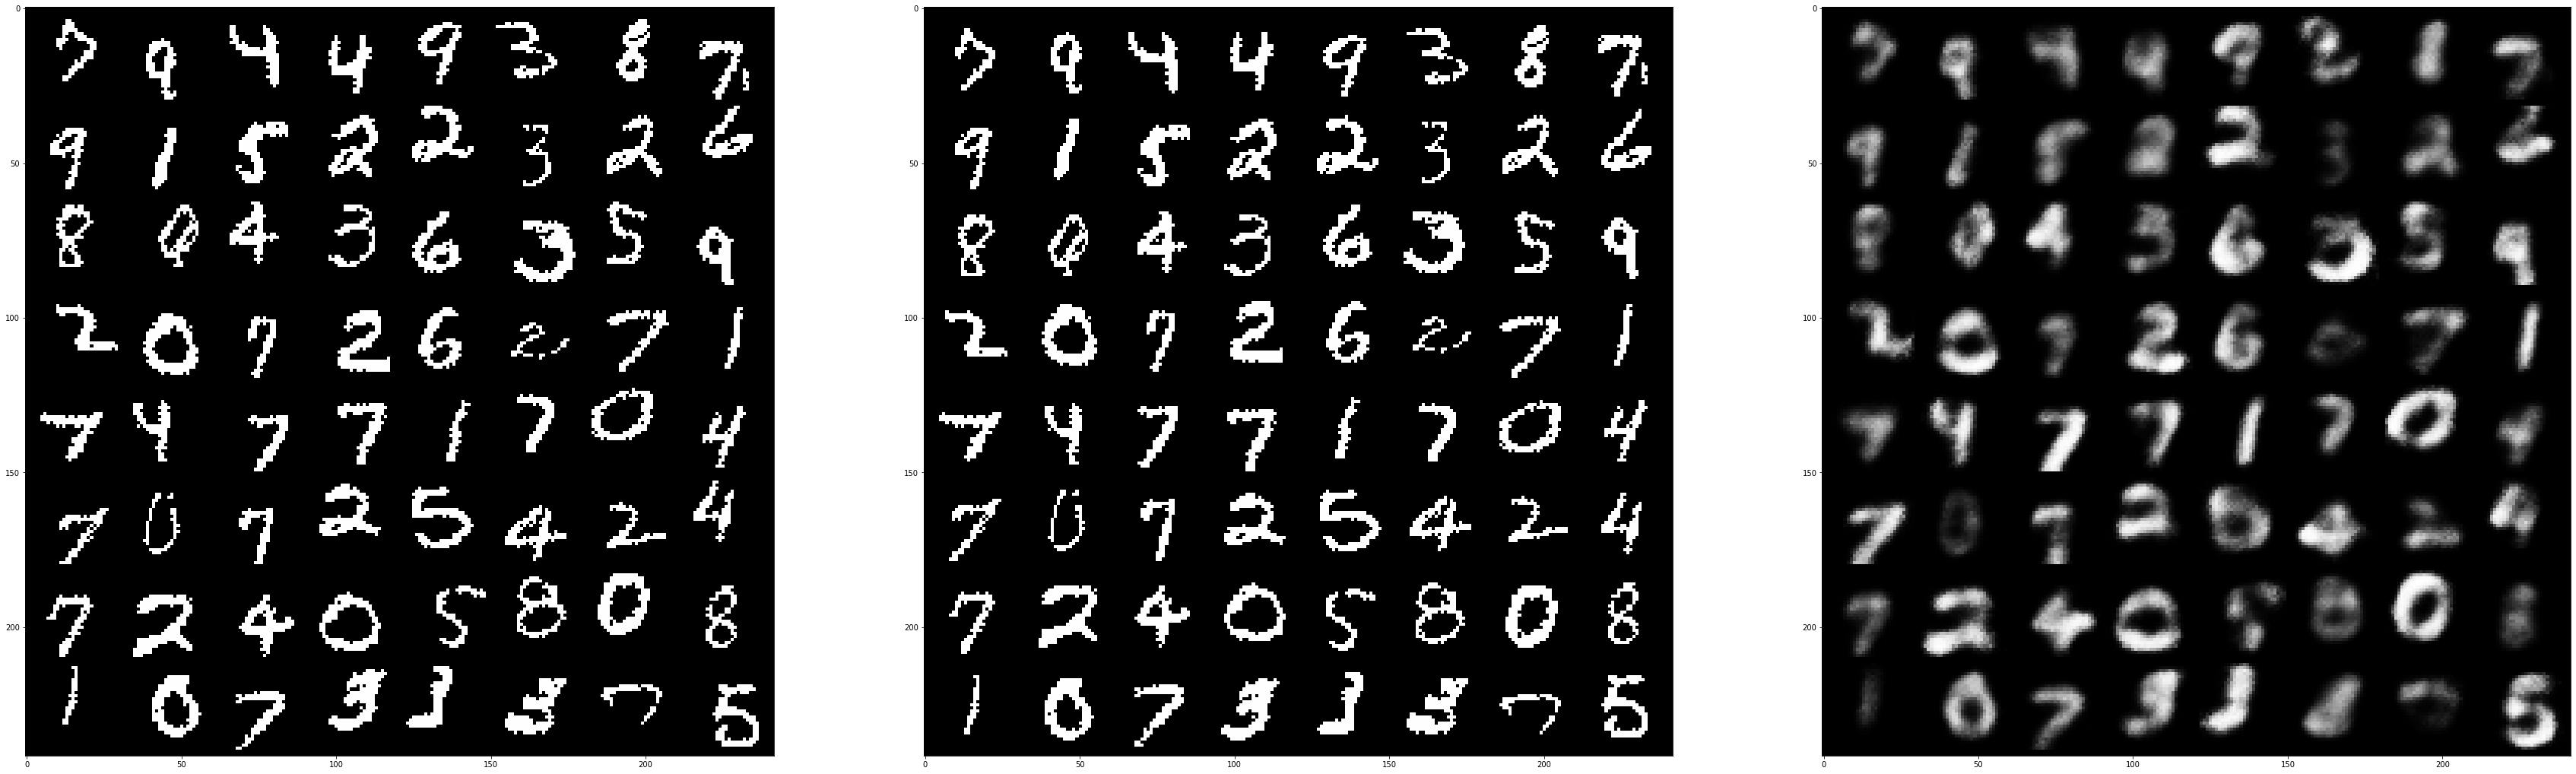

00005, 00301 loss : 0.18380, time: 651.78


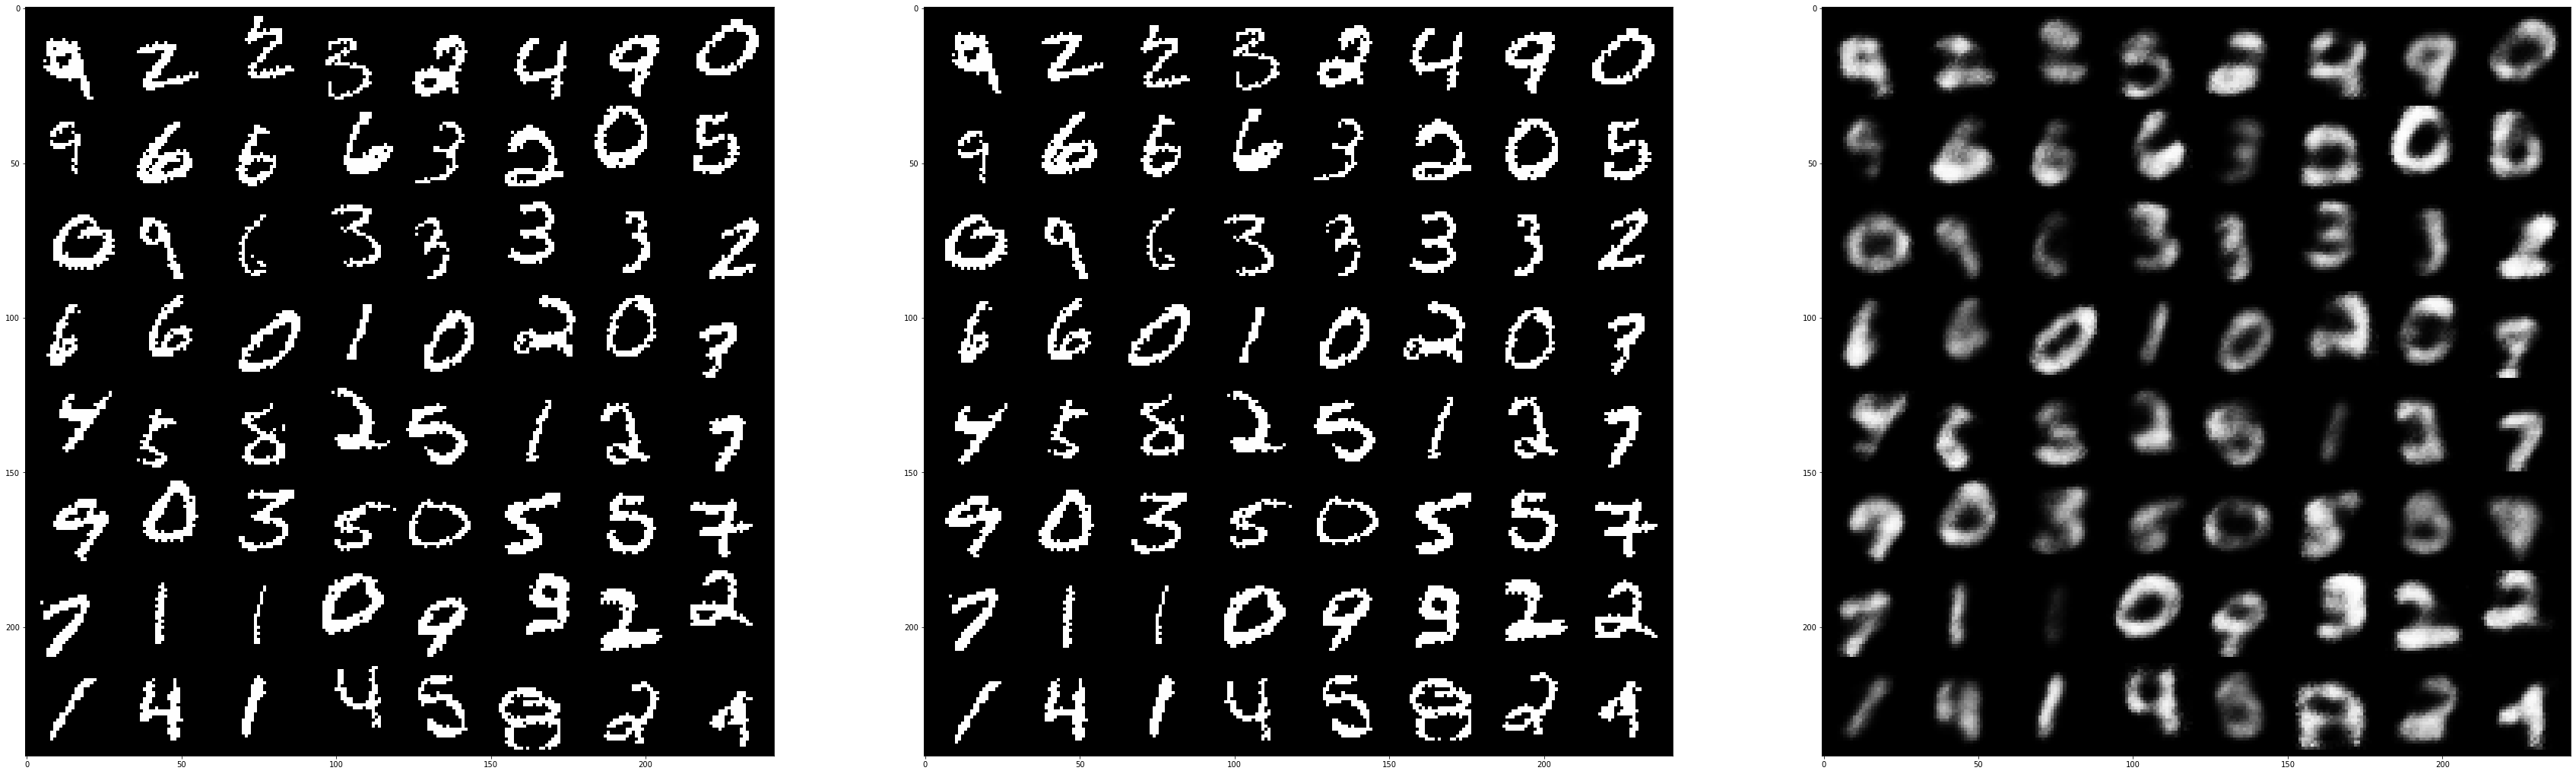

00005, 00401 loss : 0.18322, time: 667.67


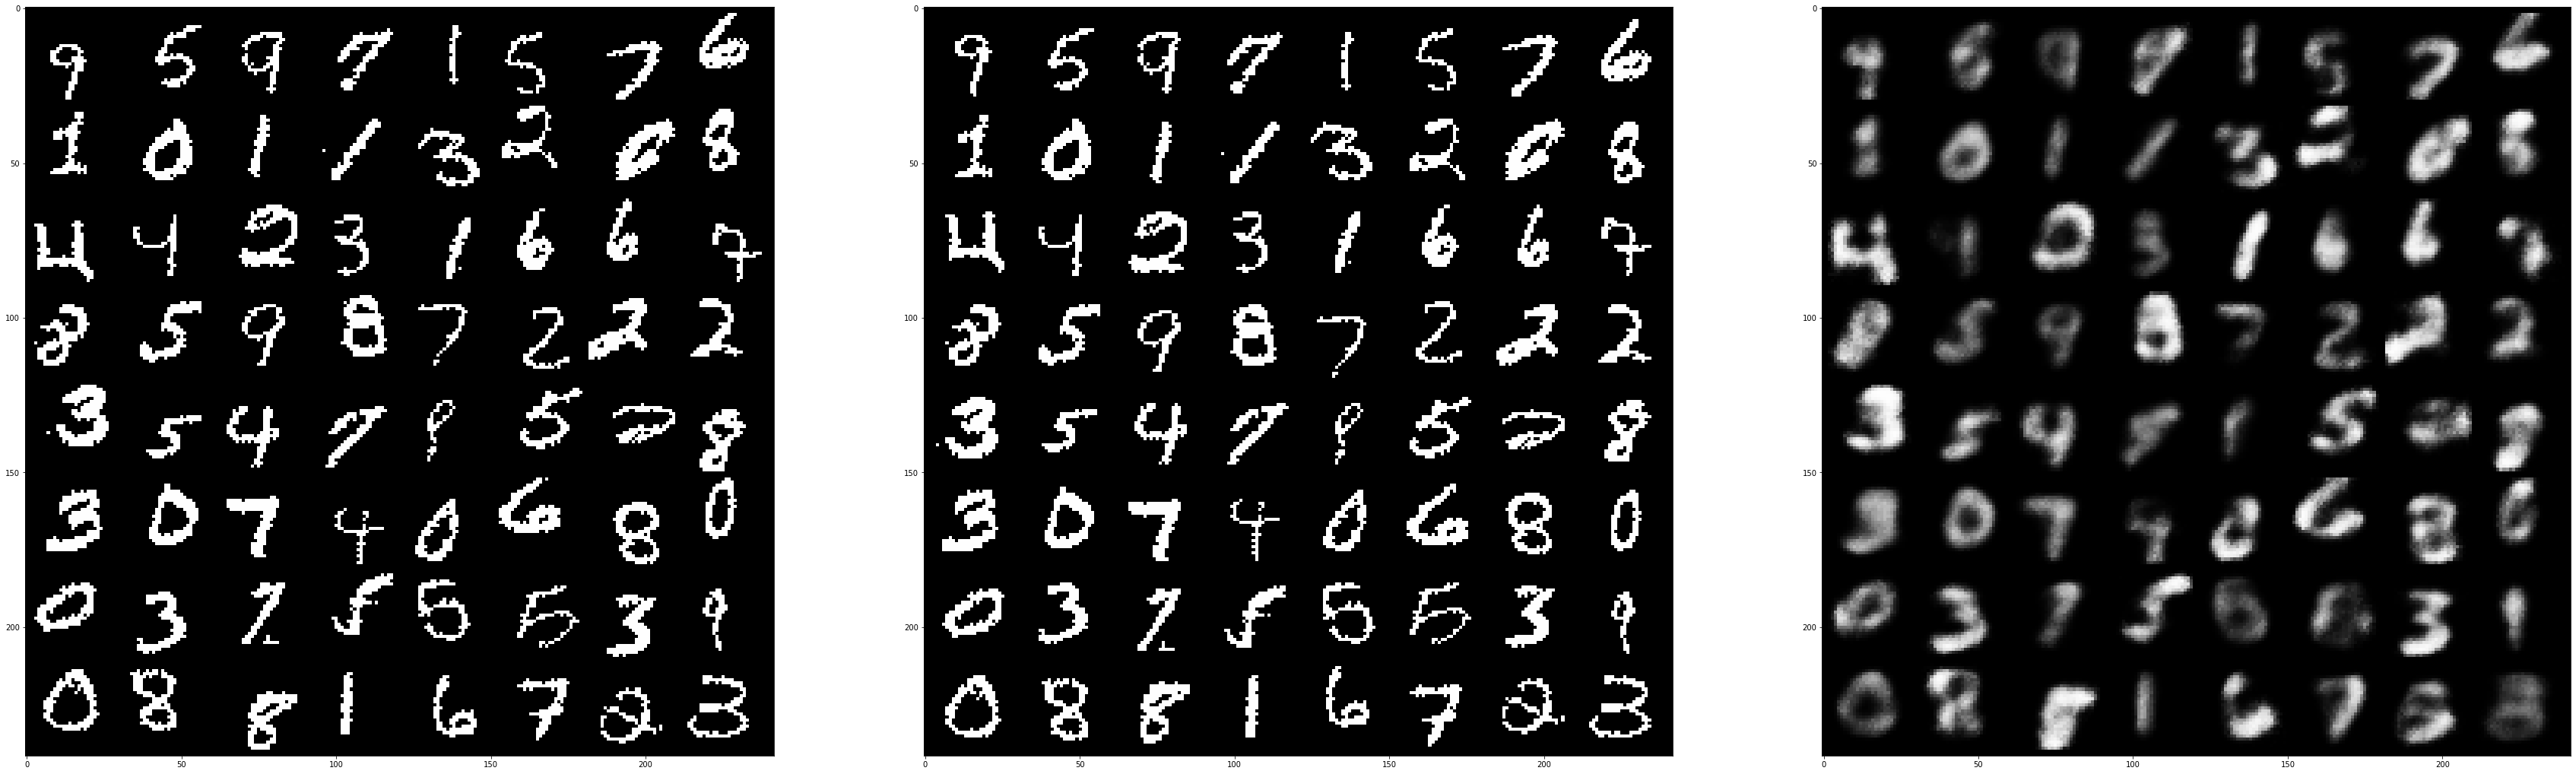

00005, 00501 loss : 0.18212, time: 683.52


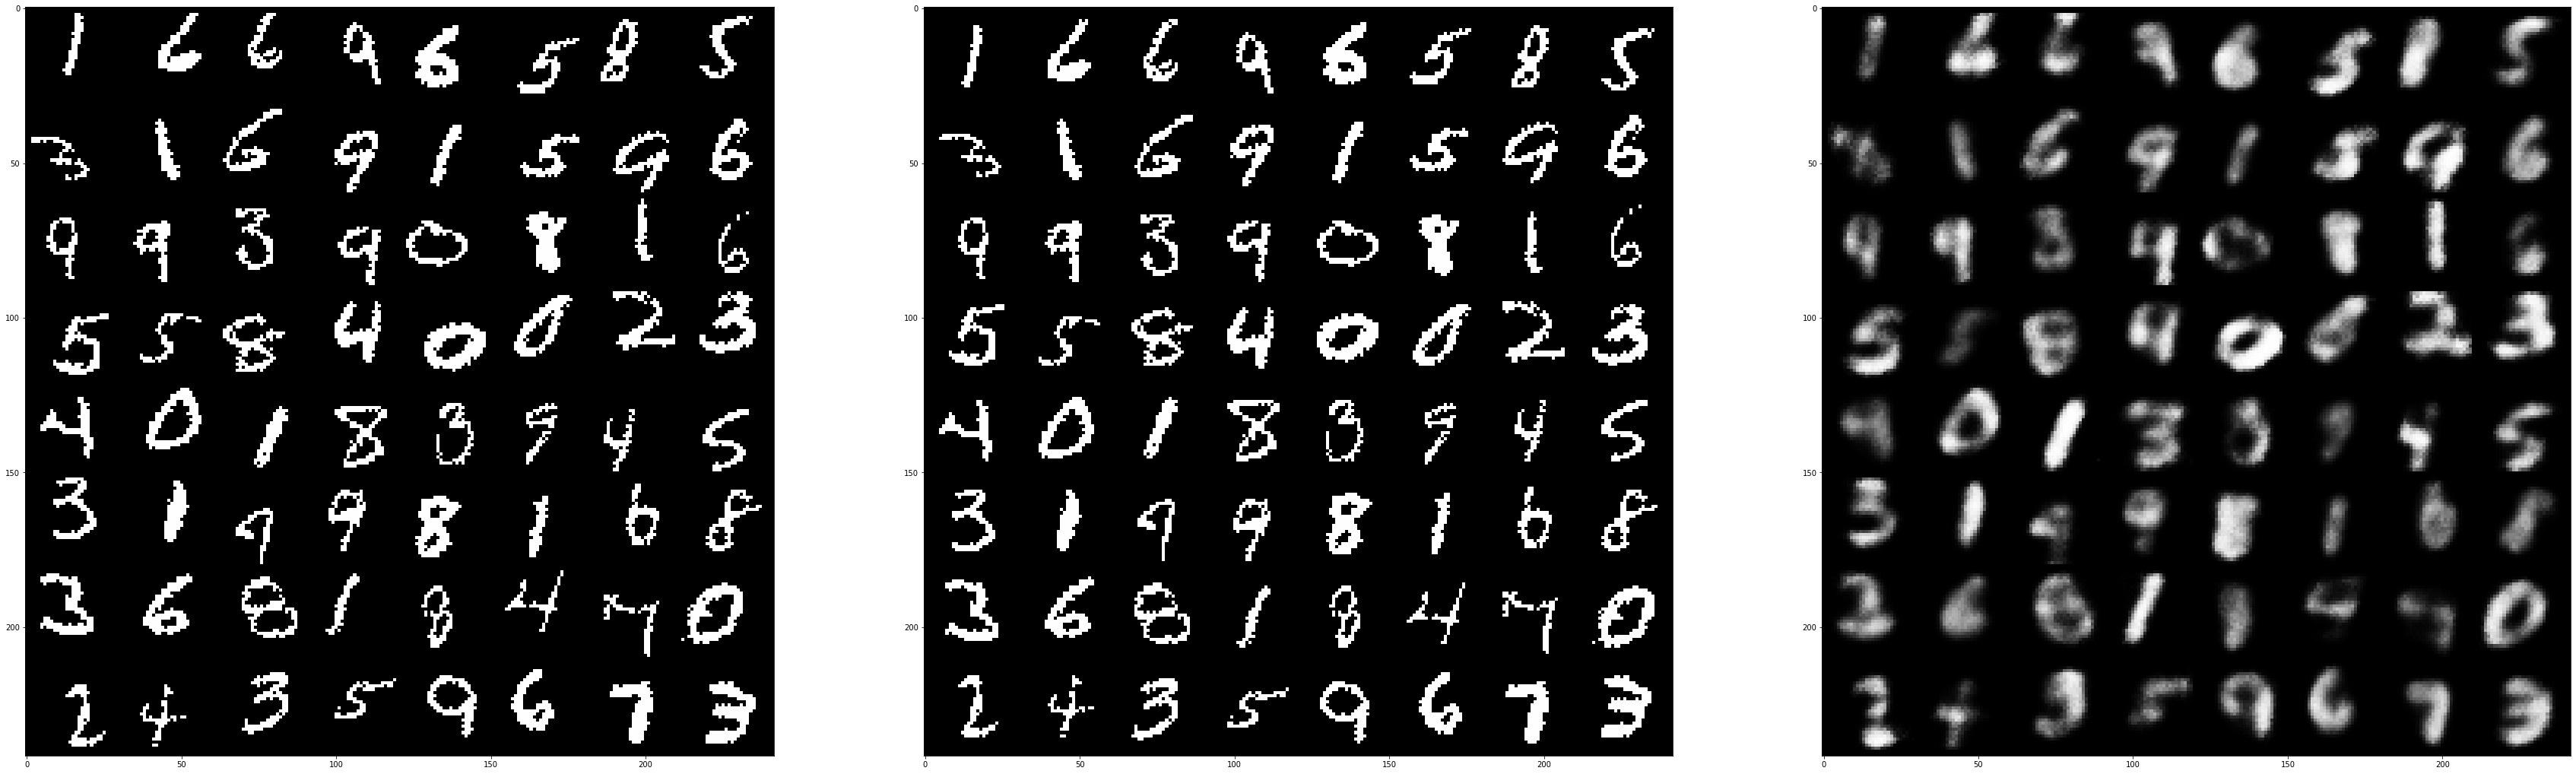

00005, 00601 loss : 0.18232, time: 699.40


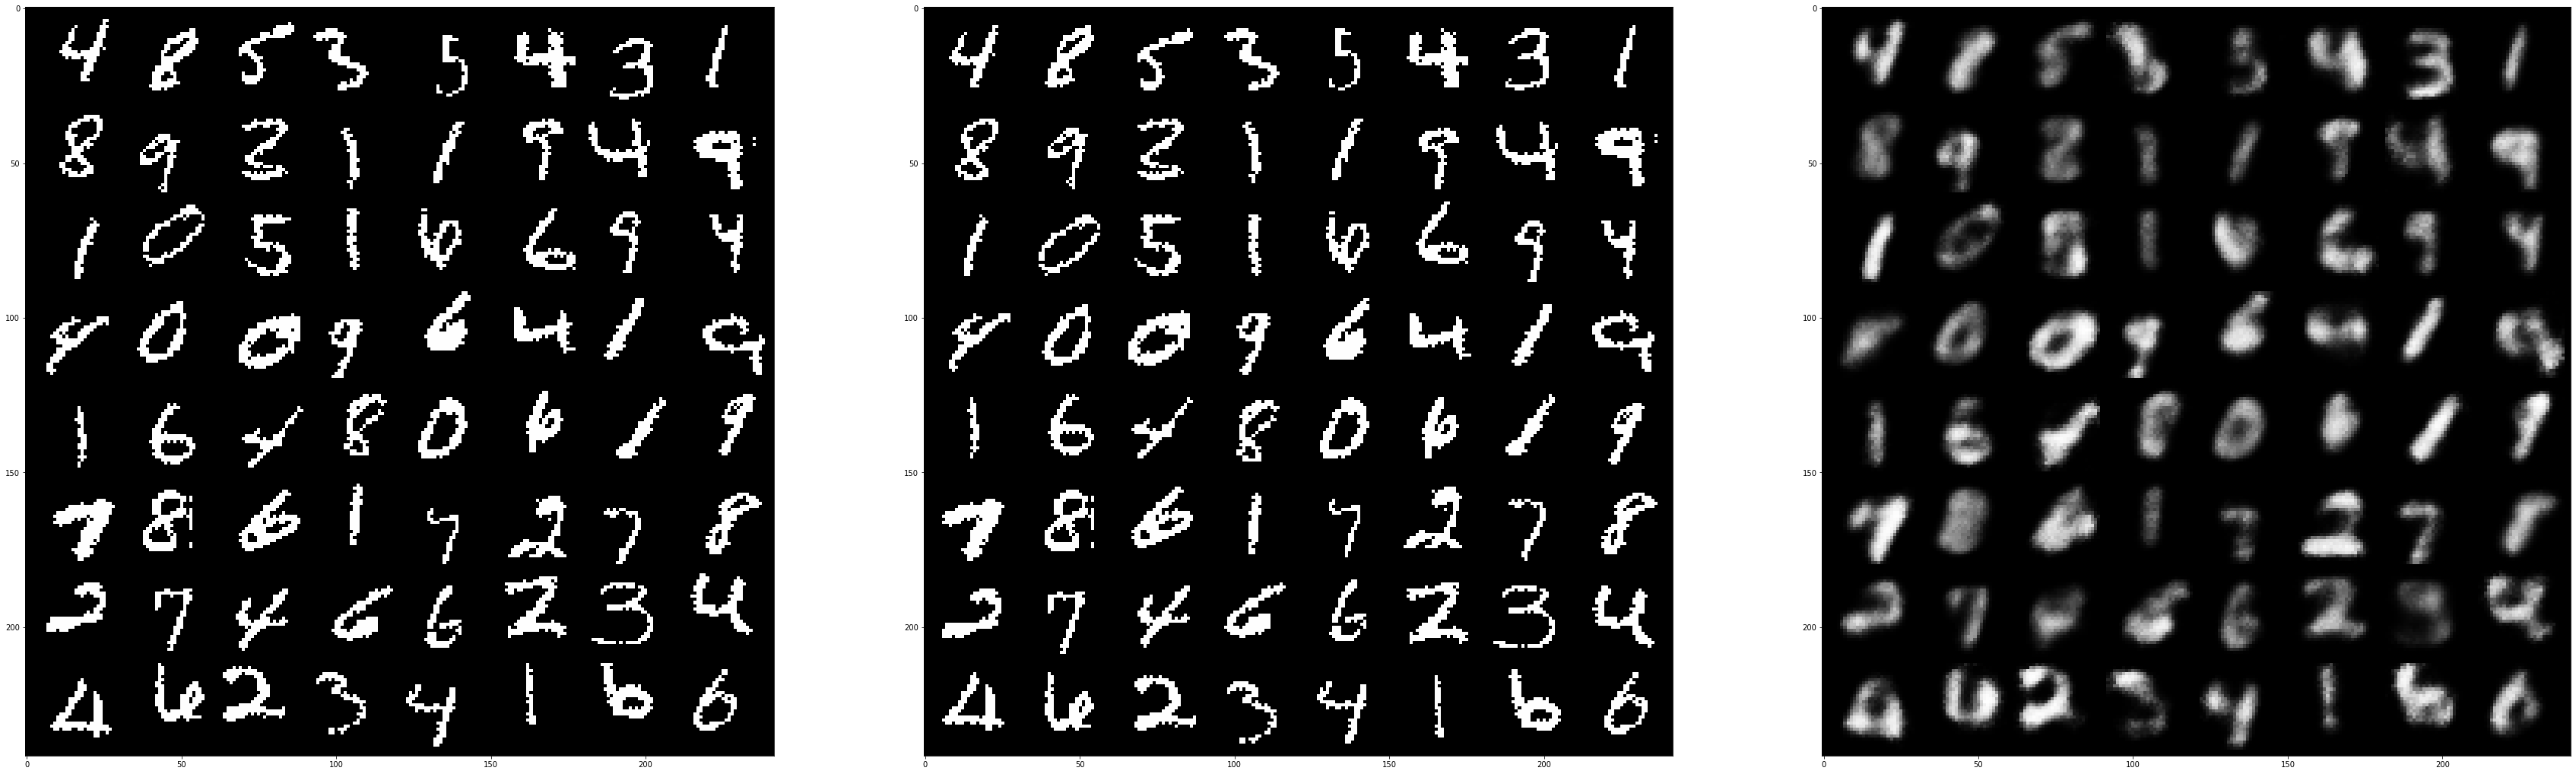

00005, 00701 loss : 0.18206, time: 715.27


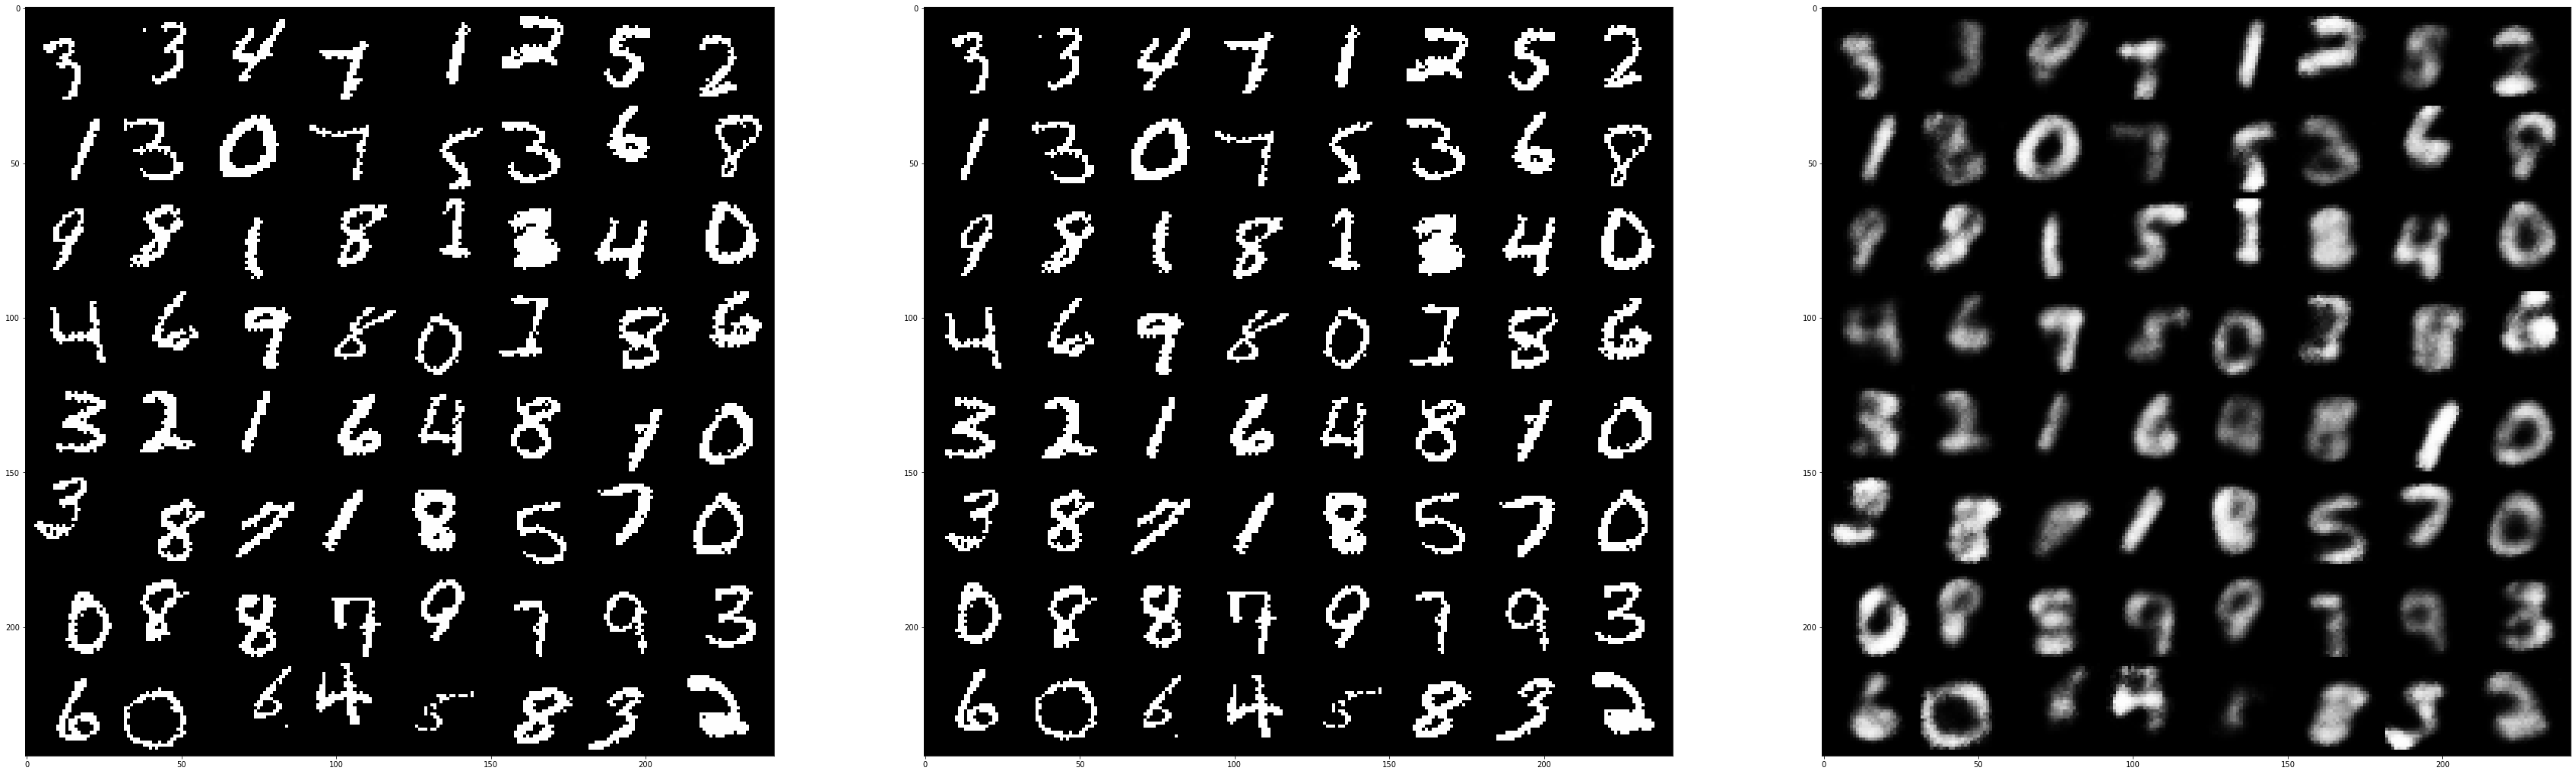

00005, 00801 loss : 0.18185, time: 731.30


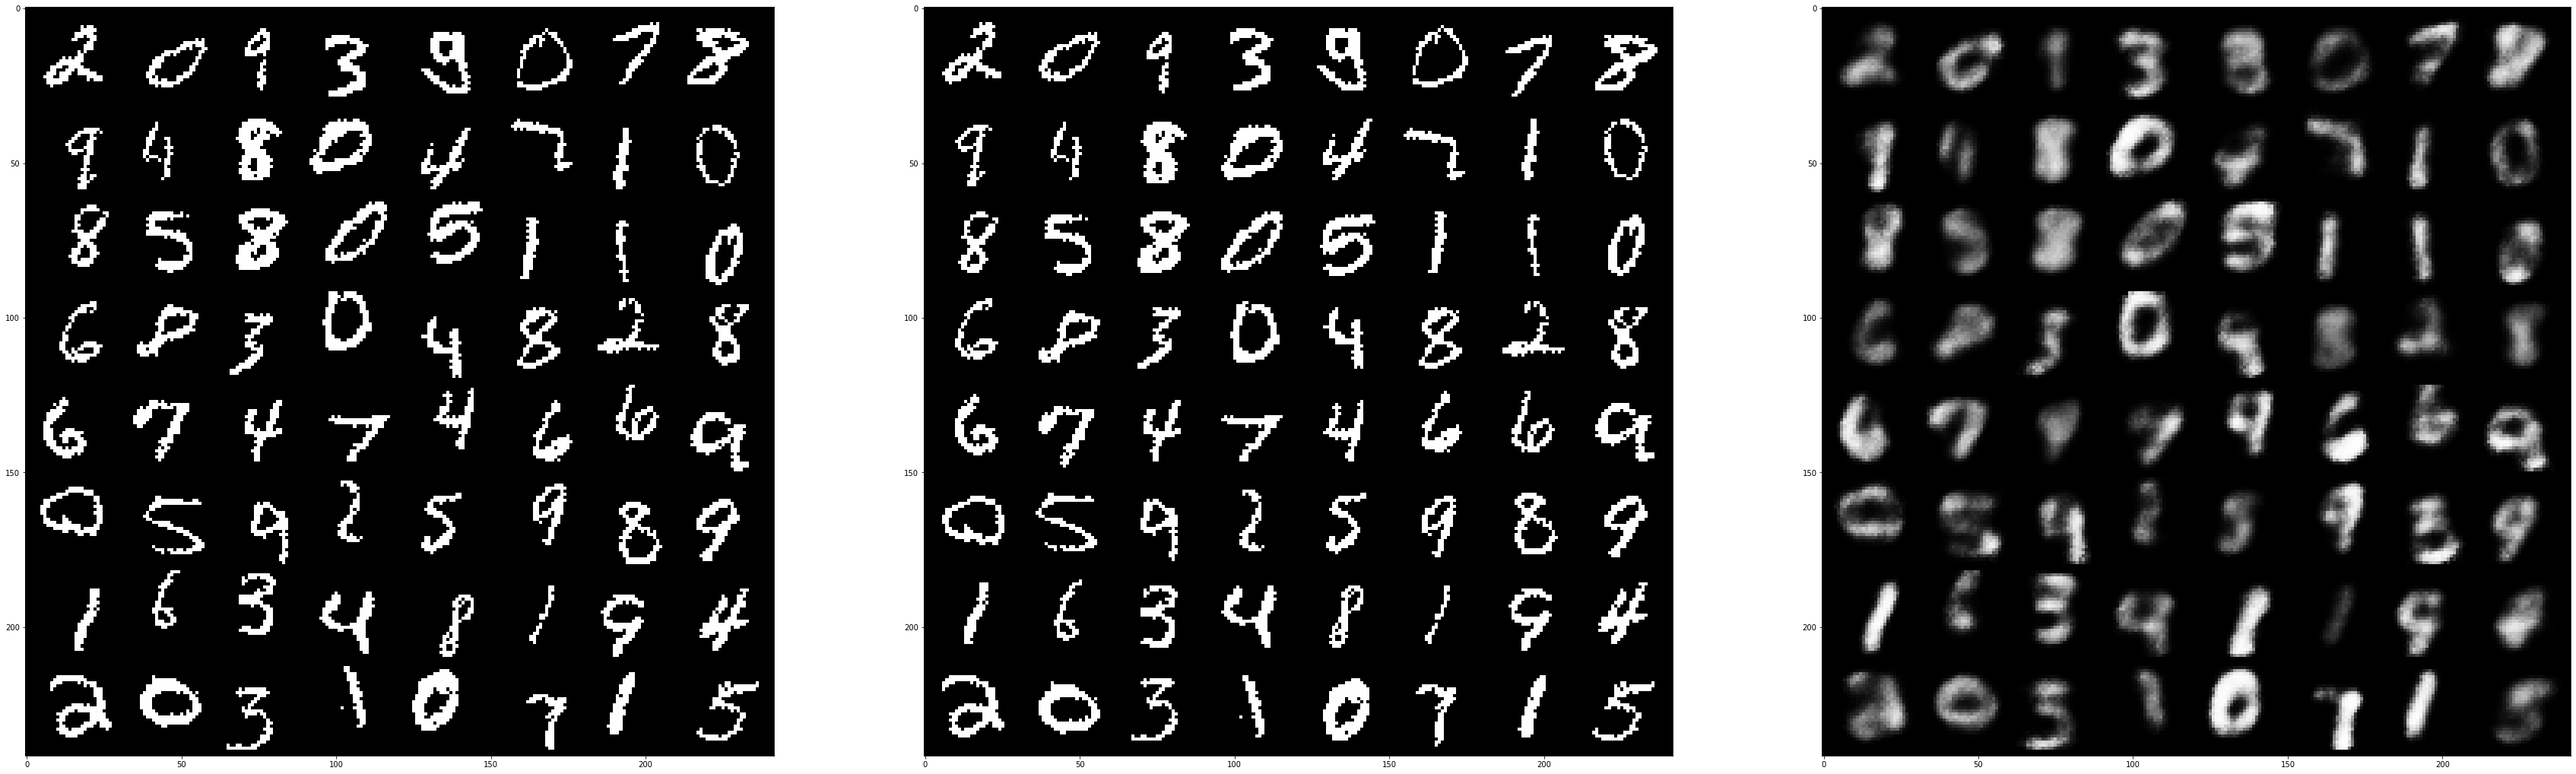

00005, 00901 loss : 0.18251, time: 747.53


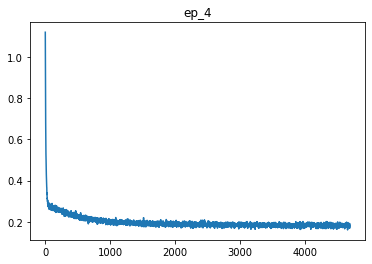

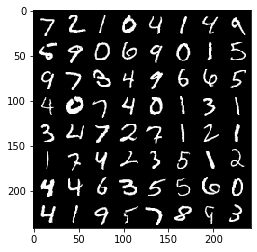

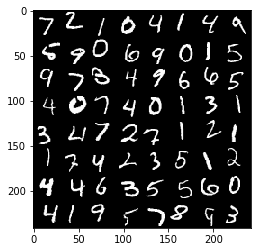

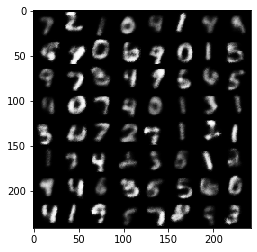

In [255]:
device = 'cuda:0'
import time
start_time = time.time()    
capL = CapLayer(num_caps=30, in_dim=28*28, cap_dim=10, gen_dim=20)
capL = capL.to(device)
crit = nn.BCELoss()
optimizer = optim.Adam(capL.parameters(), lr = 0.001)  

#e_i = []
#e_l = []
ii = 0
s_i = []
s_l = []
for epoch in range(NUM_EPOCH):
    runn_loss = 0.0
    for i, data in enumerate(trainloader,1):
        inp, _ = data
        inp = torch.bernoulli(inp)  # make image binary to be compatible with Bernouli loss
        target, dxy = BatchShift(inp.numpy().copy(),[-4,4])
        target = torch.from_numpy(target)
        
        
        dxy = Variable(torch.from_numpy(dxy).float())
        inp = Variable(inp)
        inp = inp.to(device)
        target = target.to(device)
        target = Variable(target)
        dxy = dxy.to(device)
        optimizer.zero_grad()
        
        out = capL(inp, dxy)
        
        outc = out
        out = out.view(-1, 1, 28,28)
        loss = crit(out, target)
        loss.backward()
        optimizer.step()
        runn_loss += loss.data.item()
        s_i.append(ii)
        ii+=1
        s_l.append(loss.data.item())

        if i % 100 == 0:
#             show_batch(target.data.detach().cpu(), title='Target', save = True)
#             show_batch(inp.data.detach().cpu(), title = 'Input', save = True)
#             show_batch(out.data.detach().cpu(), title = 'output', save = True)
            show3(target, inp, out)
            print('{0:05d}, {1:05d} loss : {2:6.5f}, time: {3:1.2f}'.format(epoch+1, i+1, runn_loss / 100, time.time()-start_time))
            runn_loss = 0
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(s_i, s_l)
ax.set_title('ep_{}'.format(epoch))
fig.savefig('plots/ep_{}.png'.format(epoch))



# Showing test image
data = iter(testloader)
img, _  = data.next()

targ , dxy = BatchShift(img.numpy().copy(),[-4,4])
out = capL(img.to(device), torch.from_numpy(dxy).to(device))
out = out.view(-1,1,28,28)
show_batch(img, title='Test_Input')
plt.show()
show_batch(torch.from_numpy(targ), title='Test_Targer')
plt.show()
show_batch(out.data.detach().cpu(), title='Test_output')
plt.show()
#print(R)

0.18187713637948036

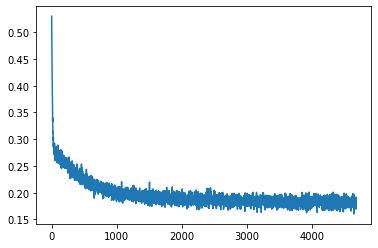

In [316]:
plt.plot(s_l[10:])
np.mean(s_l[-100:])

In [317]:
# check paper's claim that pose xy infers relative position of feature. 
# proportionally right for some capsules, not scale is off.

data = iter(testloader)
img, _  = data.next()
c = 1
targ0,dxy0 = BatchShift(img.numpy().copy(),[0,0], random=False)
out0 = capL(torch.from_numpy(targ0).to(device), torch.from_numpy(dxy0).to(device))
xy0 = capL.caps[c].x_y.clone()
p0 = capL.caps[c].prb.clone()
targ3,dxy3 = BatchShift(img.numpy().copy(),[4,0], random=False)
out3 = capL(torch.from_numpy(targ3).to(device), torch.from_numpy( -dxy3).to(device))
xy3 = capL.caps[c].x_y.clone()
p3 = capL.caps[c].prb.clone()
a = (xy3-xy0).detach().cpu()
b = (p3).detach().cpu()
ab = np.vstack( (a.T,b.T) ).T
print (ab.mean(0))
print(ab)

[ 1.6291584  -0.44228107  0.35105187]
[[ 1.9748065  -0.16585958  0.33820882]
 [ 1.5104672  -0.22737229  0.36480227]
 [ 0.6091292  -0.24405253  0.44052225]
 [ 2.3451824  -0.62213016  0.32488194]
 [ 1.839945   -0.75437975  0.16266209]
 [ 0.6567986  -0.22068238  0.48524866]
 [ 1.7166834  -0.1098268   0.4104765 ]
 [ 0.5875475  -0.36352754  0.44699353]
 [ 1.5032082  -0.47595182  0.13924688]
 [ 1.8765903  -0.42376065  0.42389438]
 [ 2.2192237  -1.2473229   0.12369989]
 [ 1.1208788  -0.5146197   0.3038935 ]
 [ 1.4311521  -0.03787601  0.4588943 ]
 [ 1.6099229  -1.0468252   0.16858763]
 [ 1.8441012  -0.4311942   0.569442  ]
 [ 1.5758095  -0.7032026   0.31739858]
 [ 2.188865   -0.6129532   0.30043444]
 [ 2.5887377  -0.3353727   0.28859493]
 [ 0.22561055  0.16879869  0.2866404 ]
 [ 1.4161834  -0.15159214  0.36356205]
 [ 1.7738254  -0.15316391  0.48841992]
 [ 1.4629049  -0.5256587   0.5056291 ]
 [ 0.75894433 -0.05685127  0.28671652]
 [ 1.4828358  -0.29383194  0.36110467]
 [ 0.9424735  -0.17915654 

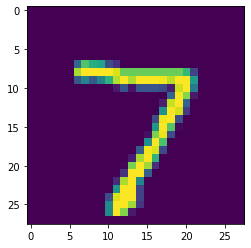

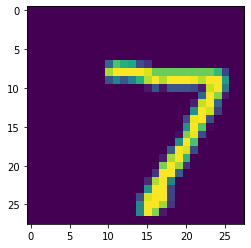

In [313]:
# confirm target image is shifted correctly
plt.figure()
plt.imshow(targ0[0].reshape([28,28]))
plt.figure()
plt.imshow(targ3[0].reshape([28,28]))


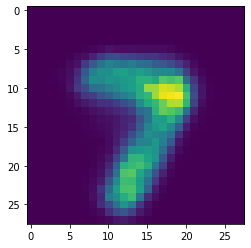

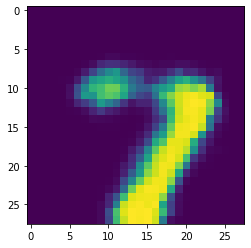

In [318]:
# confirm network can shift image
# so changing the pose can shift image, but the inferred pose itself not detecting the location of feature?
targ0,dxy0 = BatchShift(img.numpy().copy(),[0,0], random=False)
out00 = capL(torch.from_numpy(targ0).to(device), torch.from_numpy(dxy0).to(device))
out03 = capL(torch.from_numpy(targ0).to(device), torch.from_numpy( dxy0+3).to(device))

plt.figure()
plt.imshow(out00[0].reshape([28,28]).detach().cpu())
plt.figure()
plt.imshow(out03[0].reshape([28,28]).detach().cpu())


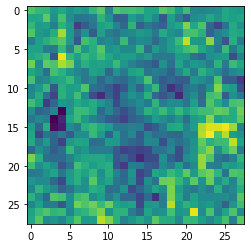

In [45]:
plt.imshow(capL.caps[4].cp.weight[0,:].view(28,28).detach().cpu())